# AirREGI ヘルプデスク入電予測 - EDA & 特徴量エンジニアリング

## 概要
このノートブックでは、時系列データの探索的データ分析と特徴量エンジニアリングを行います。

### 設計方針
- **モジュール化**: 各特徴量グループをクラスで管理
- **テスト容易性**: 各特徴量を独立してテスト可能
- **データリーケージ防止**: 時系列データで未来の情報を使わない
- **可読性**: コードの意図を明確に

In [5]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from typing import List, Optional, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定（文字化け対策）
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 表示設定
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Setup complete!")

Setup complete!


## 1. データ読み込み

In [6]:
class DataLoader:
    """データ読み込みと前処理を行うクラス"""
    
    def __init__(self, input_dir: str = '../input'):
        self.input_dir = input_dir
        
    def load_all(self) -> Dict[str, pd.DataFrame]:
        """全データを読み込み、日付型に変換"""
        print("=" * 80)
        print("データ読み込み開始")
        print("=" * 80)
        
        # データ読み込み
        calender = pd.read_csv(f'{self.input_dir}/calender_data.csv')
        cm_data = pd.read_csv(f'{self.input_dir}/cm_data.csv')
        gt_service = pd.read_csv(f'{self.input_dir}/gt_service_name.csv')
        acc_get = pd.read_csv(f'{self.input_dir}/regi_acc_get_data_transform.csv')
        call_data = pd.read_csv(f'{self.input_dir}/regi_call_data_transform.csv')
        
        # 日付カラムをdatetime型に変換
        calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
        cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
        acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
        call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
        gt_service['week'] = pd.to_datetime(gt_service['week'])
        
        # データサイズを表示
        datasets = {
            'calender': calender,
            'cm_data': cm_data,
            'gt_service': gt_service,
            'acc_get': acc_get,
            'call_data': call_data
        }
        
        print("\n読み込み完了:")
        for name, df in datasets.items():
            print(f"  {name:15s}: {df.shape}")
        
        return datasets
    
    def merge_all(self, datasets: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """全データを統合"""
        print("\n" + "=" * 80)
        print("データ統合開始")
        print("=" * 80)
        
        # メインデータ（入電数）を基準
        df = datasets['call_data'].copy()
        print(f"\nベースデータ: {df.shape}")
        
        # カレンダー情報をマージ
        df = df.merge(datasets['calender'], on='cdr_date', how='left')
        print(f"カレンダー統合後: {df.shape}")
        
        # CM情報をマージ
        df = df.merge(datasets['cm_data'], on='cdr_date', how='left')
        print(f"CM統合後: {df.shape}")
        
        # アカウント取得数をマージ
        df = df.merge(datasets['acc_get'], on='cdr_date', how='left')
        print(f"アカウント取得数統合後: {df.shape}")
        
        # Google Trendsを週次→日次に展開
        gt_daily = self._expand_weekly_to_daily(datasets['gt_service'])
        df = df.merge(gt_daily, on='cdr_date', how='left')
        print(f"Google Trends統合後: {df.shape}")
        
        # 日付でソート（時系列処理のため必須）
        df = df.sort_values('cdr_date').reset_index(drop=True)
        print("\n日付でソート完了（時系列処理のため）")
        
        # 欠損値確認
        print("\n欠損値の数（上位10）:")
        missing = df.isnull().sum().sort_values(ascending=False).head(10)
        for col, count in missing.items():
            if count > 0:
                print(f"  {col:30s}: {count:4d} ({count/len(df)*100:.1f}%)")
        
        return df
    
    @staticmethod
    def _expand_weekly_to_daily(gt_service: pd.DataFrame) -> pd.DataFrame:
        """週次データを日次に展開"""
        print("\nGoogle Trendsを週次→日次に展開中...")
        daily_records = []
        
        for _, row in gt_service.iterrows():
            week_start = row['week']
            for i in range(7):
                date = week_start + timedelta(days=i)
                daily_records.append({
                    'cdr_date': date,
                    'search_cnt': row['search_cnt']
                })
        
        return pd.DataFrame(daily_records)


# データ読み込み実行
loader = DataLoader()
datasets = loader.load_all()
df_raw = loader.merge_all(datasets)

print("\n" + "=" * 80)
print(f"統合データ: {df_raw.shape}")
print(f"期間: {df_raw['cdr_date'].min()} ~ {df_raw['cdr_date'].max()}")
print("=" * 80)


データ読み込み開始

読み込み完了:
  calender       : (670, 10)
  cm_data        : (762, 2)
  gt_service     : (109, 2)
  acc_get        : (701, 2)
  call_data      : (670, 2)

データ統合開始

ベースデータ: (670, 2)
カレンダー統合後: (670, 11)
CM統合後: (670, 12)
アカウント取得数統合後: (670, 13)

Google Trendsを週次→日次に展開中...
Google Trends統合後: (670, 14)

日付でソート完了（時系列処理のため）

欠損値の数（上位10）:
  holiday_name                  :  632 (94.3%)

統合データ: (670, 14)
期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00


## 2. 特徴量エンジニアリング

### 設計パターン
各特徴量グループを独立したクラスとして実装し、テストと保守を容易にします。

In [7]:
from abc import ABC, abstractmethod

class BaseFeatureEngineer(ABC):
    """特徴量エンジニアリングの基底クラス"""
    
    def __init__(self, name: str):
        self.name = name
        self.created_features: List[str] = []
    
    @abstractmethod
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """特徴量を作成（サブクラスで実装）"""
        pass
    
    def get_feature_names(self) -> List[str]:
        """作成された特徴量名のリストを取得"""
        return self.created_features
    
    def describe(self, df: pd.DataFrame) -> pd.DataFrame:
        """特徴量の統計情報を取得"""
        if not self.created_features:
            print(f"{self.name}: 特徴量が未作成です")
            return pd.DataFrame()
        return df[self.created_features].describe()


class TimeBasedFeatures(BaseFeatureEngineer):
    """日付から派生する基本的な時系列特徴量
    
    これらは未来の情報を使わないため、データリーケージの心配がありません。
    """
    
    def __init__(self):
        super().__init__("時系列基本特徴量")
    
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # 年月日の特徴量
        df['year'] = df['cdr_date'].dt.year
        df['month'] = df['cdr_date'].dt.month
        df['day_of_month'] = df['cdr_date'].dt.day
        df['quarter'] = df['cdr_date'].dt.quarter
        df['day_of_year'] = df['cdr_date'].dt.dayofyear
        df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
        
        # 経過日数
        df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
        
        # 月初・月末フラグ
        df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
        df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
        
        # 週初・週末（既存のdowを利用）
        if 'dow' in df.columns:
            df['is_week_start'] = (df['dow'] == 1).astype(int)  # 月曜
            df['is_week_end'] = (df['dow'] == 5).astype(int)    # 金曜
        
        self.created_features = [
            'year', 'month', 'day_of_month', 'quarter', 'day_of_year',
            'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end',
            'is_week_start', 'is_week_end'
        ]
        
        print(f"{self.name}: {len(self.created_features)}個の特徴量を作成")
        return df


class LagFeatures(BaseFeatureEngineer):
    """ラグ特徴量（過去のデータ）
    
    重要:
    - shift()を使って未来の情報が混入しないようにする
    - データは日付順にソート済みであることが前提
    """
    
    def __init__(self, target_col: str = 'call_num', lags: List[int] = [1, 2, 3, 5, 7, 14, 30]):
        super().__init__("ラグ特徴量")
        self.target_col = target_col
        self.lags = lags
    
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        if self.target_col not in df.columns:
            print(f"警告: {self.target_col}が見つかりません")
            return df
        
        for lag in self.lags:
            col_name = f'lag_{lag}'
            df[col_name] = df[self.target_col].shift(lag)
            self.created_features.append(col_name)
        
        print(f"{self.name}: {len(self.created_features)}個の特徴量を作成")
        print(f"  対象変数: {self.target_col}")
        print(f"  ラグ: {self.lags}")
        print(f"  注意: 最初の{max(self.lags)}日間はNaNになります")
        
        return df


class RollingFeatures(BaseFeatureEngineer):
    """移動統計量特徴量（移動平均、移動標準偏差など）
    
    重要:
    - rolling()の前にshift(1)を適用してデータリーケージを防止
    - 当日のデータが含まれないようにする
    """
    
    def __init__(self, target_col: str = 'call_num', windows: List[int] = [3, 7, 14, 30]):
        super().__init__("移動統計量特徴量")
        self.target_col = target_col
        self.windows = windows
    
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        if self.target_col not in df.columns:
            print(f"警告: {self.target_col}が見つかりません")
            return df
        
        for window in self.windows:
            # 移動平均（当日を含まない）
            ma_col = f'ma_{window}'
            df[ma_col] = df[self.target_col].shift(1).rolling(
                window=window, min_periods=1
            ).mean()
            self.created_features.append(ma_col)
            
            # 移動標準偏差（変動性を捉える）
            std_col = f'ma_std_{window}'
            df[std_col] = df[self.target_col].shift(1).rolling(
                window=window, min_periods=1
            ).std()
            self.created_features.append(std_col)
            
            # 移動最大値
            max_col = f'ma_max_{window}'
            df[max_col] = df[self.target_col].shift(1).rolling(
                window=window, min_periods=1
            ).max()
            self.created_features.append(max_col)
            
            # 移動最小値
            min_col = f'ma_min_{window}'
            df[min_col] = df[self.target_col].shift(1).rolling(
                window=window, min_periods=1
            ).min()
            self.created_features.append(min_col)
        
        print(f"{self.name}: {len(self.created_features)}個の特徴量を作成")
        print(f"  対象変数: {self.target_col}")
        print(f"  ウィンドウ: {self.windows}")
        print(f"  統計量: 平均, 標準偏差, 最大値, 最小値")
        
        return df


class DomainFeatures(BaseFeatureEngineer):
    """ドメイン知識に基づく特徴量
    
    - CM効果の累積
    - Google Trendsの平滑化
    - アカウント取得数の傾向
    - 曜日ごとの過去平均
    """
    
    def __init__(self):
        super().__init__("ドメイン特徴量")
    
    def create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # CM効果の累積（過去7日間のCM実施回数）
        if 'cm_flg' in df.columns:
            df['cm_7d_sum'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
            df['cm_14d_sum'] = df['cm_flg'].shift(1).rolling(window=14, min_periods=1).sum()
            self.created_features.extend(['cm_7d_sum', 'cm_14d_sum'])
        
        # Google Trendsの移動平均（ノイズ除去）
        if 'search_cnt' in df.columns:
            df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
            df['gt_ma_14'] = df['search_cnt'].shift(1).rolling(window=14, min_periods=1).mean()
            self.created_features.extend(['gt_ma_7', 'gt_ma_14'])
        
        # アカウント取得数の移動平均
        if 'acc_get_cnt' in df.columns:
            df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
            df['acc_ma_14'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).mean()
            self.created_features.extend(['acc_ma_7', 'acc_ma_14'])
        
        # 曜日ごとの過去平均（同じ曜日のパターンを捉える）
        if 'dow' in df.columns and 'call_num' in df.columns:
            df['dow_avg'] = np.nan
            for dow in df['dow'].unique():
                mask = df['dow'] == dow
                df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
            self.created_features.append('dow_avg')
        
        print(f"{self.name}: {len(self.created_features)}個の特徴量を作成")
        return df


print("特徴量エンジニアリングクラス定義完了")
df.columns

特徴量エンジニアリングクラス定義完了


NameError: name 'df' is not defined

In [ ]:
# セル4を実行済みなら、これで確認できる
print(type(datasets))  # <class 'dict'>
print(datasets.keys())  # dict_keys(['calender', 'cm_data', 'gt_service', 'acc_get', 'call_data'])

# calenderデータにアクセス
print(datasets['calender']['cdr_date'].dtype)  # datetime64[ns]
print(datasets['calender']['cdr_date'].head())

<class 'dict'>
dict_keys(['calender', 'cm_data', 'gt_service', 'acc_get', 'call_data'])
datetime64[ns]
0   2018-06-01
1   2018-06-02
2   2018-06-03
3   2018-06-04
4   2018-06-05
Name: cdr_date, dtype: datetime64[ns]


In [ ]:
import os

# 保存先ディレクトリの作成
output_dir = '../output/datasets'
os.makedirs(output_dir, exist_ok=True)

# 各DataFrameをCSVとして保存
for name, df in datasets.items():
    filepath = f'{output_dir}/{name}.csv'
df.to_csv(filepath, index=False, encoding='utf-8')
print(f"保存完了: {filepath} ({df.shape})")

保存完了: ../output/datasets/call_data.csv ((670, 2))


In [ ]:
"""
データ構造を確認するスクリプト
EDAノートブックのセル4を実行した後に実行してください
"""

import pandas as pd
from datetime import timedelta

# ==========================================
# サンプルデータで説明
# ==========================================

print("=" * 80)
print("データ構造の説明（サンプルデータ）")
print("=" * 80)

# 1. 個別データ（結合前）
print("\n" + "=" * 80)
print("1. 結合前の個別データ（datasets）")
print("=" * 80)

call_data = pd.DataFrame({
    'cdr_date': pd.to_datetime(['2018-06-01', '2018-06-02', '2018-06-03']),
    'call_num': [183, 0, 96]
})
print("\n[call_data] - 入電数（メインデータ）")
print(call_data)
print(f"shape: {call_data.shape} （{call_data.shape[0]}行 × {call_data.shape[1]}列）")
print(f"columns: {call_data.columns.tolist()}")

calender = pd.DataFrame({
    'cdr_date': pd.to_datetime(['2018-06-01', '2018-06-02', '2018-06-03']),
    'dow': [5, 6, 7],
    'dow_name': ['Friday', 'Saturday', 'Sunday'],
    'holiday_flag': [0, 0, 0]
})
print("\n[calender] - カレンダー情報")
print(calender)
print(f"shape: {calender.shape} （{calender.shape[0]}行 × {calender.shape[1]}列）")
print(f"columns: {calender.columns.tolist()}")

cm_data = pd.DataFrame({
    'cdr_date': pd.to_datetime(['2018-06-01', '2018-06-02', '2018-06-03']),
    'cm_flg': [0, 1, 0]
})
print("\n[cm_data] - CM実施フラグ")
print(cm_data)
print(f"shape: {cm_data.shape} （{cm_data.shape[0]}行 × {cm_data.shape[1]}列）")
print(f"columns: {cm_data.columns.tolist()}")

# 2. 結合処理
print("\n" + "=" * 80)
print("2. 結合処理（merge）")
print("=" * 80)

df = call_data.copy()
print(f"\nステップ1: call_dataをコピー")
print(f"  shape: {df.shape}")
print(f"  columns: {df.columns.tolist()}")

df = df.merge(calender, on='cdr_date', how='left')
print(f"\nステップ2: calenderを結合")
print(f"  shape: {df.shape}")
print(f"  columns: {df.columns.tolist()}")
print("  ↑ call_dataのカラム + calenderのカラム（cdr_date以外）")

df = df.merge(cm_data, on='cdr_date', how='left')
print(f"\nステップ3: cm_dataを結合")
print(f"  shape: {df.shape}")
print(f"  columns: {df.columns.tolist()}")
print("  ↑ さらにcm_dataのカラム（cdr_date以外）を追加")

# 3. 結合後のデータ
print("\n" + "=" * 80)
print("3. 結合後のデータ（df_raw）")
print("=" * 80)

print("\n[df_raw] - 全データが横に結合された1つのテーブル")
print(df)
print(f"\nshape: {df.shape} （{df.shape[0]}行 × {df.shape[1]}列）")
print(f"columns: {df.columns.tolist()}")

# 4. データの取り出し方
print("\n" + "=" * 80)
print("4. データの取り出し方")
print("=" * 80)

print("\n■ 1つの列を取り出す")
print("df['call_num']")
print(df['call_num'])

print("\n■ 複数の列を取り出す")
print("df[['cdr_date', 'call_num', 'dow']]")
print(df[['cdr_date', 'call_num', 'dow']])

print("\n■ 1行目のデータ")
print("df.iloc[0]")
print(df.iloc[0])

print("\n■ 特定の値")
print("df.loc[0, 'call_num']  # 1行目のcall_num")
print(df.loc[0, 'call_num'])

# 5. df.columnsの説明
print("\n" + "=" * 80)
print("5. df.columnsの説明")
print("=" * 80)

print(f"\ndf.columns = {df.columns}")
print(f"型: {type(df.columns)}")
print(f"データ型: {df.columns.dtype}")

print("\n■ 列名をリストとして取得")
print(f"df.columns.tolist() = {df.columns.tolist()}")

print("\n■ 列数")
print(f"len(df.columns) = {len(df.columns)}")

print("\n■ 列名を1つずつ表示")
for i, col in enumerate(df.columns):
    print(f"  {i}: {col}")

# 6. 実際のテーブル構造を視覚化
print("\n" + "=" * 80)
print("6. テーブル構造の視覚化")
print("=" * 80)

print("\n結合前:")
print("""
call_data          calender              cm_data
┌────────────┐    ┌─────────────────┐    ┌───────────┐
│ cdr_date   │    │ cdr_date        │    │ cdr_date  │
│ call_num   │    │ dow             │    │ cm_flg    │
└────────────┘    │ dow_name        │    └───────────┘
   2列            │ holiday_flag    │       2列
                  └─────────────────┘
                        4列
""")

print("\n結合後（横に並べる）:")
print("""
df_raw
┌───────────────────────────────────────────────────┐
│ cdr_date  call_num  dow  dow_name  holiday_flag  cm_flg │
└───────────────────────────────────────────────────┘
                    6列（全て横に並ぶ）
""")

print("\n行の構造:")
for idx, row in df.iterrows():
    print(f"\n{idx}行目:")
    print(f"  cdr_date     : {row['cdr_date']}")
    print(f"  call_num     : {row['call_num']}")
    print(f"  dow          : {row['dow']}")
    print(f"  dow_name     : {row['dow_name']}")
    print(f"  holiday_flag : {row['holiday_flag']}")
    print(f"  cm_flg       : {row['cm_flg']}")

print("\n" + "=" * 80)
print("説明完了")
print("=" * 80)


データ構造の説明（サンプルデータ）

1. 結合前の個別データ（datasets）

[call_data] - 入電数（メインデータ）
    cdr_date  call_num
0 2018-06-01       183
1 2018-06-02         0
2 2018-06-03        96
shape: (3, 2) （3行 × 2列）
columns: ['cdr_date', 'call_num']

[calender] - カレンダー情報
    cdr_date  dow  dow_name  holiday_flag
0 2018-06-01    5    Friday             0
1 2018-06-02    6  Saturday             0
2 2018-06-03    7    Sunday             0
shape: (3, 4) （3行 × 4列）
columns: ['cdr_date', 'dow', 'dow_name', 'holiday_flag']

[cm_data] - CM実施フラグ
    cdr_date  cm_flg
0 2018-06-01       0
1 2018-06-02       1
2 2018-06-03       0
shape: (3, 2) （3行 × 2列）
columns: ['cdr_date', 'cm_flg']

2. 結合処理（merge）

ステップ1: call_dataをコピー
  shape: (3, 2)
  columns: ['cdr_date', 'call_num']

ステップ2: calenderを結合
  shape: (3, 5)
  columns: ['cdr_date', 'call_num', 'dow', 'dow_name', 'holiday_flag']
  ↑ call_dataのカラム + calenderのカラム（cdr_date以外）

ステップ3: cm_dataを結合
  shape: (3, 6)
  columns: ['cdr_date', 'call_num', 'dow', 'dow_name', 'holiday_flag', '

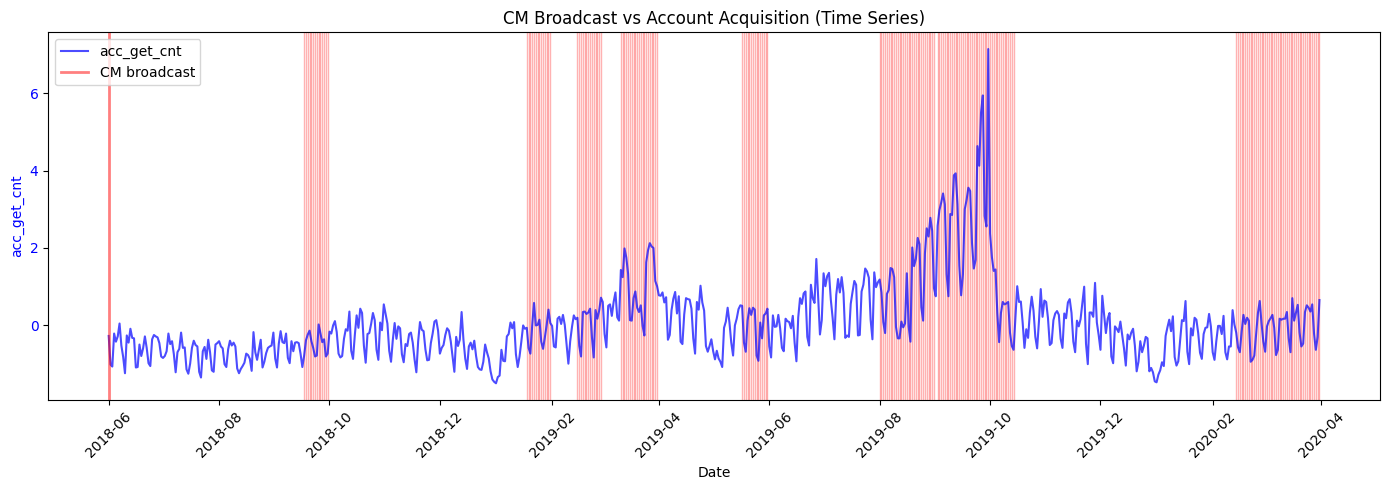

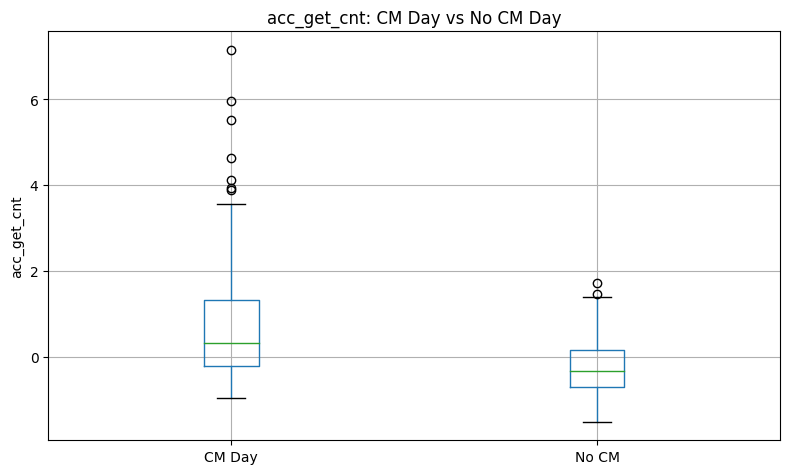

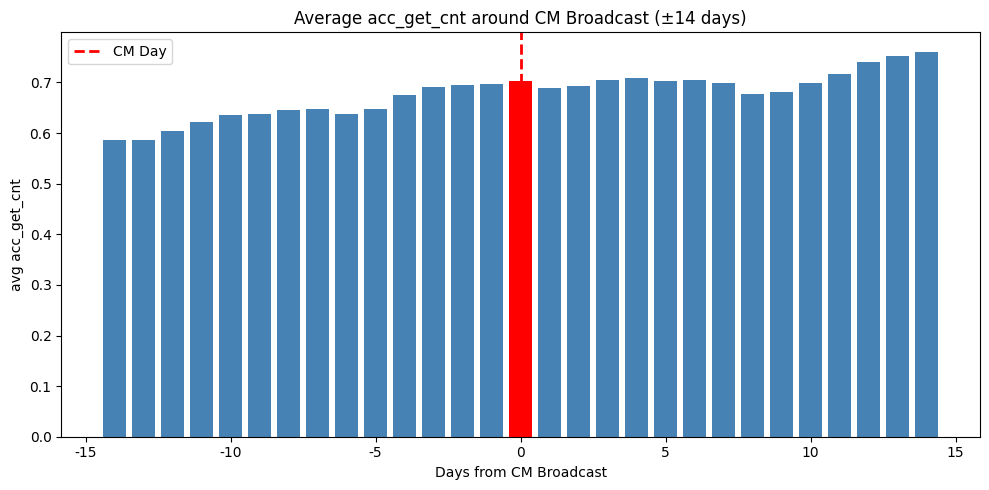

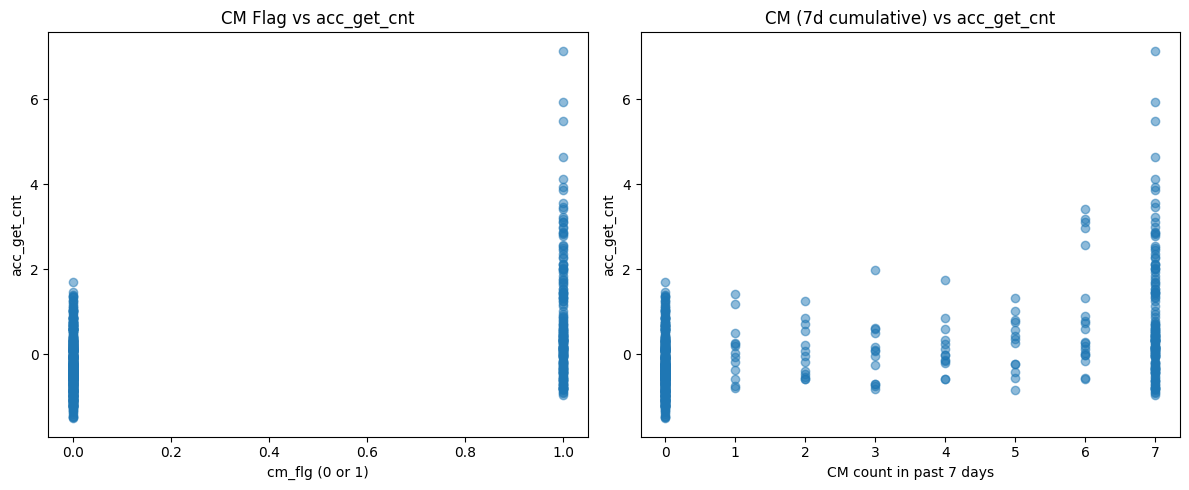


=== CM Day vs No CM Day: acc_get_cnt Stats ===
          count      mean       std       min       25%       50%       75%  \
cm_label                                                                      
CM Day    199.0  0.702629  1.366166 -0.951414 -0.208345  0.311802  1.333521   
No CM     471.0 -0.247681  0.623601 -1.508715 -0.697532 -0.319806  0.150804   

               max  
cm_label            
CM Day    7.148030  
No CM     1.711248  

=== Correlation ===
cm_flg vs acc_get_cnt: 0.4315
cm_7d vs acc_get_cnt:  0.4520


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# データ読み込み
cm_data = pd.read_csv('../input/cm_data.csv')
acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
call_data = pd.read_csv('../input/regi_call_data_transform.csv')

# 日付型に変換
cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])

# マージ
df = call_data.merge(cm_data, on='cdr_date', how='left')
df = df.merge(acc_get, on='cdr_date', how='left')

# ========================================
# Plot 1: 時系列で比較（2軸）
# ========================================
fig, ax1 = plt.subplots(figsize=(14, 5))

# CM放送日を縦線で表示
cm_dates = df[df['cm_flg'] == 1]['cdr_date']
for d in cm_dates:
    ax1.axvline(x=d, color='red', alpha=0.3, linewidth=1)

# アカウント取得数
ax1.plot(df['cdr_date'], df['acc_get_cnt'], color='blue', alpha=0.7, label='acc_get_cnt')
ax1.set_xlabel('Date')
ax1.set_ylabel('acc_get_cnt', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 凡例用のダミー
ax1.axvline(x=df['cdr_date'].min(), color='red', alpha=0.5, linewidth=2, label='CM broadcast')

ax1.legend(loc='upper left')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.title('CM Broadcast vs Account Acquisition (Time Series)')
plt.tight_layout()
plt.show()

# ========================================
# Plot 2: CM前後のacc_get_cnt比較（箱ひげ図）
# ========================================
fig, ax = plt.subplots(figsize=(8, 5))

# CM放送日とそれ以外で分類
df['cm_label'] = df['cm_flg'].map({0: 'No CM', 1: 'CM Day'})
df.boxplot(column='acc_get_cnt', by='cm_label', ax=ax)
plt.suptitle('')
plt.title('acc_get_cnt: CM Day vs No CM Day')
plt.xlabel('')
plt.ylabel('acc_get_cnt')
plt.tight_layout()
plt.show()

# ========================================
# Plot 3: CM放送後のacc_get_cnt推移（イベントスタディ風）
# ========================================
# CM放送日を基準に前後N日のacc_get_cntを集計
window = 14  # CM前後14日

cm_indices = df[df['cm_flg'] == 1].index.tolist()
effects = []

for idx in cm_indices:
    for offset in range(-window, window + 1):
        target_idx = idx + offset
        if 0 <= target_idx < len(df):
            effects.append({
                'offset': offset,
                'acc_get_cnt': df.loc[target_idx, 'acc_get_cnt']
            })

effects_df = pd.DataFrame(effects)
avg_effect = effects_df.groupby('offset')['acc_get_cnt'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(avg_effect.index, avg_effect.values, color=['red' if x == 0 else 'steelblue' for x in avg_effect.index])
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='CM Day')
ax.set_xlabel('Days from CM Broadcast')
ax.set_ylabel('avg acc_get_cnt')
ax.set_title(f'Average acc_get_cnt around CM Broadcast (±{window} days)')
ax.legend()
plt.tight_layout()
plt.show()

# ========================================
# Plot 4: 相関散布図
# ========================================
# CM放送の累積効果（過去7日間のCM回数）
df['cm_7d'] = df['cm_flg'].rolling(window=7, min_periods=1).sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 当日CM vs acc_get_cnt
axes[0].scatter(df['cm_flg'], df['acc_get_cnt'], alpha=0.5)
axes[0].set_xlabel('cm_flg (0 or 1)')
axes[0].set_ylabel('acc_get_cnt')
axes[0].set_title('CM Flag vs acc_get_cnt')

# 過去7日CM回数 vs acc_get_cnt
axes[1].scatter(df['cm_7d'], df['acc_get_cnt'], alpha=0.5)
axes[1].set_xlabel('CM count in past 7 days')
axes[1].set_ylabel('acc_get_cnt')
axes[1].set_title('CM (7d cumulative) vs acc_get_cnt')

plt.tight_layout()
plt.show()

# ========================================
# 統計サマリ
# ========================================
print("\n=== CM Day vs No CM Day: acc_get_cnt Stats ===")
print(df.groupby('cm_label')['acc_get_cnt'].describe())

print("\n=== Correlation ===")
print(f"cm_flg vs acc_get_cnt: {df['cm_flg'].corr(df['acc_get_cnt']):.4f}")
print(f"cm_7d vs acc_get_cnt:  {df['cm_7d'].corr(df['acc_get_cnt']):.4f}")


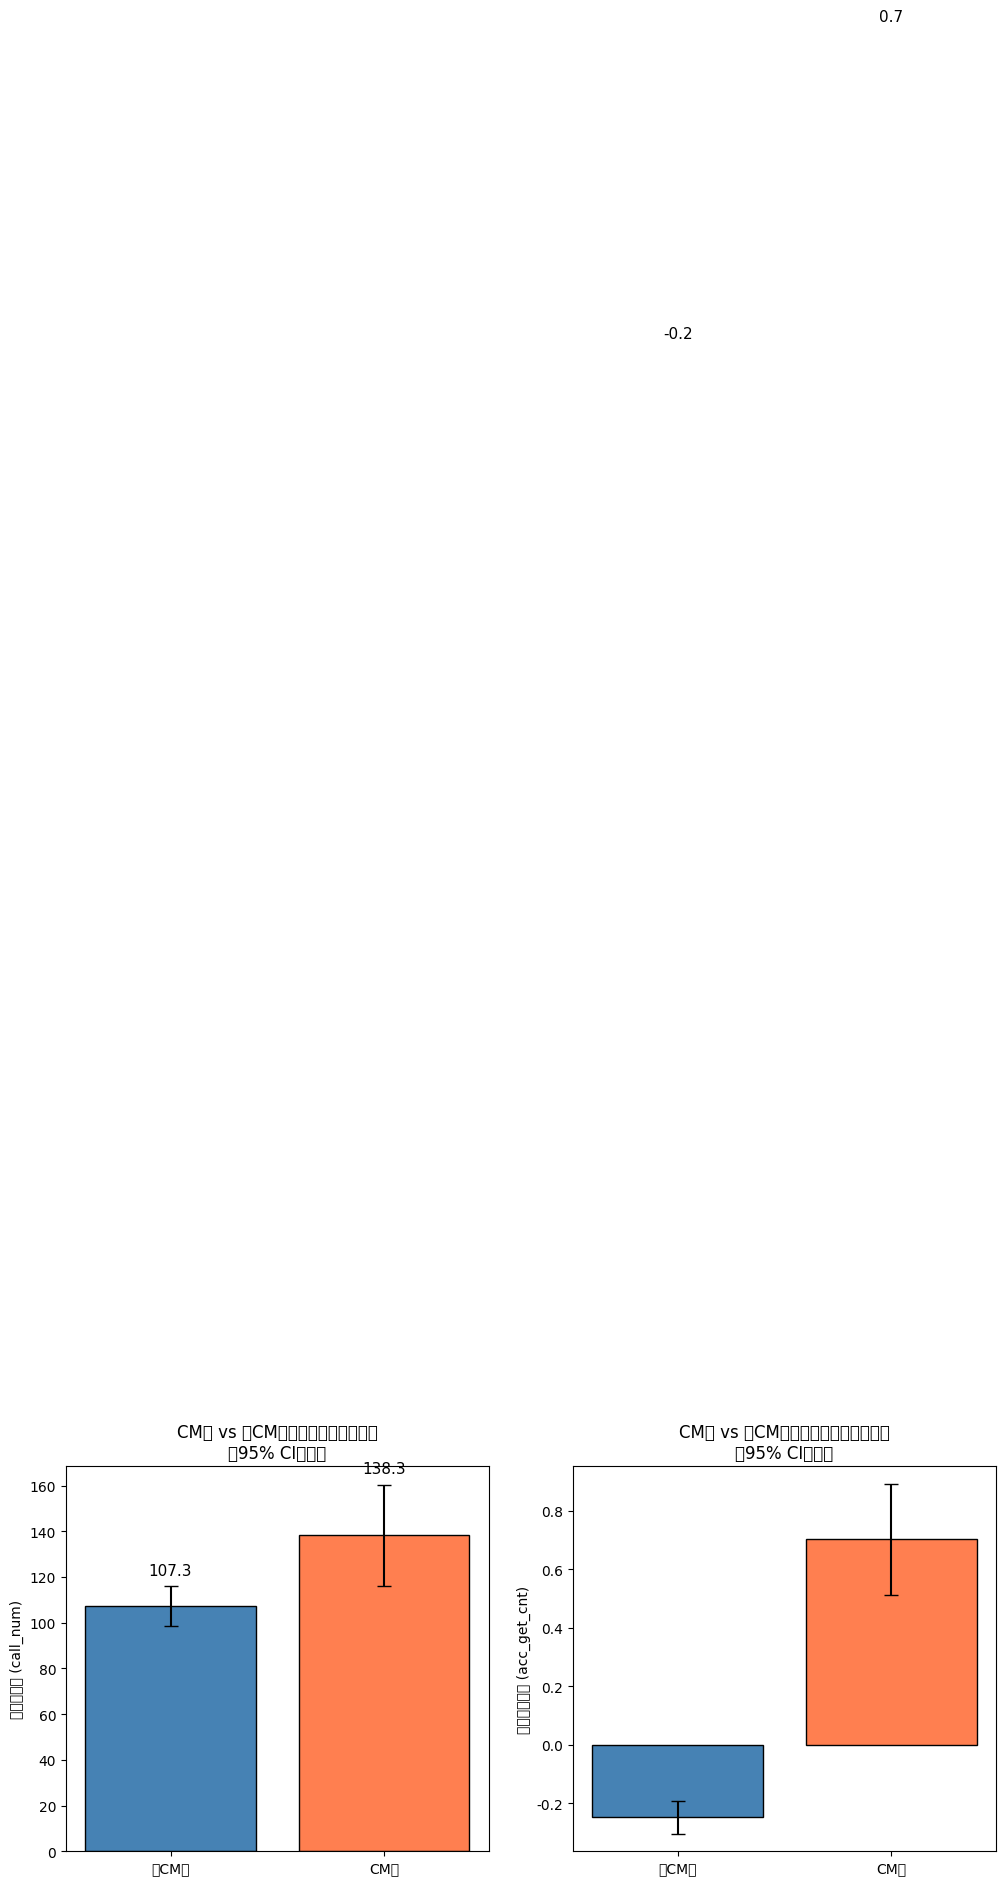


=== CM日 vs 非CM日：統計サマリ ===

【入電数 (call_num)】
        count        mean         std  min  25%    50%    75%    max
cm_flg                                                              
0       471.0  107.278132   97.265447  0.0  0.0  124.0  160.5  595.0
1       199.0  138.276382  159.553097  0.0  0.0  117.0  169.0  757.0

【アカ獲数 (acc_get_cnt)】
        count      mean       std       min       25%       50%       75%  \
cm_flg                                                                      
0       471.0 -0.247681  0.623601 -1.508715 -0.697532 -0.319806  0.150804   
1       199.0  0.702629  1.366166 -0.951414 -0.208345  0.311802  1.333521   

             max  
cm_flg            
0       1.711248  
1       7.148030  


In [ ]:
# ===========================================
# 1. CM日 vs 非CM日：入電・アカ獲の平均比較（CI付き）
# ===========================================
# 狙い：CMは「需要を作る」一方で「問い合わせも増えうる」→事前準備の必要性

import numpy as np
import matplotlib.pyplot as plt

def mean_ci_by_flag(df, y, flag="cm_flg"):
    """フラグ別の平均と95%信頼区間を計算"""
    g = df.groupby(flag)[y].agg(["mean", "count", "std"])
    ci = 1.96 * (g["std"] / np.sqrt(g["count"]))
    return g["mean"], ci

# 信頼区間付き平均を計算
call_mean, call_ci = mean_ci_by_flag(df_raw, "call_num", "cm_flg")
acc_mean, acc_ci = mean_ci_by_flag(df_raw, "acc_get_cnt", "cm_flg")

# プロット
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 入電数
labels = ["非CM日", "CM日"]
x = [0, 1]
axes[0].bar(x, call_mean.values, yerr=call_ci.values, capsize=5, color=["steelblue", "coral"], edgecolor="black")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("平均入電数 (call_num)")
axes[0].set_title("CM日 vs 非CM日：入電数の平均比較\n（95% CI付き）")
for i, (m, c) in enumerate(zip(call_mean.values, call_ci.values)):
    axes[0].text(i, m + c + 5, f"{m:.1f}", ha="center", fontsize=11)

# アカウント取得数
axes[1].bar(x, acc_mean.values, yerr=acc_ci.values, capsize=5, color=["steelblue", "coral"], edgecolor="black")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("平均アカ獲数 (acc_get_cnt)")
axes[1].set_title("CM日 vs 非CM日：アカ獲数の平均比較\n（95% CI付き）")
for i, (m, c) in enumerate(zip(acc_mean.values, acc_ci.values)):
    axes[1].text(i, m + c + 5, f"{m:.1f}", ha="center", fontsize=11)

plt.tight_layout()
plt.show()

# 統計サマリ
print("\n=== CM日 vs 非CM日：統計サマリ ===")
print("\n【入電数 (call_num)】")
print(df_raw.groupby("cm_flg")["call_num"].describe())
print("\n【アカ獲数 (acc_get_cnt)】")
print(df_raw.groupby("cm_flg")["acc_get_cnt"].describe())

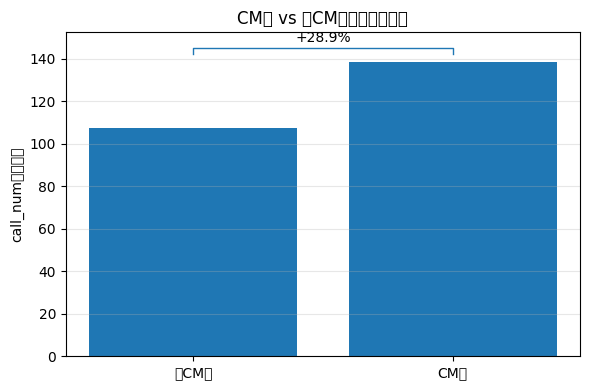

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 0/1の平均を計算
m0 = df.loc[df["cm_flg"]==0, "call_num"].mean()
m1 = df.loc[df["cm_flg"]==1, "call_num"].mean()
pct = (m1/m0 - 1) * 100

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(["非CM日", "CM日"], [m0, m1], yerr=None, capsize=6)

ax.set_ylabel("call_num（平均）")
ax.set_title("CM日 vs 非CM日：平均入電数")

# 注釈（差分%）
y = max(m0, m1) * 1.05
ax.plot([0, 0, 1, 1], [y*0.98, y, y, y*0.98], linewidth=1)
ax.text(0.5, y*1.01, f"+{pct:.1f}%", ha="center", va="bottom")

ax.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()


３割違うっていえる

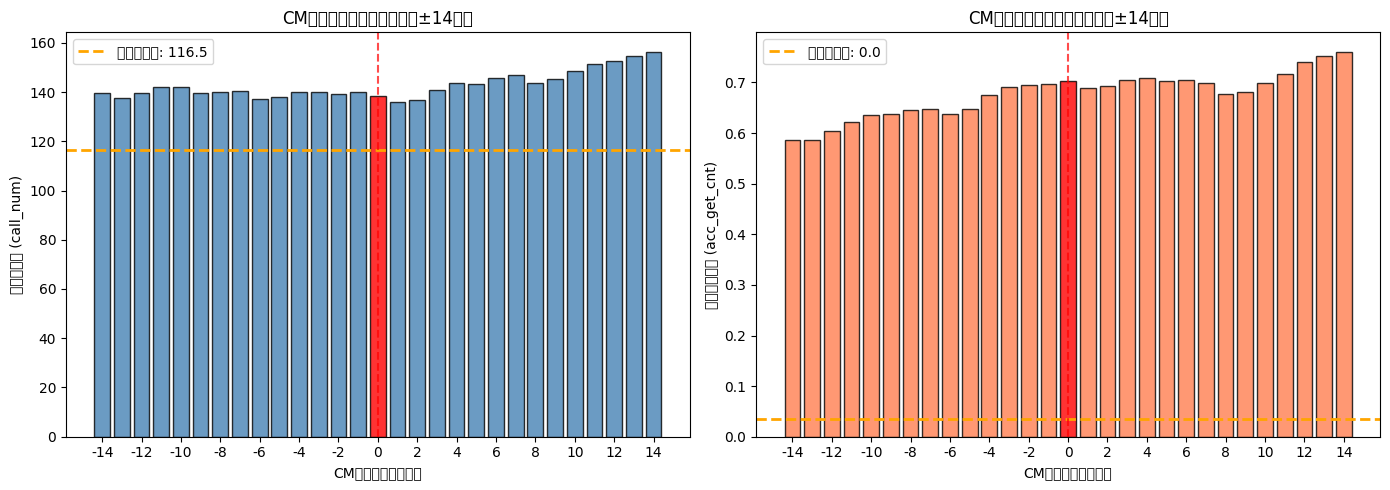


=== CM前後のピーク分析 ===

【入電数】ピーク日: CM日+14日 (平均: 156.4)
【アカ獲】ピーク日: CM日+14日 (平均: 0.8)


In [ ]:
# ===========================================
# 2. CMのイベントスタディ（前後±14日）
# ===========================================
# 狙い：CMは当日だけじゃなく前後に波及する → "繁忙モード"の期間設計

import numpy as np
import matplotlib.pyplot as plt

window = 14  # CM前後14日

# CM放送日のインデックスを取得
cm_indices = df_raw[df_raw["cm_flg"] == 1].index.tolist()

# CM日を基準にした前後のデータを収集
effects_call = []
effects_acc = []

for idx in cm_indices:
    for offset in range(-window, window + 1):
        target_idx = idx + offset
        if 0 <= target_idx < len(df_raw):
            effects_call.append({
                "offset": offset,
                "call_num": df_raw.loc[target_idx, "call_num"]
            })
            effects_acc.append({
                "offset": offset,
                "acc_get_cnt": df_raw.loc[target_idx, "acc_get_cnt"]
            })

effects_call_df = pd.DataFrame(effects_call)
effects_acc_df = pd.DataFrame(effects_acc)

# オフセット別の平均を計算
avg_call = effects_call_df.groupby("offset")["call_num"].mean()
avg_acc = effects_acc_df.groupby("offset")["acc_get_cnt"].mean()

# ベースライン（全期間平均）
baseline_call = df_raw["call_num"].mean()
baseline_acc = df_raw["acc_get_cnt"].mean()

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 入電数
colors_call = ["red" if x == 0 else "steelblue" for x in avg_call.index]
axes[0].bar(avg_call.index, avg_call.values, color=colors_call, edgecolor="black", alpha=0.8)
axes[0].axhline(y=baseline_call, color="orange", linestyle="--", linewidth=2, label=f"全期間平均: {baseline_call:.1f}")
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
axes[0].set_xlabel("CM放送日からの日数")
axes[0].set_ylabel("平均入電数 (call_num)")
axes[0].set_title(f"CM放送前後の入電数推移（±{window}日）")
axes[0].legend()
axes[0].set_xticks(range(-window, window + 1, 2))

# アカウント取得数
colors_acc = ["red" if x == 0 else "coral" for x in avg_acc.index]
axes[1].bar(avg_acc.index, avg_acc.values, color=colors_acc, edgecolor="black", alpha=0.8)
axes[1].axhline(y=baseline_acc, color="orange", linestyle="--", linewidth=2, label=f"全期間平均: {baseline_acc:.1f}")
axes[1].axvline(x=0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
axes[1].set_xlabel("CM放送日からの日数")
axes[1].set_ylabel("平均アカ獲数 (acc_get_cnt)")
axes[1].set_title(f"CM放送前後のアカ獲数推移（±{window}日）")
axes[1].legend()
axes[1].set_xticks(range(-window, window + 1, 2))

plt.tight_layout()
plt.show()

# ピーク日の特定
print("\n=== CM前後のピーク分析 ===")
print(f"\n【入電数】ピーク日: CM日+{avg_call.idxmax()}日 (平均: {avg_call.max():.1f})")
print(f"【アカ獲】ピーク日: CM日+{avg_acc.idxmax()}日 (平均: {avg_acc.max():.1f})")


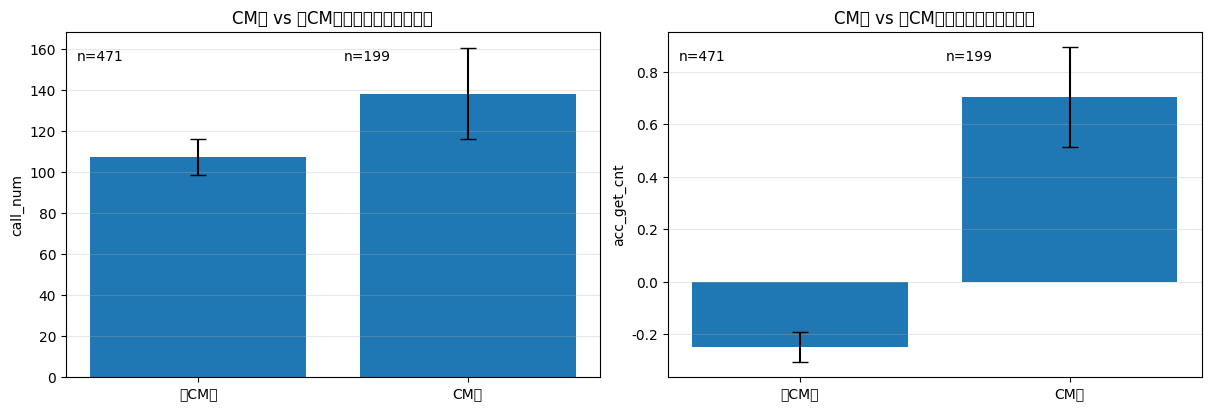

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df2 = df.copy()
if "is_open_day" in df2.columns:
    df2 = df2[df2["is_open_day"] == 1].copy()

def mean_ci(x):
    x = x.dropna()
    m = x.mean()
    se = x.std(ddof=1) / np.sqrt(len(x))
    ci = 1.96 * se
    return m, ci, len(x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for ax, y, title in [
    (axes[0], "call_num", "CM日 vs 非CM日：入電数（営業日）"),
    (axes[1], "acc_get_cnt", "CM日 vs 非CM日：アカ獲（営業日）"),
]:
    m0, ci0, n0 = mean_ci(df2.loc[df2["cm_flg"]==0, y])
    m1, ci1, n1 = mean_ci(df2.loc[df2["cm_flg"]==1, y])

    ax.bar(["非CM日", "CM日"], [m0, m1], yerr=[ci0, ci1], capsize=6)
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.grid(alpha=0.3, axis="y")
    ax.text(0.02, 0.95, f"n={n0}", transform=ax.transAxes, va="top")
    ax.text(0.52, 0.95, f"n={n1}", transform=ax.transAxes, va="top")

plt.show()


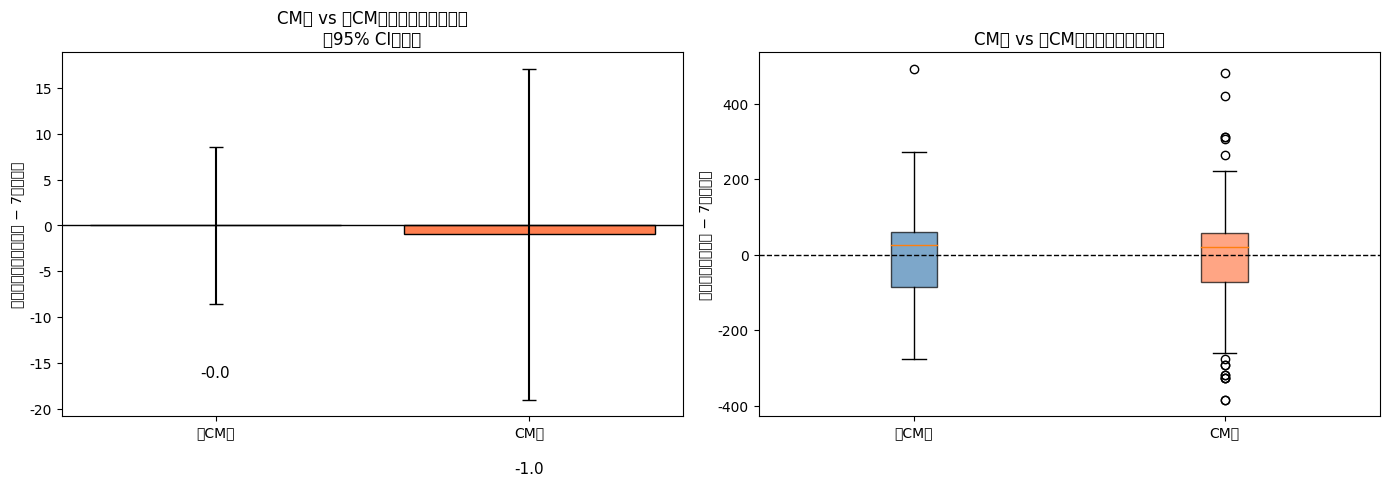


=== 過剰入電（excess_calls）の統計サマリ ===
        count      mean         std         min        25%        50%  \
cm_flg                                                                  
0       470.0 -0.014519   94.612396 -277.714286 -85.571429  24.857143   
1       199.0 -0.982771  129.899882 -384.571429 -73.714286  21.428571   

              75%         max  
cm_flg                         
0       58.821429  492.428571  
1       56.642857  481.285714  

【t検定】t値: 0.108, p値: 0.9143
→ CM日と非CM日で過剰入電に統計的有意差なし (p >= 0.05)


In [ ]:
# ===========================================
# 3. "過剰入電" = call_num − 平常（7日平均）
# ===========================================
# 狙い：「単純に季節で多い日」ではなくCM由来っぽい上振れを見せる

import numpy as np
import matplotlib.pyplot as plt

# 7日移動平均（ベースライン）を計算
df_raw["roll7"] = df_raw["call_num"].shift(1).rolling(7, min_periods=1).mean()

# 過剰入電（残差）= 実績 - ベースライン
df_raw["excess_calls"] = df_raw["call_num"] - df_raw["roll7"]

# CM日 vs 非CM日で過剰入電の統計
excess_by_cm = df_raw.groupby("cm_flg")["excess_calls"].agg(["mean", "count", "std"])
excess_ci = 1.96 * (excess_by_cm["std"] / np.sqrt(excess_by_cm["count"]))

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左：棒グラフ（平均 + CI）
labels = ["非CM日", "CM日"]
x = [0, 1]
colors = ["steelblue", "coral"]
axes[0].bar(x, excess_by_cm["mean"].values, yerr=excess_ci.values, 
            capsize=5, color=colors, edgecolor="black")
axes[0].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("平均過剰入電数（実績 − 7日平均）")
axes[0].set_title("CM日 vs 非CM日：過剰入電の比較\n（95% CI付き）")
for i, (m, c) in enumerate(zip(excess_by_cm["mean"].values, excess_ci.values)):
    offset = c + 2 if m >= 0 else -c - 8
    axes[0].text(i, m + offset, f"{m:.1f}", ha="center", fontsize=11)

# 右：箱ひげ図（分布の比較）
df_raw["cm_label"] = df_raw["cm_flg"].map({0: "非CM日", 1: "CM日"})
bp = axes[1].boxplot(
    [df_raw[df_raw["cm_flg"] == 0]["excess_calls"].dropna(),
     df_raw[df_raw["cm_flg"] == 1]["excess_calls"].dropna()],
    labels=labels, patch_artist=True
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].set_ylabel("過剰入電数（実績 − 7日平均）")
axes[1].set_title("CM日 vs 非CM日：過剰入電の分布")

plt.tight_layout()
plt.show()

# 統計サマリ
print("\n=== 過剰入電（excess_calls）の統計サマリ ===")
print(df_raw.groupby("cm_flg")["excess_calls"].describe())

# 有意差の簡易チェック
from scipy import stats
non_cm = df_raw[df_raw["cm_flg"] == 0]["excess_calls"].dropna()
cm = df_raw[df_raw["cm_flg"] == 1]["excess_calls"].dropna()
t_stat, p_val = stats.ttest_ind(non_cm, cm)
print(f"\n【t検定】t値: {t_stat:.3f}, p値: {p_val:.4f}")
if p_val < 0.05:
    print("→ CM日と非CM日で過剰入電に統計的有意差あり (p < 0.05)")
else:
    print("→ CM日と非CM日で過剰入電に統計的有意差なし (p >= 0.05)")


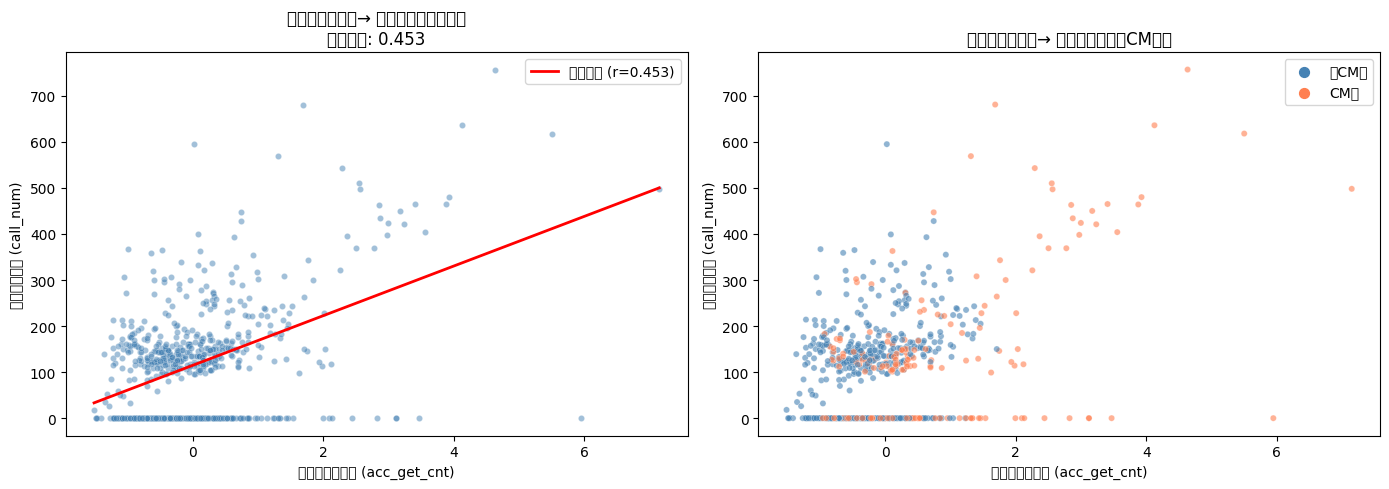


=== アカ獲 → 翌日入電 の関係分析 ===
相関係数: 0.4529
回帰係数: 53.9327 (アカ獲が1増えると翌日入電が53.93増える)
p値: 0.0000

【CM日別の相関係数】
  非CM日: 0.2982 (n=471)
  CM日: 0.5665 (n=198)


In [ ]:
# ===========================================
# 4. アカ獲 → 翌日入電：散布図（lag関係）
# ===========================================
# 狙い：オンボ/初期設定改善が「問い合わせ削減」に効く筋を作る
# 注意：因果は言わず「負荷の予兆」として使う

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 翌日の入電数を作成
tmp = df_raw.copy()
tmp["call_next"] = tmp["call_num"].shift(-1)

# 欠損を除去
tmp_clean = tmp[["acc_get_cnt", "call_next", "cm_flg"]].dropna()

# 相関係数を計算
corr = tmp_clean["acc_get_cnt"].corr(tmp_clean["call_next"])

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左：散布図（全体）
axes[0].scatter(tmp_clean["acc_get_cnt"], tmp_clean["call_next"], 
                s=20, alpha=0.5, c="steelblue", edgecolor="white", linewidth=0.3)

# 回帰直線
slope, intercept, r_value, p_value, std_err = stats.linregress(
    tmp_clean["acc_get_cnt"], tmp_clean["call_next"]
)
x_line = np.array([tmp_clean["acc_get_cnt"].min(), tmp_clean["acc_get_cnt"].max()])
y_line = slope * x_line + intercept
axes[0].plot(x_line, y_line, color="red", linewidth=2, 
             label=f"回帰直線 (r={r_value:.3f})")

axes[0].set_xlabel("当日のアカ獲数 (acc_get_cnt)")
axes[0].set_ylabel("翌日の入電数 (call_num)")
axes[0].set_title(f"アカ獲（当日）→ 入電（翌日）の関係\n相関係数: {corr:.3f}")
axes[0].legend()

# 右：CM日/非CM日で色分け
colors = tmp_clean["cm_flg"].map({0: "steelblue", 1: "coral"})
axes[1].scatter(tmp_clean["acc_get_cnt"], tmp_clean["call_next"], 
                s=20, alpha=0.6, c=colors, edgecolor="white", linewidth=0.3)

# 凡例用のダミー
axes[1].scatter([], [], c="steelblue", s=50, label="非CM日")
axes[1].scatter([], [], c="coral", s=50, label="CM日")

axes[1].set_xlabel("当日のアカ獲数 (acc_get_cnt)")
axes[1].set_ylabel("翌日の入電数 (call_num)")
axes[1].set_title("アカ獲（当日）→ 入電（翌日）：CM日別")
axes[1].legend()

plt.tight_layout()
plt.show()

# 統計サマリ
print("\n=== アカ獲 → 翌日入電 の関係分析 ===")
print(f"相関係数: {corr:.4f}")
print(f"回帰係数: {slope:.4f} (アカ獲が1増えると翌日入電が{slope:.2f}増える)")
print(f"p値: {p_value:.4f}")

# CM日別の相関
print("\n【CM日別の相関係数】")
for cm_val, label in [(0, "非CM日"), (1, "CM日")]:
    subset = tmp_clean[tmp_clean["cm_flg"] == cm_val]
    if len(subset) > 10:
        c = subset["acc_get_cnt"].corr(subset["call_next"])
        print(f"  {label}: {c:.4f} (n={len(subset)})")


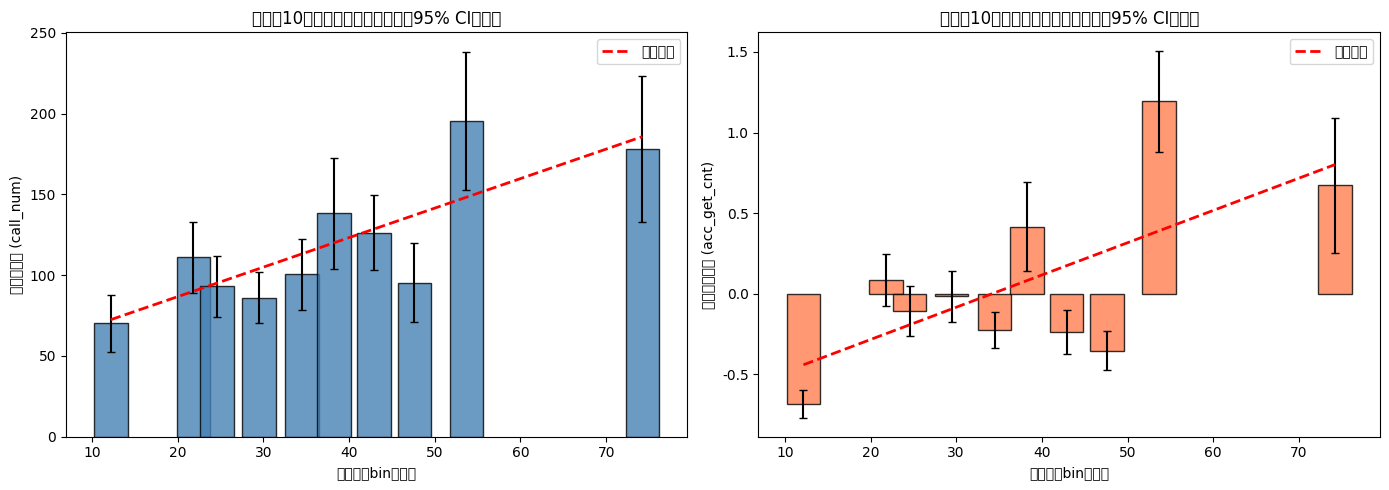


=== 検索量と入電/アカ獲の相関 ===
search_cnt vs call_num:    0.2721
search_cnt vs acc_get_cnt: 0.3809

=== 検索量10分位別サマリ ===
               検索量(平均)  入電数(平均)  アカ獲(平均)  サンプル数
search_decile                                  
0                 12.2     70.1     -0.7     93
1                 21.8    111.0      0.1     66
2                 24.6     93.0     -0.1     49
3                 29.5     86.1     -0.0     77
4                 34.5    100.5     -0.2     84
5                 38.2    138.2      0.4     56
6                 42.9    126.2     -0.2     63
7                 47.6     95.4     -0.4     56
8                 53.7    195.6      1.2     63
9                 74.2    178.0      0.7     63


In [ ]:
# ===========================================
# 5. 検索量（search_cnt）を10分位に切って分析
# ===========================================
# 狙い：検索増は需要の前兆 → 先回りの運用トリガーになる

import numpy as np
import matplotlib.pyplot as plt

# 検索量を10分位（decile）に分割
df_raw["search_decile"] = pd.qcut(df_raw["search_cnt"], q=10, labels=False, duplicates="drop")

# 分位別の統計量を計算
def calc_stats_by_group(df, group_col, value_col):
    """グループ別の平均・CI・サンプル数を計算"""
    stats = df.groupby(group_col)[value_col].agg(["mean", "count", "std"])
    stats["ci"] = 1.96 * (stats["std"] / np.sqrt(stats["count"]))
    stats["bin_mean"] = df.groupby(group_col)["search_cnt"].mean()  # bin内の検索量平均
    return stats

call_stats = calc_stats_by_group(df_raw, "search_decile", "call_num")
acc_stats = calc_stats_by_group(df_raw, "search_decile", "acc_get_cnt")

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 入電数
axes[0].bar(call_stats["bin_mean"], call_stats["mean"], 
            width=call_stats["bin_mean"].diff().median() * 0.8,
            yerr=call_stats["ci"], capsize=3, 
            color="steelblue", edgecolor="black", alpha=0.8)
axes[0].set_xlabel("検索量（bin平均）")
axes[0].set_ylabel("平均入電数 (call_num)")
axes[0].set_title("検索量10分位別：入電数の平均（95% CI付き）")

# トレンドライン
z = np.polyfit(call_stats["bin_mean"], call_stats["mean"], 1)
p = np.poly1d(z)
x_line = np.linspace(call_stats["bin_mean"].min(), call_stats["bin_mean"].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label="トレンド")
axes[0].legend()

# アカウント取得数
axes[1].bar(acc_stats["bin_mean"], acc_stats["mean"], 
            width=acc_stats["bin_mean"].diff().median() * 0.8,
            yerr=acc_stats["ci"], capsize=3, 
            color="coral", edgecolor="black", alpha=0.8)
axes[1].set_xlabel("検索量（bin平均）")
axes[1].set_ylabel("平均アカ獲数 (acc_get_cnt)")
axes[1].set_title("検索量10分位別：アカ獲数の平均（95% CI付き）")

# トレンドライン
z = np.polyfit(acc_stats["bin_mean"], acc_stats["mean"], 1)
p = np.poly1d(z)
axes[1].plot(x_line, p(x_line), "r--", linewidth=2, label="トレンド")
axes[1].legend()

plt.tight_layout()
plt.show()

# 相関係数
print("\n=== 検索量と入電/アカ獲の相関 ===")
print(f"search_cnt vs call_num:    {df_raw['search_cnt'].corr(df_raw['call_num']):.4f}")
print(f"search_cnt vs acc_get_cnt: {df_raw['search_cnt'].corr(df_raw['acc_get_cnt']):.4f}")

# 分位別サマリ
print("\n=== 検索量10分位別サマリ ===")
summary = pd.DataFrame({
    "検索量(平均)": call_stats["bin_mean"].round(1),
    "入電数(平均)": call_stats["mean"].round(1),
    "アカ獲(平均)": acc_stats["mean"].round(1),
    "サンプル数": call_stats["count"].astype(int)
})
print(summary)


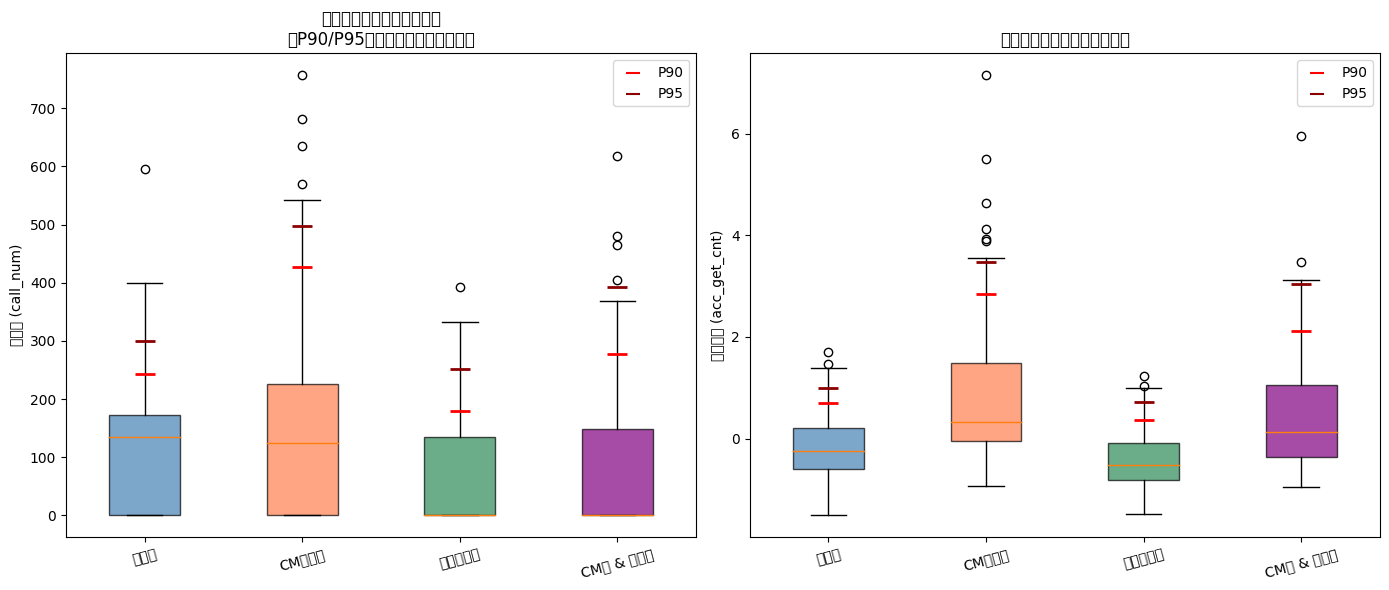


=== シナリオ別サマリ（入電数）===
            件数     平均    中央値    P75    P90    P95   最大
scenario                                              
通常日        318  125.3  135.0  172.0  243.3  300.0  595
CM日のみ      132  161.2  125.0  225.8  427.6  497.4  757
祝日前のみ      153   69.8    0.0  135.0  179.0  252.0  393
CM日 & 祝日前   67   93.0    0.0  148.0  276.8  393.5  618

=== シナリオ別サマリ（アカ獲数）===
            件数   平均  中央値  P75  P90  P95   最大
scenario                                    
通常日        318 -0.2 -0.2  0.2  0.7  1.0  1.7
CM日のみ      132  0.8  0.3  1.5  2.8  3.5  7.1
祝日前のみ      153 -0.4 -0.5 -0.1  0.4  0.7  1.2
CM日 & 祝日前   67  0.5  0.1  1.0  2.1  3.0  5.9


In [ ]:
# ===========================================
# 6. 祝日前のシナリオ別分布
# ===========================================
# 狙い：提案が「予測」ではなく体制最適化の実装に見える
# P90/P95を人員ラインに落とせるのでスライド映えします

import numpy as np
import matplotlib.pyplot as plt

# シナリオ分類を作成
def classify_scenario(row):
    cm = row["cm_flg"]
    holiday_before = row["day_before_holiday_flag"] if "day_before_holiday_flag" in row.index else 0
    
    if cm == 0 and holiday_before == 0:
        return "通常日"
    elif cm == 1 and holiday_before == 0:
        return "CM日のみ"
    elif cm == 0 and holiday_before == 1:
        return "祝日前のみ"
    else:
        return "CM日 & 祝日前"

df_raw["scenario"] = df_raw.apply(classify_scenario, axis=1)

# シナリオの順序を定義
scenario_order = ["通常日", "CM日のみ", "祝日前のみ", "CM日 & 祝日前"]
colors = ["steelblue", "coral", "seagreen", "purple"]

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 入電数の箱ひげ図
data_call = [df_raw[df_raw["scenario"] == s]["call_num"].dropna() for s in scenario_order]
bp1 = axes[0].boxplot(data_call, labels=scenario_order, patch_artist=True, showfliers=True)
for patch, color in zip(bp1["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# P90/P95ラインを追加
for i, s in enumerate(scenario_order):
    subset = df_raw[df_raw["scenario"] == s]["call_num"].dropna()
    if len(subset) > 0:
        p90 = subset.quantile(0.90)
        p95 = subset.quantile(0.95)
        axes[0].scatter(i + 1, p90, marker="_", s=200, color="red", zorder=5, linewidths=2)
        axes[0].scatter(i + 1, p95, marker="_", s=200, color="darkred", zorder=5, linewidths=2)

axes[0].scatter([], [], marker="_", s=100, color="red", label="P90")
axes[0].scatter([], [], marker="_", s=100, color="darkred", label="P95")
axes[0].set_ylabel("入電数 (call_num)")
axes[0].set_title("シナリオ別：入電数の分布\n（P90/P95を人員ラインの目安に）")
axes[0].legend(loc="upper right")
axes[0].tick_params(axis="x", rotation=15)

# アカウント取得数の箱ひげ図
data_acc = [df_raw[df_raw["scenario"] == s]["acc_get_cnt"].dropna() for s in scenario_order]
bp2 = axes[1].boxplot(data_acc, labels=scenario_order, patch_artist=True, showfliers=True)
for patch, color in zip(bp2["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# P90/P95ラインを追加
for i, s in enumerate(scenario_order):
    subset = df_raw[df_raw["scenario"] == s]["acc_get_cnt"].dropna()
    if len(subset) > 0:
        p90 = subset.quantile(0.90)
        p95 = subset.quantile(0.95)
        axes[1].scatter(i + 1, p90, marker="_", s=200, color="red", zorder=5, linewidths=2)
        axes[1].scatter(i + 1, p95, marker="_", s=200, color="darkred", zorder=5, linewidths=2)

axes[1].scatter([], [], marker="_", s=100, color="red", label="P90")
axes[1].scatter([], [], marker="_", s=100, color="darkred", label="P95")
axes[1].set_ylabel("アカ獲数 (acc_get_cnt)")
axes[1].set_title("シナリオ別：アカ獲数の分布")
axes[1].legend(loc="upper right")
axes[1].tick_params(axis="x", rotation=15)

plt.tight_layout()
plt.show()

# シナリオ別サマリ（人員計画用）
print("\n=== シナリオ別サマリ（入電数）===")
summary = df_raw.groupby("scenario")["call_num"].agg([
    ("件数", "count"),
    ("平均", "mean"),
    ("中央値", "median"),
    ("P75", lambda x: x.quantile(0.75)),
    ("P90", lambda x: x.quantile(0.90)),
    ("P95", lambda x: x.quantile(0.95)),
    ("最大", "max")
]).round(1)
summary = summary.reindex(scenario_order)
print(summary)

print("\n=== シナリオ別サマリ（アカ獲数）===")
summary_acc = df_raw.groupby("scenario")["acc_get_cnt"].agg([
    ("件数", "count"),
    ("平均", "mean"),
    ("中央値", "median"),
    ("P75", lambda x: x.quantile(0.75)),
    ("P90", lambda x: x.quantile(0.90)),
    ("P95", lambda x: x.quantile(0.95)),
    ("最大", "max")
]).round(1)
summary_acc = summary_acc.reindex(scenario_order)
print(summary_acc)


データに含まれる曜日: ['月', '火', '水', '木', '金', '土', '日']


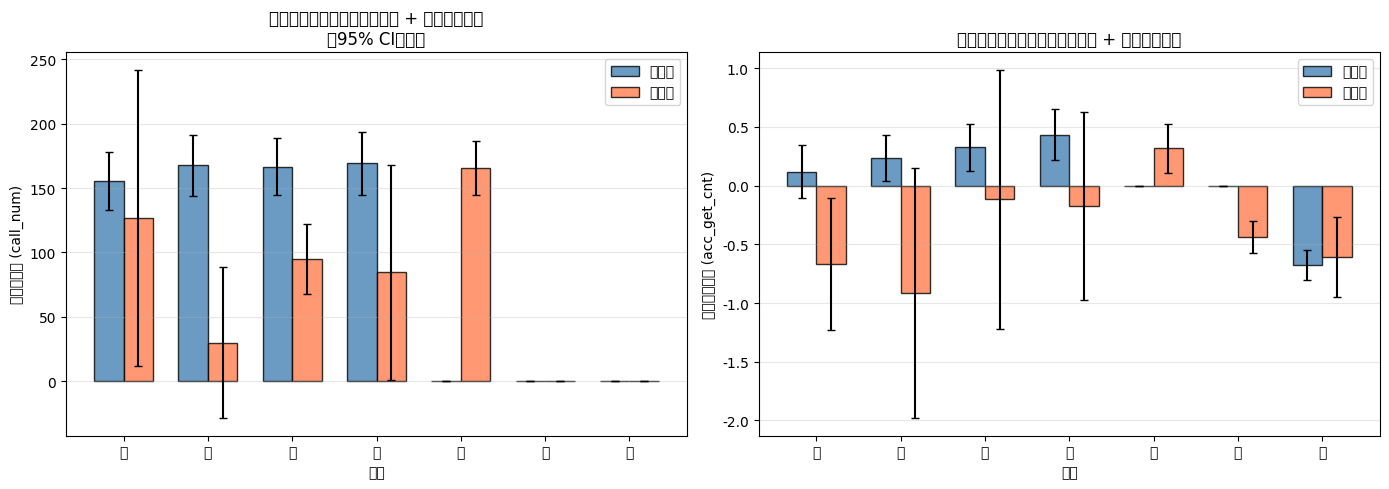


=== 曜日別サマリ（入電数）===
                             件数     平均    中央値    P90
dow day_before_holiday_flag                         
1   False                    92  155.4  158.0  299.5
    True                      4  127.0  119.5  239.0
2   False                    94  167.7  143.0  296.7
    True                      2   30.0   30.0   54.0
3   False                    93  166.6  142.0  301.2
    True                      2   95.0   95.0  106.2
4   False                    92  169.2  138.5  300.5
    True                      3   84.7  120.0  131.2
5   True                     96  165.7  147.0  301.5
6   True                     96    0.0    0.0    0.0
7   False                    79    0.0    0.0    0.0
    True                     17    0.0    0.0    0.0

=== 祝日前の上乗せ効果（曜日別）===
  月曜日: +-28.4 (+-18.3%)
  火曜日: +-137.7 (+-82.1%)
  水曜日: +-71.6 (+-43.0%)
  木曜日: +-84.5 (+-50.0%)
  日曜日: +0.0 (+nan%)


In [ ]:
# ===========================================
# 7. 曜日別のベース負荷 + 祝日前の上乗せ【修正版】
# ===========================================
# 狙い：固定ルール化（毎週のシフト）と、例外（祝日前）の両方を説明

import numpy as np
import matplotlib.pyplot as plt

# 曜日名のマッピング
dow_names = {1: "月", 2: "火", 3: "水", 4: "木", 5: "金", 6: "土", 7: "日"}
df_raw["dow_name_jp"] = df_raw["dow"].map(dow_names)

# 祝日前フラグがない場合は0で埋める
if "day_before_holiday_flag" not in df_raw.columns:
    df_raw["day_before_holiday_flag"] = 0

# 曜日別・祝日前別の平均を計算
dow_stats = df_raw.groupby(["dow", "day_before_holiday_flag"])["call_num"].agg(["mean", "count", "std"])
dow_stats["ci"] = 1.96 * (dow_stats["std"] / np.sqrt(dow_stats["count"]))
dow_stats = dow_stats.reset_index()

# 通常日と祝日前に分割
normal_stats = dow_stats[dow_stats["day_before_holiday_flag"] == 0].set_index("dow")
holiday_before_stats = dow_stats[dow_stats["day_before_holiday_flag"] == 1].set_index("dow")

# 実際に存在する曜日のみ取得
available_dows = sorted(df_raw["dow"].dropna().unique().astype(int))
print(f"データに含まれる曜日: {[dow_names.get(d, d) for d in available_dows]}")

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左：入電数
x = np.array(available_dows)
width = 0.35

# 通常日のデータ
normal_means = [normal_stats.loc[d, "mean"] if d in normal_stats.index else 0 for d in x]
normal_cis = [normal_stats.loc[d, "ci"] if d in normal_stats.index else 0 for d in x]

bars1 = axes[0].bar(x - width/2, normal_means, width, 
                     yerr=normal_cis, capsize=3,
                     label="通常日", color="steelblue", edgecolor="black", alpha=0.8)

# 祝日前のデータ（存在する曜日のみ）
holiday_means = [holiday_before_stats.loc[d, "mean"] if d in holiday_before_stats.index else 0 for d in x]
holiday_cis = [holiday_before_stats.loc[d, "ci"] if d in holiday_before_stats.index else 0 for d in x]
holiday_mask = [d in holiday_before_stats.index for d in x]

if any(holiday_mask):
    bars2 = axes[0].bar(x + width/2, holiday_means, width,
                         yerr=holiday_cis, capsize=3,
                         label="祝日前", color="coral", edgecolor="black", alpha=0.8)

axes[0].set_xlabel("曜日")
axes[0].set_ylabel("平均入電数 (call_num)")
axes[0].set_title("曜日別：入電数のベース負荷 + 祝日前上乗せ\n（95% CI付き）")
axes[0].set_xticks(x)
axes[0].set_xticklabels([dow_names.get(i, str(i)) for i in x])
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# 右：アカ獲数
dow_stats_acc = df_raw.groupby(["dow", "day_before_holiday_flag"])["acc_get_cnt"].agg(["mean", "count", "std"])
dow_stats_acc["ci"] = 1.96 * (dow_stats_acc["std"] / np.sqrt(dow_stats_acc["count"]))
dow_stats_acc = dow_stats_acc.reset_index()

normal_stats_acc = dow_stats_acc[dow_stats_acc["day_before_holiday_flag"] == 0].set_index("dow")
holiday_before_stats_acc = dow_stats_acc[dow_stats_acc["day_before_holiday_flag"] == 1].set_index("dow")

normal_means_acc = [normal_stats_acc.loc[d, "mean"] if d in normal_stats_acc.index else 0 for d in x]
normal_cis_acc = [normal_stats_acc.loc[d, "ci"] if d in normal_stats_acc.index else 0 for d in x]

bars3 = axes[1].bar(x - width/2, normal_means_acc, width,
                     yerr=normal_cis_acc, capsize=3,
                     label="通常日", color="steelblue", edgecolor="black", alpha=0.8)

holiday_means_acc = [holiday_before_stats_acc.loc[d, "mean"] if d in holiday_before_stats_acc.index else 0 for d in x]
holiday_cis_acc = [holiday_before_stats_acc.loc[d, "ci"] if d in holiday_before_stats_acc.index else 0 for d in x]

if any(d in holiday_before_stats_acc.index for d in x):
    bars4 = axes[1].bar(x + width/2, holiday_means_acc, width,
                         yerr=holiday_cis_acc, capsize=3,
                         label="祝日前", color="coral", edgecolor="black", alpha=0.8)

axes[1].set_xlabel("曜日")
axes[1].set_ylabel("平均アカ獲数 (acc_get_cnt)")
axes[1].set_title("曜日別：アカ獲数のベース負荷 + 祝日前上乗せ")
axes[1].set_xticks(x)
axes[1].set_xticklabels([dow_names.get(i, str(i)) for i in x])
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# 曜日別サマリ（シフト計画用）
print("\n=== 曜日別サマリ（入電数）===")
summary = df_raw.groupby(["dow", "day_before_holiday_flag"])["call_num"].agg([
    ("件数", "count"),
    ("平均", "mean"),
    ("中央値", "median"),
    ("P90", lambda x: x.quantile(0.90))
]).round(1)
print(summary)

# 祝日前の上乗せ効果
print("\n=== 祝日前の上乗せ効果（曜日別）===")
for dow in available_dows:
    normal = normal_stats.loc[dow, "mean"] if dow in normal_stats.index else np.nan
    holiday = holiday_before_stats.loc[dow, "mean"] if dow in holiday_before_stats.index else np.nan
    if not np.isnan(holiday) and not np.isnan(normal):
        uplift = holiday - normal
        uplift_pct = (uplift / normal) * 100
        print(f"  {dow_names.get(dow, dow)}曜日: +{uplift:.1f} (+{uplift_pct:.1f}%)")


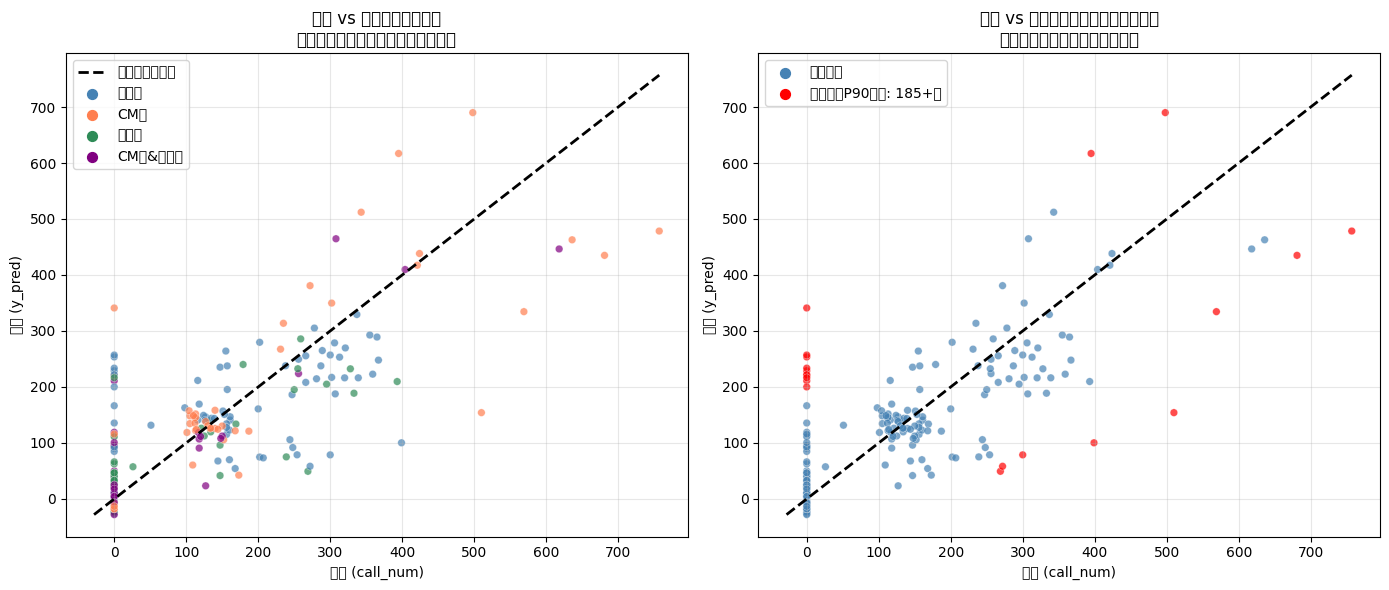


=== 予測モデル精度 ===
MAE  (平均絶対誤差): 69.15
RMSE (二乗平均平方根誤差): 101.19
R²   (決定係数): 0.5541

=== 大誤差日（上位10%）の特徴 ===
件数: 20 / 199 (10.1%)

CM日の割合: 45.0% (全体: 38.7%)
祝日前の割合: 15.0% (全体: 33.2%)


In [ ]:
# ===========================================
# 8. 予測モデルの使い道：予測 vs 実績
# ===========================================
# 狙い：「モデルを作って終わり」ではなく運用に使えるを見せる
# 図：散布図（y_true vs y_pred）で、CM日/祝日前をマーカー変える

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 簡易的な予測モデルを作成（デモ用）
# 特徴量: dow, cm_flg, day_before_holiday_flag, search_cnt, acc_get_cnt のラグ
df_model = df_raw.copy()

# ラグ特徴量を追加
df_model["call_lag1"] = df_model["call_num"].shift(1)
df_model["call_lag7"] = df_model["call_num"].shift(7)
df_model["acc_lag1"] = df_model["acc_get_cnt"].shift(1)

# 特徴量リスト
feature_cols = ["dow", "cm_flg", "search_cnt", "call_lag1", "call_lag7", "acc_lag1"]
if "day_before_holiday_flag" in df_model.columns:
    feature_cols.append("day_before_holiday_flag")

# 欠損を除去
df_model = df_model.dropna(subset=feature_cols + ["call_num"])

# 学習データとテストデータに分割（時系列なので後半をテスト）
split_idx = int(len(df_model) * 0.7)
train = df_model.iloc[:split_idx]
test = df_model.iloc[split_idx:]

# モデル学習
X_train = train[feature_cols]
y_train = train["call_num"]
X_test = test[feature_cols]
y_test = test["call_num"]

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)
test = test.copy()
test["y_pred"] = y_pred
test["residual"] = test["call_num"] - test["y_pred"]
test["abs_error"] = np.abs(test["residual"])

# 誤差の閾値（P90）
error_threshold = test["abs_error"].quantile(0.90)

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左：予測 vs 実績（シナリオ別色分け）
def get_marker_color(row):
    cm = row["cm_flg"]
    hol = row.get("day_before_holiday_flag", 0)
    if cm == 1 and hol == 1:
        return "purple"
    elif cm == 1:
        return "coral"
    elif hol == 1:
        return "seagreen"
    else:
        return "steelblue"

colors = test.apply(get_marker_color, axis=1)

axes[0].scatter(test["call_num"], test["y_pred"], c=colors, s=30, alpha=0.7, edgecolor="white", linewidth=0.3)

# 対角線（完全予測ライン）
min_val = min(test["call_num"].min(), test["y_pred"].min())
max_val = max(test["call_num"].max(), test["y_pred"].max())
axes[0].plot([min_val, max_val], [min_val, max_val], "k--", linewidth=2, label="完全予測ライン")

# 凡例用ダミー
axes[0].scatter([], [], c="steelblue", s=50, label="通常日")
axes[0].scatter([], [], c="coral", s=50, label="CM日")
axes[0].scatter([], [], c="seagreen", s=50, label="祝日前")
axes[0].scatter([], [], c="purple", s=50, label="CM日&祝日前")

axes[0].set_xlabel("実績 (call_num)")
axes[0].set_ylabel("予測 (y_pred)")
axes[0].set_title("予測 vs 実績：シナリオ別\n（運用時の注意ポイントを可視化）")
axes[0].legend(loc="upper left")
axes[0].grid(alpha=0.3)

# 右：誤差が大きい日をハイライト
large_error = test["abs_error"] >= error_threshold
colors_error = np.where(large_error, "red", "steelblue")

axes[1].scatter(test["call_num"], test["y_pred"], c=colors_error, s=30, alpha=0.7, edgecolor="white", linewidth=0.3)
axes[1].plot([min_val, max_val], [min_val, max_val], "k--", linewidth=2)

axes[1].scatter([], [], c="steelblue", s=50, label="通常誤差")
axes[1].scatter([], [], c="red", s=50, label=f"大誤差（P90以上: {error_threshold:.0f}+）")

axes[1].set_xlabel("実績 (call_num)")
axes[1].set_ylabel("予測 (y_pred)")
axes[1].set_title("予測 vs 実績：大誤差日をハイライト\n（要注意日の事前検知に活用）")
axes[1].legend(loc="upper left")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# モデル精度サマリ
print("\n=== 予測モデル精度 ===")
print(f"MAE  (平均絶対誤差): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE (二乗平均平方根誤差): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²   (決定係数): {r2_score(y_test, y_pred):.4f}")

# 大誤差日の分析
print(f"\n=== 大誤差日（上位10%）の特徴 ===")
large_error_days = test[large_error]
print(f"件数: {len(large_error_days)} / {len(test)} ({len(large_error_days)/len(test)*100:.1f}%)")
print(f"\nCM日の割合: {large_error_days['cm_flg'].mean()*100:.1f}% (全体: {test['cm_flg'].mean()*100:.1f}%)")
if "day_before_holiday_flag" in large_error_days.columns:
    print(f"祝日前の割合: {large_error_days['day_before_holiday_flag'].mean()*100:.1f}% (全体: {test['day_before_holiday_flag'].mean()*100:.1f}%)")


【仮定】施策導入日: 2019-07-10
  - 施策前: 397日間
  - 施策後: 266日間


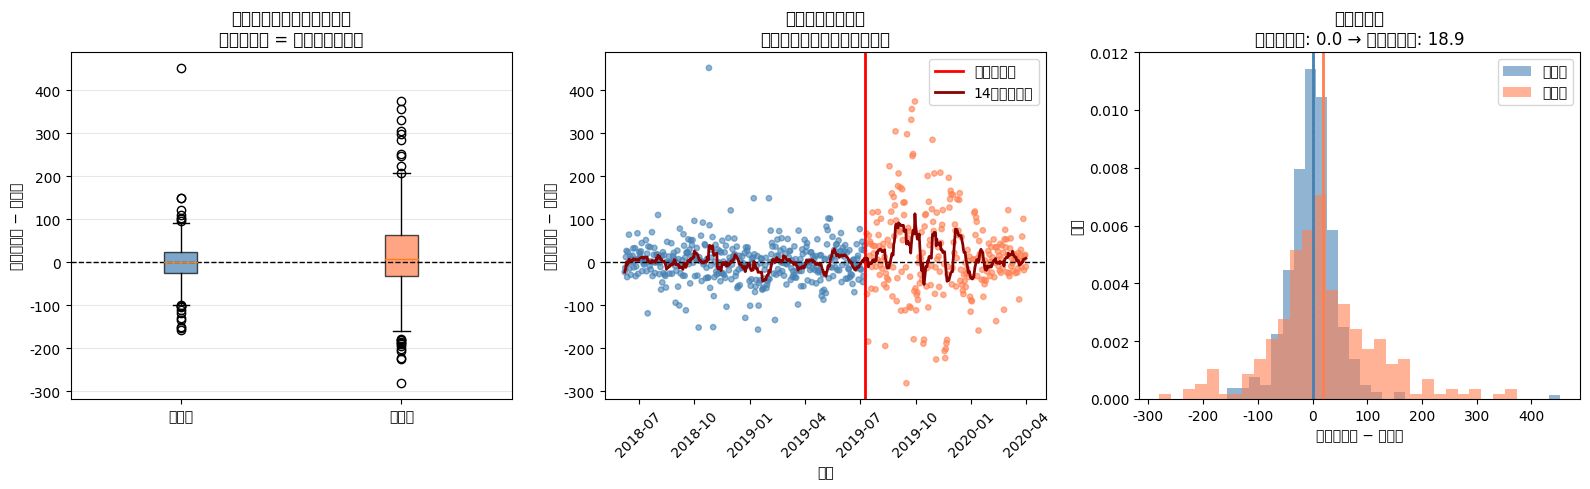


=== 施策効果検証サマリ ===
         件数     平均   中央値   標準偏差    P10     P90
period                                        
施策前     397   0.00  0.76  47.90 -48.71   46.23
施策後     266  18.91  8.26  98.43 -82.94  140.17

【効果推定】
  残差平均の変化: 0.00 → 18.91
  推定削減効果: -18.91 件/日
  → 施策後、予測より平均 18.9 件/日 多い（削減効果なし）

【t検定】t値: -3.291, p値: 0.0011
  → 施策前後で統計的有意差あり (p < 0.05)


In [ ]:
# ===========================================
# 9. 効果検証の型：残差の前後比較
# ===========================================
# 狙い：PoC→本番の検証設計が描ける（突っ込み耐性が高い）
# 図：施策期間の前後で residual の分布を比較（箱ひげ）

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# まずベースモデルを作成（施策効果を測るためのベースライン）
df_eval = df_raw.copy()

# ラグ特徴量
df_eval["call_lag1"] = df_eval["call_num"].shift(1)
df_eval["call_lag7"] = df_eval["call_num"].shift(7)
df_eval["acc_lag1"] = df_eval["acc_get_cnt"].shift(1)

# 特徴量
feature_cols = ["dow", "cm_flg", "search_cnt", "call_lag1", "call_lag7", "acc_lag1"]
if "day_before_holiday_flag" in df_eval.columns:
    feature_cols.append("day_before_holiday_flag")

# 欠損除去
df_eval = df_eval.dropna(subset=feature_cols + ["call_num"]).reset_index(drop=True)

# 施策導入日を仮定（例：データの60%地点を施策導入とする）
# 実際の運用では、施策導入日を明確に設定してください
policy_start_idx = int(len(df_eval) * 0.6)
policy_start_date = df_eval.loc[policy_start_idx, "cdr_date"]

print(f"【仮定】施策導入日: {policy_start_date.strftime('%Y-%m-%d')}")
print(f"  - 施策前: {len(df_eval[:policy_start_idx])}日間")
print(f"  - 施策後: {len(df_eval[policy_start_idx:])}日間")

# 施策前のデータでモデルを学習（施策効果を含まないベースライン）
train_data = df_eval.iloc[:policy_start_idx]
X_train = train_data[feature_cols]
y_train = train_data["call_num"]

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# 全期間で予測し、残差を計算
df_eval["y_pred"] = model.predict(df_eval[feature_cols])
df_eval["residual"] = df_eval["call_num"] - df_eval["y_pred"]

# 施策前後のフラグ
df_eval["period"] = np.where(df_eval.index < policy_start_idx, "施策前", "施策後")

# プロット
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左：残差の箱ひげ図（前後比較）
period_order = ["施策前", "施策後"]
colors = ["steelblue", "coral"]

data_box = [df_eval[df_eval["period"] == p]["residual"].dropna() for p in period_order]
bp = axes[0].boxplot(data_box, labels=period_order, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].set_ylabel("残差（実績 − 予測）")
axes[0].set_title("施策前後：残差の分布比較\n（負の残差 = 入電削減効果）")
axes[0].grid(axis="y", alpha=0.3)

# 中央：残差の時系列推移
axes[1].scatter(df_eval["cdr_date"], df_eval["residual"], 
                c=df_eval["period"].map({"施策前": "steelblue", "施策後": "coral"}),
                s=15, alpha=0.6)
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].axvline(x=policy_start_date, color="red", linestyle="-", linewidth=2, label="施策導入日")

# 移動平均を追加
df_eval["residual_ma14"] = df_eval["residual"].rolling(14, min_periods=1).mean()
axes[1].plot(df_eval["cdr_date"], df_eval["residual_ma14"], color="darkred", linewidth=2, label="14日移動平均")

axes[1].set_xlabel("日付")
axes[1].set_ylabel("残差（実績 − 予測）")
axes[1].set_title("残差の時系列推移\n（施策導入後の変化を確認）")
axes[1].legend()
axes[1].tick_params(axis="x", rotation=45)

# 右：残差のヒストグラム（前後比較）
axes[2].hist(df_eval[df_eval["period"] == "施策前"]["residual"], bins=30, alpha=0.6, 
             color="steelblue", label="施策前", density=True)
axes[2].hist(df_eval[df_eval["period"] == "施策後"]["residual"], bins=30, alpha=0.6, 
             color="coral", label="施策後", density=True)
axes[2].axvline(x=0, color="black", linestyle="--", linewidth=1)

# 平均値の垂直線
mean_before = df_eval[df_eval["period"] == "施策前"]["residual"].mean()
mean_after = df_eval[df_eval["period"] == "施策後"]["residual"].mean()
axes[2].axvline(x=mean_before, color="steelblue", linestyle="-", linewidth=2)
axes[2].axvline(x=mean_after, color="coral", linestyle="-", linewidth=2)

axes[2].set_xlabel("残差（実績 − 予測）")
axes[2].set_ylabel("密度")
axes[2].set_title(f"残差の分布\n施策前平均: {mean_before:.1f} → 施策後平均: {mean_after:.1f}")
axes[2].legend()

plt.tight_layout()
plt.show()

# 効果検証サマリ
print("\n=== 施策効果検証サマリ ===")
summary = df_eval.groupby("period")["residual"].agg([
    ("件数", "count"),
    ("平均", "mean"),
    ("中央値", "median"),
    ("標準偏差", "std"),
    ("P10", lambda x: x.quantile(0.10)),
    ("P90", lambda x: x.quantile(0.90))
]).round(2)
summary = summary.reindex(period_order)
print(summary)

# 効果量の推定
effect = mean_before - mean_after
print(f"\n【効果推定】")
print(f"  残差平均の変化: {mean_before:.2f} → {mean_after:.2f}")
print(f"  推定削減効果: {effect:.2f} 件/日")
if effect > 0:
    print(f"  → 施策後、予測より平均 {effect:.1f} 件/日 少ない（削減効果あり）")
else:
    print(f"  → 施策後、予測より平均 {-effect:.1f} 件/日 多い（削減効果なし）")

# 統計的有意性の簡易チェック
from scipy import stats
before = df_eval[df_eval["period"] == "施策前"]["residual"].dropna()
after = df_eval[df_eval["period"] == "施策後"]["residual"].dropna()
t_stat, p_val = stats.ttest_ind(before, after)
print(f"\n【t検定】t値: {t_stat:.3f}, p値: {p_val:.4f}")
if p_val < 0.05:
    print("  → 施策前後で統計的有意差あり (p < 0.05)")
else:
    print("  → 施策前後で統計的有意差なし (p >= 0.05)")


【仮定パラメータ】※実際の値に置き換えてください
  1件あたり対応時間: 8 分
  時給: 1,500 円
  月間営業日数: 20 日
  現状の日平均入電数: 116.5 件


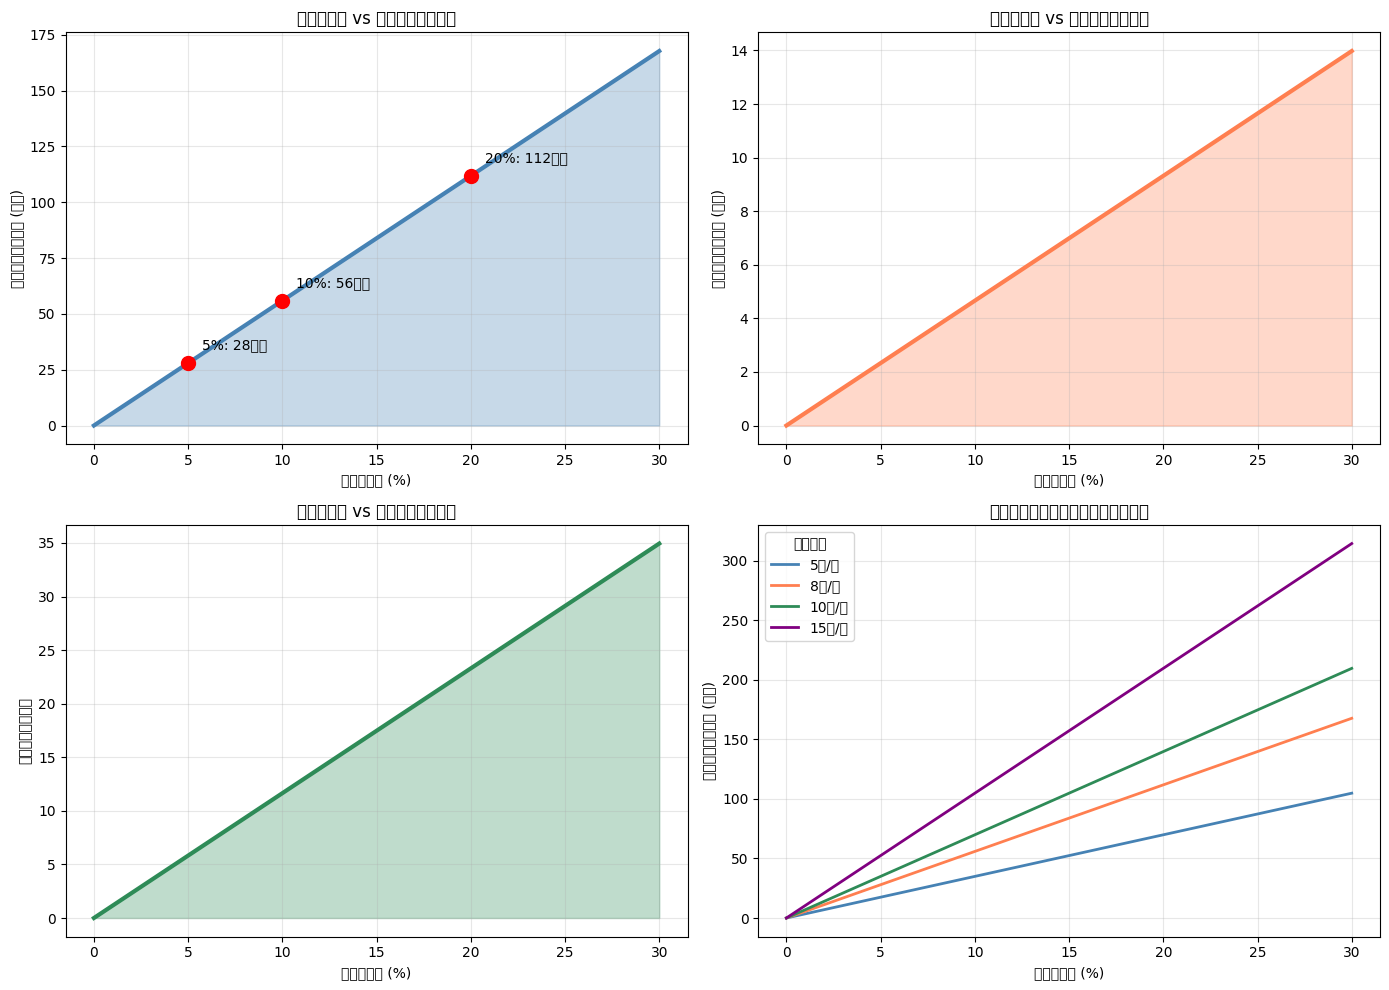


【コスト削減シミュレーション結果】
削減率 日削減件数 日削減時間   月間削減  年間削減
 5%  5.8件  0.8h  2.3万円  28万円
10% 11.6件  1.6h  4.7万円  56万円
15% 17.5件  2.3h  7.0万円  84万円
20% 23.3件  3.1h  9.3万円 112万円
25% 29.1件  3.9h 11.6万円 140万円
30% 34.9件  4.7h 14.0万円 168万円

【FTE（フルタイム換算）削減効果】
  10%削減時: 約 0.19 FTE相当 (1.6h/日)
  20%削減時: 約 0.39 FTE相当 (3.1h/日)

※ 上記は仮定値に基づく試算です。実際の効果は運用状況により異なります。


In [ ]:
# ===========================================
# 10. 事業効果を"円"にする図
# ===========================================
# 狙い：経営が意思決定しやすい
# 図：入電削減率を横軸、削減コスト（人件費換算）を縦軸の感度分析
# ※単価（1件あたり何分）などは仮定でOK。「仮定」と明記すれば安全。

import numpy as np
import matplotlib.pyplot as plt

# ===== 仮定パラメータ（実際の値に置き換えてください）=====
CALL_HANDLING_TIME_MIN = 8       # 1件あたりの対応時間（分）
HOURLY_WAGE = 1500               # 時給（円）
WORKING_DAYS_PER_MONTH = 20      # 月間営業日数

# 現状の入電数（日平均）
current_daily_calls = df_raw["call_num"].mean()
print("=" * 60)
print("【仮定パラメータ】※実際の値に置き換えてください")
print("=" * 60)
print(f"  1件あたり対応時間: {CALL_HANDLING_TIME_MIN} 分")
print(f"  時給: {HOURLY_WAGE:,} 円")
print(f"  月間営業日数: {WORKING_DAYS_PER_MONTH} 日")
print(f"  現状の日平均入電数: {current_daily_calls:.1f} 件")
print("=" * 60)

# 削減率のシナリオ
reduction_rates = np.arange(0, 0.31, 0.01)  # 0% ~ 30%

# コスト計算関数
def calc_cost_savings(daily_calls, reduction_rate, handling_time_min, hourly_wage, working_days):
    """入電削減によるコスト削減額を計算"""
    reduced_calls_per_day = daily_calls * reduction_rate
    saved_time_hours_per_day = (reduced_calls_per_day * handling_time_min) / 60
    daily_savings = saved_time_hours_per_day * hourly_wage
    monthly_savings = daily_savings * working_days
    annual_savings = monthly_savings * 12
    return {
        "reduced_calls_day": reduced_calls_per_day,
        "saved_hours_day": saved_time_hours_per_day,
        "daily_savings": daily_savings,
        "monthly_savings": monthly_savings,
        "annual_savings": annual_savings
    }

# 各削減率でのコスト削減を計算
results = []
for rate in reduction_rates:
    savings = calc_cost_savings(
        current_daily_calls, rate, 
        CALL_HANDLING_TIME_MIN, HOURLY_WAGE, WORKING_DAYS_PER_MONTH
    )
    savings["reduction_rate"] = rate
    results.append(savings)

results_df = pd.DataFrame(results)

# プロット
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 左上：年間コスト削減額
axes[0, 0].plot(results_df["reduction_rate"] * 100, results_df["annual_savings"] / 10000, 
                color="steelblue", linewidth=3)
axes[0, 0].fill_between(results_df["reduction_rate"] * 100, results_df["annual_savings"] / 10000, 
                         alpha=0.3, color="steelblue")
axes[0, 0].set_xlabel("入電削減率 (%)")
axes[0, 0].set_ylabel("年間コスト削減額 (万円)")
axes[0, 0].set_title("入電削減率 vs 年間コスト削減額")
axes[0, 0].grid(alpha=0.3)

# 重要ポイントをマーク
for target_rate in [0.05, 0.10, 0.20]:
    idx = np.argmin(np.abs(results_df["reduction_rate"] - target_rate))
    annual_save = results_df.loc[idx, "annual_savings"]
    axes[0, 0].scatter(target_rate * 100, annual_save / 10000, s=100, color="red", zorder=5)
    axes[0, 0].annotate(f"{target_rate*100:.0f}%: {annual_save/10000:.0f}万円", 
                        (target_rate * 100, annual_save / 10000),
                        textcoords="offset points", xytext=(10, 10), fontsize=10)

# 右上：月間コスト削減額
axes[0, 1].plot(results_df["reduction_rate"] * 100, results_df["monthly_savings"] / 10000, 
                color="coral", linewidth=3)
axes[0, 1].fill_between(results_df["reduction_rate"] * 100, results_df["monthly_savings"] / 10000, 
                         alpha=0.3, color="coral")
axes[0, 1].set_xlabel("入電削減率 (%)")
axes[0, 1].set_ylabel("月間コスト削減額 (万円)")
axes[0, 1].set_title("入電削減率 vs 月間コスト削減額")
axes[0, 1].grid(alpha=0.3)

# 左下：日あたり削減件数
axes[1, 0].plot(results_df["reduction_rate"] * 100, results_df["reduced_calls_day"], 
                color="seagreen", linewidth=3)
axes[1, 0].fill_between(results_df["reduction_rate"] * 100, results_df["reduced_calls_day"], 
                         alpha=0.3, color="seagreen")
axes[1, 0].set_xlabel("入電削減率 (%)")
axes[1, 0].set_ylabel("日あたり削減件数")
axes[1, 0].set_title("入電削減率 vs 日あたり削減件数")
axes[1, 0].grid(alpha=0.3)

# 右下：感度分析（対応時間別）
handling_times = [5, 8, 10, 15]  # 分
colors_sensitivity = ["steelblue", "coral", "seagreen", "purple"]

for ht, color in zip(handling_times, colors_sensitivity):
    annual_savings = []
    for rate in reduction_rates:
        savings = calc_cost_savings(current_daily_calls, rate, ht, HOURLY_WAGE, WORKING_DAYS_PER_MONTH)
        annual_savings.append(savings["annual_savings"])
    axes[1, 1].plot(reduction_rates * 100, np.array(annual_savings) / 10000, 
                    color=color, linewidth=2, label=f"{ht}分/件")

axes[1, 1].set_xlabel("入電削減率 (%)")
axes[1, 1].set_ylabel("年間コスト削減額 (万円)")
axes[1, 1].set_title("感度分析：対応時間別の年間削減額")
axes[1, 1].legend(title="対応時間")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# サマリテーブル
print("\n" + "=" * 60)
print("【コスト削減シミュレーション結果】")
print("=" * 60)
target_rates = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
summary_data = []
for rate in target_rates:
    savings = calc_cost_savings(
        current_daily_calls, rate, 
        CALL_HANDLING_TIME_MIN, HOURLY_WAGE, WORKING_DAYS_PER_MONTH
    )
    summary_data.append({
        "削減率": f"{rate*100:.0f}%",
        "日削減件数": f"{savings['reduced_calls_day']:.1f}件",
        "日削減時間": f"{savings['saved_hours_day']:.1f}h",
        "月間削減": f"{savings['monthly_savings']/10000:.1f}万円",
        "年間削減": f"{savings['annual_savings']/10000:.0f}万円"
    })

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))

# FTE換算
print("\n" + "=" * 60)
print("【FTE（フルタイム換算）削減効果】")
print("=" * 60)
WORKING_HOURS_PER_DAY = 8
for rate in [0.10, 0.20]:
    savings = calc_cost_savings(
        current_daily_calls, rate, 
        CALL_HANDLING_TIME_MIN, HOURLY_WAGE, WORKING_DAYS_PER_MONTH
    )
    fte = savings["saved_hours_day"] / WORKING_HOURS_PER_DAY
    print(f"  {rate*100:.0f}%削減時: 約 {fte:.2f} FTE相当 ({savings['saved_hours_day']:.1f}h/日)")

print("\n※ 上記は仮定値に基づく試算です。実際の効果は運用状況により異なります。")


分析対象の特徴量 (9個):
  1. call_num
  2. dow
  3. woy
  4. wom
  5. doy
  6. financial_year
  7. cm_flg
  8. acc_get_cnt
  9. search_cnt


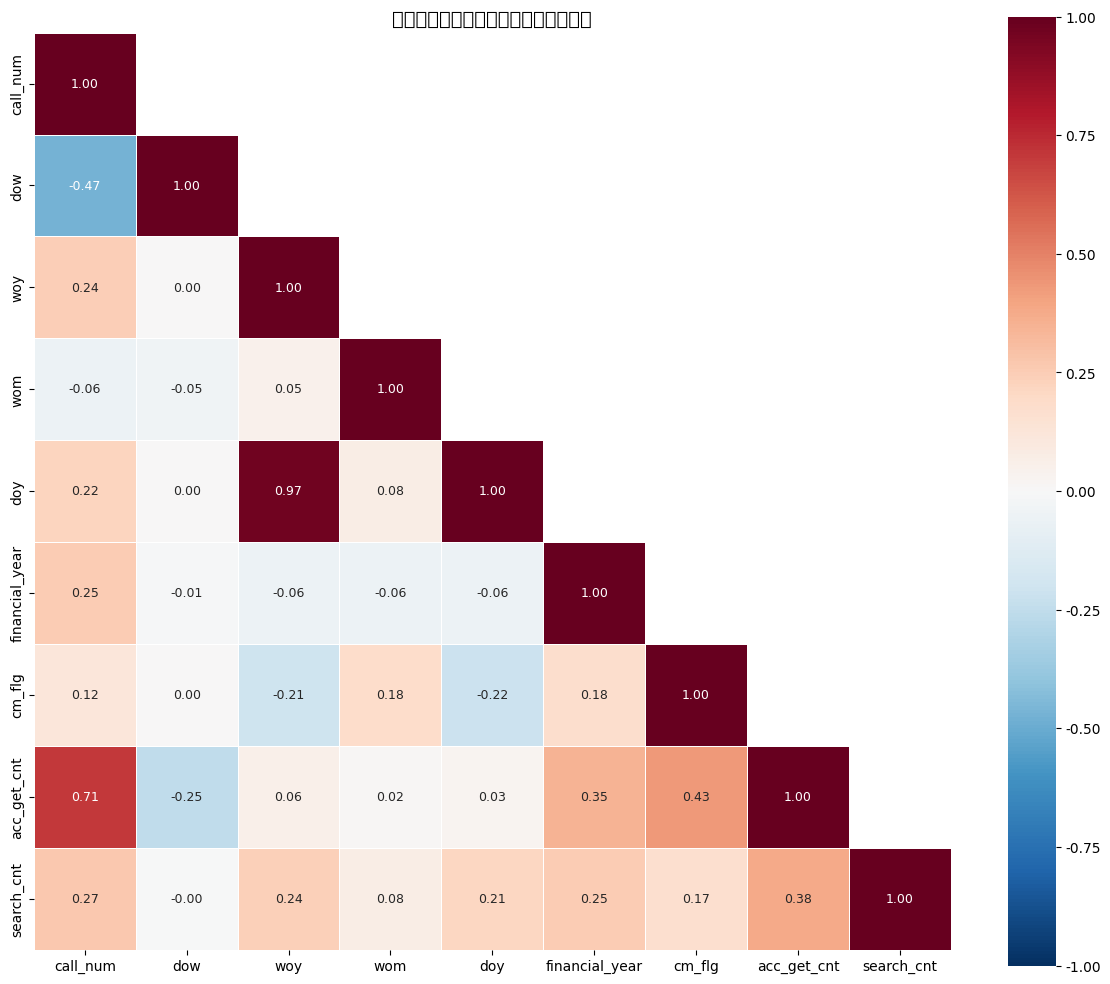

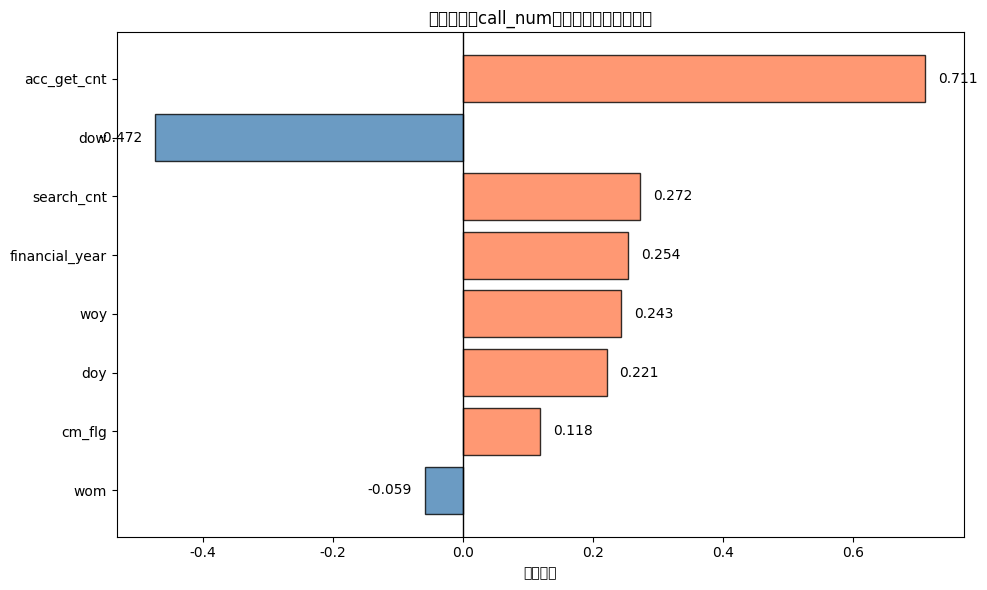


=== call_num との相関係数 ===
acc_get_cnt       0.7106
dow              -0.4725
search_cnt        0.2721
financial_year    0.2544
woy               0.2432
doy               0.2209
cm_flg            0.1182
wom              -0.0588

=== 強い相関を持つ特徴量ペア（|r| > 0.5）===
     変数1         変数2     相関係数
     woy         doy 0.974850
call_num acc_get_cnt 0.710587


<Figure size 1200x1000 with 0 Axes>

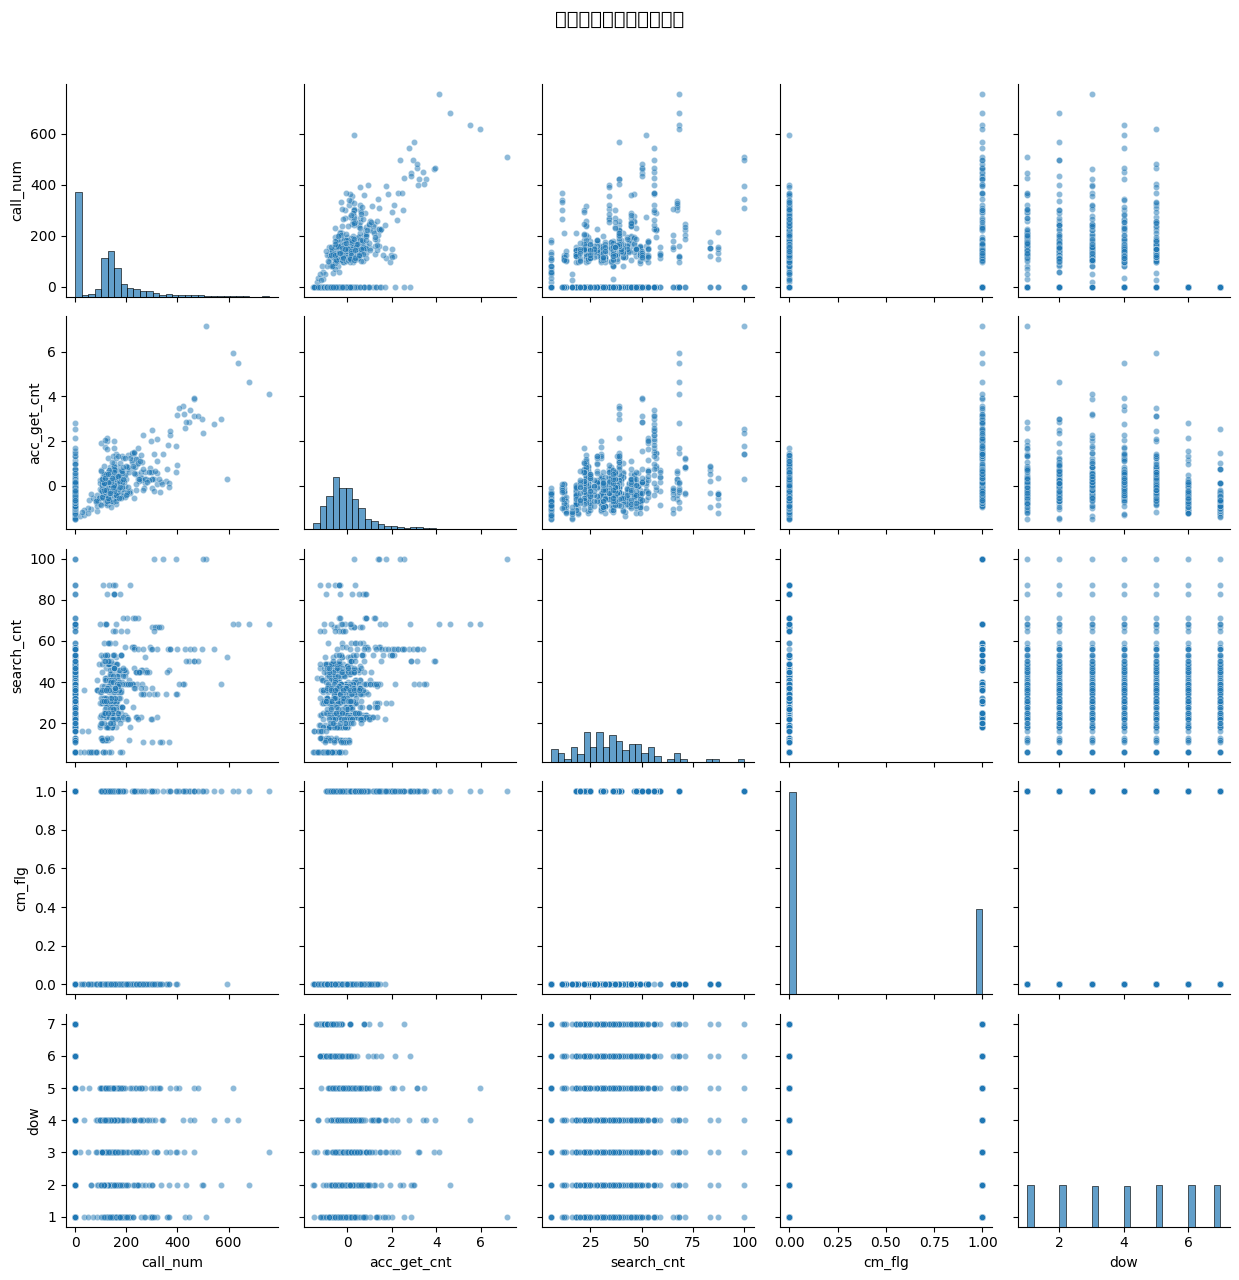


=== 特徴量の基本統計量 ===
                count     mean     std      min      25%      50%      75%      max  missing  missing%
call_num        670.0   116.49  119.92     0.00     0.00   121.00   161.00   757.00        0       0.0
dow             670.0     4.00    2.00     1.00     2.00     4.00     6.00     7.00        0       0.0
woy             670.0    27.24   15.42     1.00    12.25    29.00    40.75    52.00        0       0.0
wom             670.0     3.11    1.31     1.00     2.00     3.00     4.00     6.00        0       0.0
doy             670.0   188.51  108.25     1.00    84.25   198.00   281.75   365.00        0       0.0
financial_year  670.0  2018.55    0.50  2018.00  2018.00  2019.00  2019.00  2019.00        0       0.0
cm_flg          670.0     0.30    0.46     0.00     0.00     0.00     1.00     1.00        0       0.0
acc_get_cnt     670.0     0.03    1.01    -1.51    -0.59    -0.18     0.36     7.15        0       0.0
search_cnt      670.0    36.58   17.77     6.00    24.

In [ ]:
# ===========================================
# 特徴量の相関分析（加工前の元データ）
# ===========================================
# 狙い：特徴量間の関係性を把握し、多重共線性や有用な変数を発見

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 数値型カラムのみ抽出（加工前の元データ）
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()

# 日付由来の加工特徴量を除外（元データのみ残す）
exclude_cols = [
    # ラグ・移動平均系（加工済み）
    "roll7", "excess_calls", "call_lag1", "call_lag7", "acc_lag1", 
    "y_pred", "residual", "residual_ma14", "abs_error",
    # 分位・シナリオ系（加工済み）
    "search_decile", 
    # インデックス系
    "index"
]

# 元データの特徴量のみ抽出
original_cols = [col for col in numeric_cols if col not in exclude_cols]
print(f"分析対象の特徴量 ({len(original_cols)}個):")
for i, col in enumerate(original_cols):
    print(f"  {i+1}. {col}")

# 相関行列を計算
corr_matrix = df_raw[original_cols].corr()

# ===========================================
# 1. ヒートマップ（全体像）
# ===========================================
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # 上三角をマスク
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap="RdBu_r", center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax,
            annot_kws={"size": 9})
ax.set_title("特徴量間の相関行列（加工前データ）", fontsize=14)
plt.tight_layout()
plt.show()

# ===========================================
# 2. 目的変数（call_num）との相関ランキング
# ===========================================
if "call_num" in original_cols:
    target_corr = corr_matrix["call_num"].drop("call_num").sort_values(key=abs, ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ["coral" if x > 0 else "steelblue" for x in target_corr.values]
    bars = ax.barh(range(len(target_corr)), target_corr.values, color=colors, edgecolor="black", alpha=0.8)
    ax.set_yticks(range(len(target_corr)))
    ax.set_yticklabels(target_corr.index)
    ax.set_xlabel("相関係数")
    ax.set_title("目的変数（call_num）との相関ランキング")
    ax.axvline(x=0, color="black", linewidth=1)
    ax.invert_yaxis()
    
    # 値をバーに表示
    for i, (val, bar) in enumerate(zip(target_corr.values, bars)):
        ax.text(val + 0.02 if val > 0 else val - 0.02, i, f"{val:.3f}", 
                va="center", ha="left" if val > 0 else "right", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== call_num との相関係数 ===")
    print(target_corr.round(4).to_string())

# ===========================================
# 3. 強い相関を持つペアの抽出
# ===========================================
print("\n=== 強い相関を持つ特徴量ペア（|r| > 0.5）===")
strong_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_corr_pairs.append({
                "変数1": col1,
                "変数2": col2,
                "相関係数": corr_val
            })

if strong_corr_pairs:
    strong_corr_df = pd.DataFrame(strong_corr_pairs).sort_values("相関係数", key=abs, ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("  |r| > 0.5 のペアはありませんでした")

# ===========================================
# 4. 散布図行列（主要変数）
# ===========================================
# 主要な変数をピックアップ（多すぎると見づらいので5-6個程度）
key_cols = ["call_num", "acc_get_cnt", "search_cnt", "cm_flg", "dow"]
key_cols = [col for col in key_cols if col in original_cols]

if len(key_cols) >= 3:
    fig = plt.figure(figsize=(12, 10))
    
    # ペアプロット
    g = sns.pairplot(df_raw[key_cols].dropna(), diag_kind="hist", 
                     plot_kws={"alpha": 0.5, "s": 20},
                     diag_kws={"bins": 30, "alpha": 0.7})
    g.fig.suptitle("主要特徴量の散布図行列", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ===========================================
# 5. 統計サマリ
# ===========================================
print("\n=== 特徴量の基本統計量 ===")
stats_summary = df_raw[original_cols].describe().T
stats_summary["missing"] = df_raw[original_cols].isnull().sum()
stats_summary["missing%"] = (stats_summary["missing"] / len(df_raw) * 100).round(1)
print(stats_summary.round(2).to_string())


「アカ獲と入電は強く連動（r=0.71）」

「成長局面では問い合わせ負荷が増えるため、**入電を“先読みして最適配分”**することが重要」

「最終的に、成長（アカ獲）を止めずに、サポートコストを抑える」

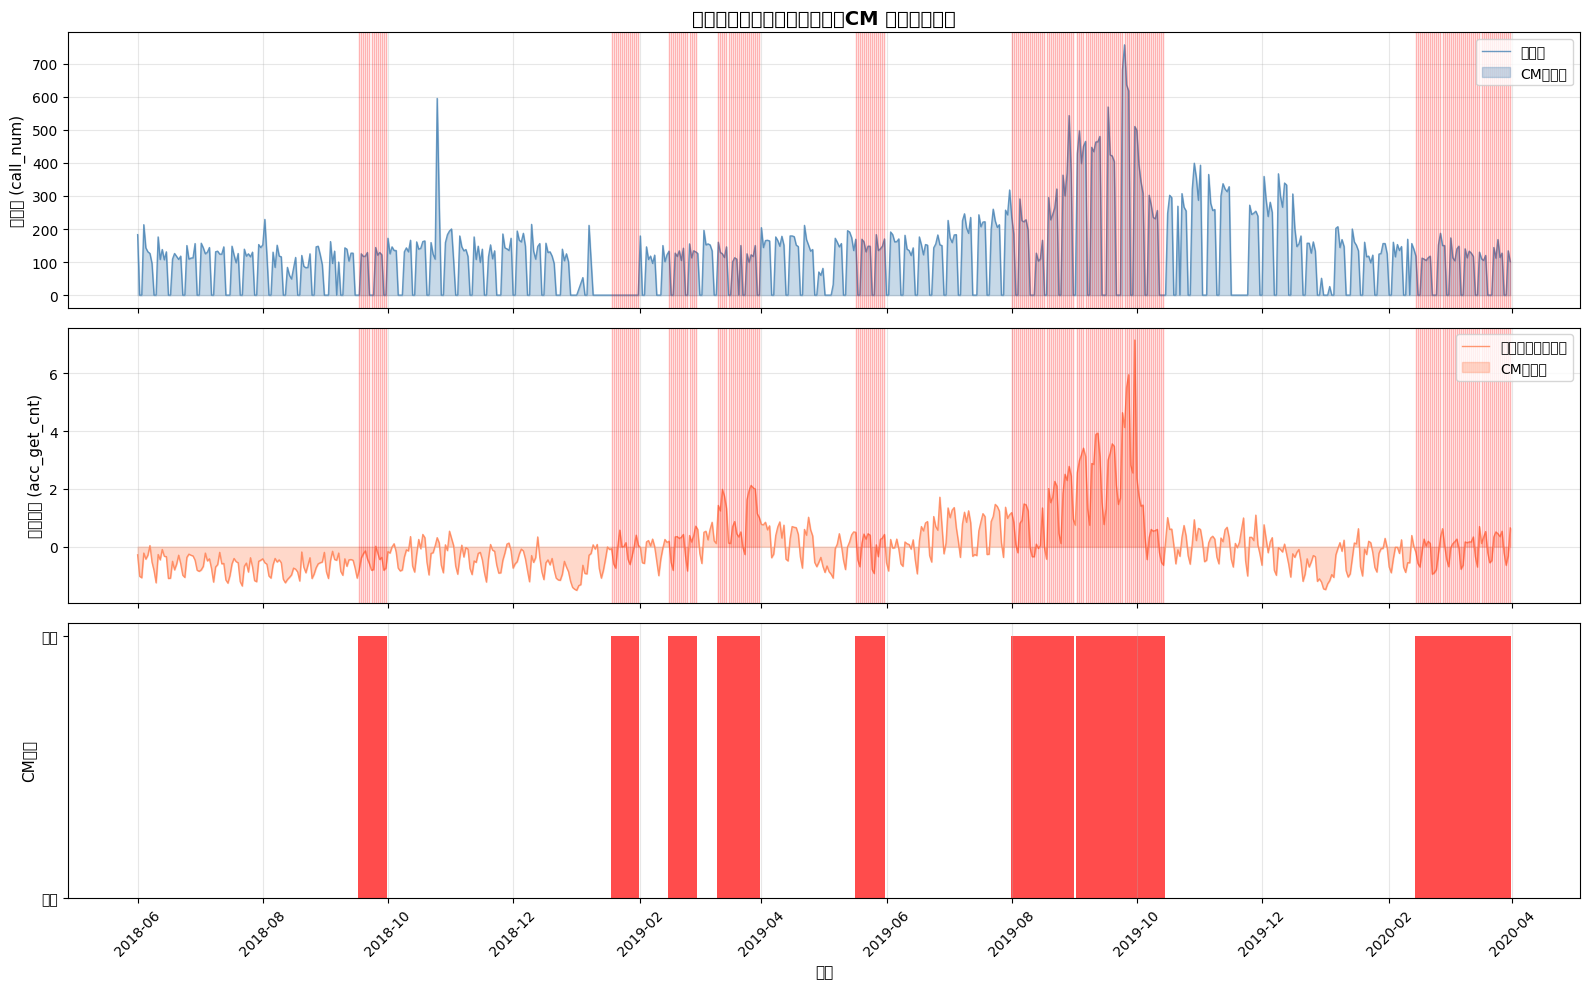

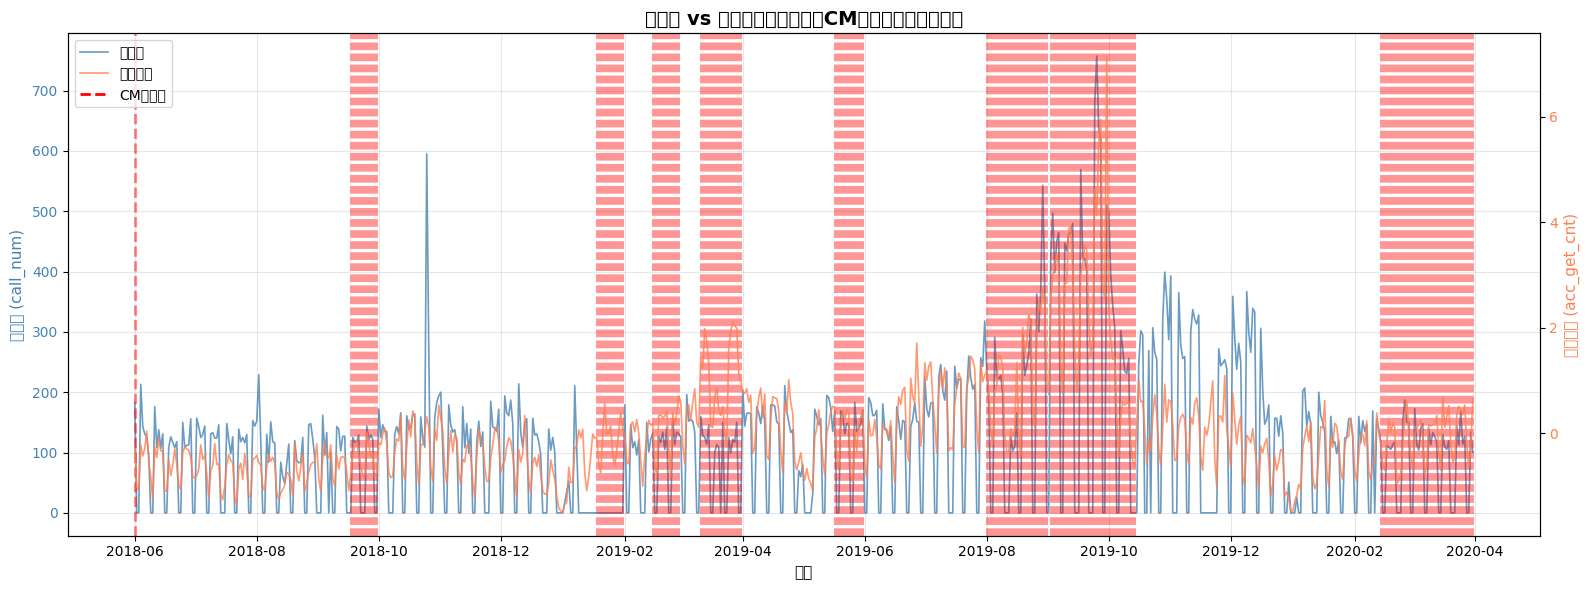

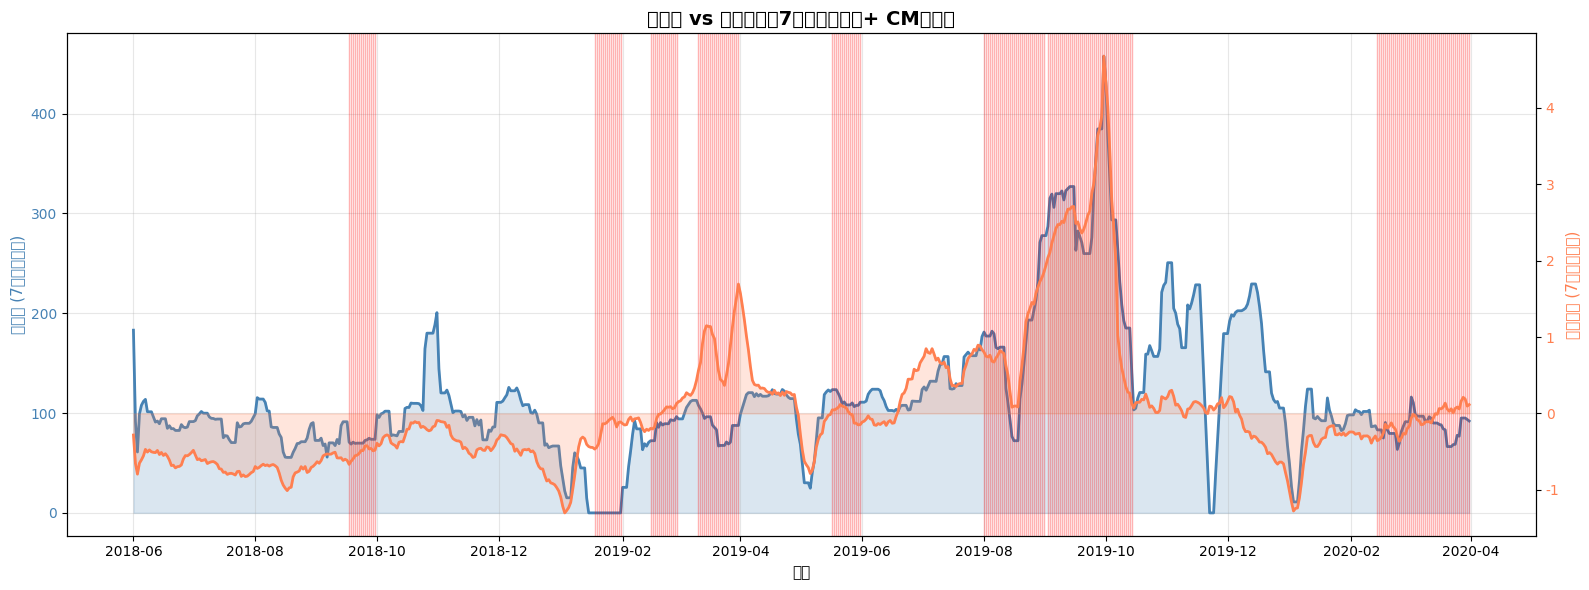

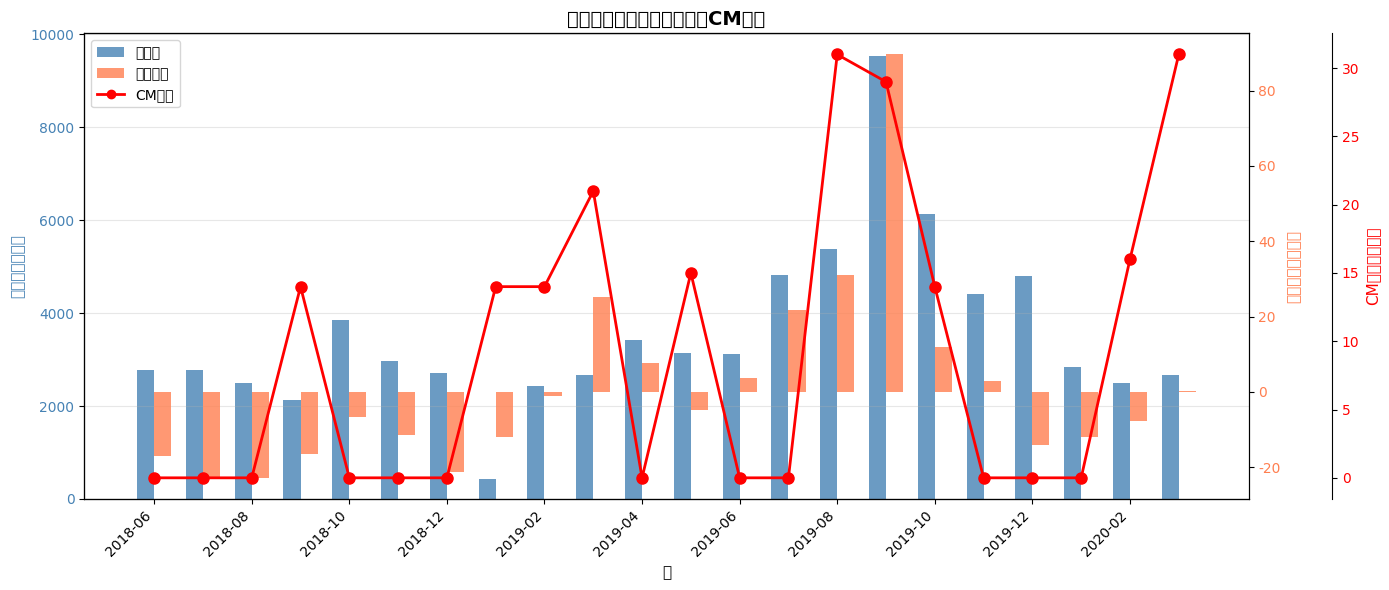

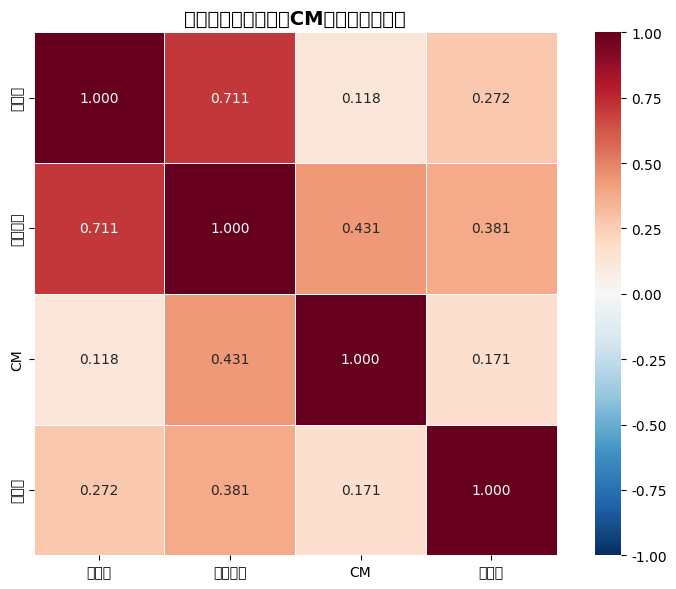


=== 相関係数 ===
入電数 vs アカ獲数: 0.7106
入電数 vs CM:       0.1182
アカ獲数 vs CM:     0.4315


In [ ]:
# ===========================================
# 入電数・アカウント獲得数・CM 統合可視化
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ===========================================
# 1. 時系列グラフ（3指標 + CM縦線）
# ===========================================

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# CM放送日を取得
cm_dates = df_raw[df_raw['cm_flg'] == 1]['cdr_date']

# 上段: 入電数
ax1 = axes[0]
ax1.plot(df_raw['cdr_date'], df_raw['call_num'], color='steelblue', linewidth=1, alpha=0.8)
ax1.fill_between(df_raw['cdr_date'], df_raw['call_num'], alpha=0.3, color='steelblue')
for d in cm_dates:
    ax1.axvline(x=d, color='red', alpha=0.3, linewidth=1)
ax1.set_ylabel('入電数 (call_num)', fontsize=11)
ax1.set_title('入電数・アカウント獲得数・CM の時系列推移', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend(['入電数', 'CM放送日'], loc='upper right')

# 中段: アカウント獲得数
ax2 = axes[1]
ax2.plot(df_raw['cdr_date'], df_raw['acc_get_cnt'], color='coral', linewidth=1, alpha=0.8)
ax2.fill_between(df_raw['cdr_date'], df_raw['acc_get_cnt'], alpha=0.3, color='coral')
for d in cm_dates:
    ax2.axvline(x=d, color='red', alpha=0.3, linewidth=1)
ax2.set_ylabel('アカ獲数 (acc_get_cnt)', fontsize=11)
ax2.grid(alpha=0.3)
ax2.legend(['アカウント獲得数', 'CM放送日'], loc='upper right')

# 下段: CM放送（棒グラフ）
ax3 = axes[2]
ax3.bar(df_raw['cdr_date'], df_raw['cm_flg'], color='red', alpha=0.7, width=1)
ax3.set_ylabel('CM放送', fontsize=11)
ax3.set_xlabel('日付', fontsize=11)
ax3.set_yticks([0, 1])
ax3.set_yticklabels(['なし', 'あり'])
ax3.grid(alpha=0.3, axis='x')

# X軸フォーマット
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# ===========================================
# 2. 2軸グラフ（入電数 vs アカ獲 + CM）
# ===========================================

fig, ax1 = plt.subplots(figsize=(16, 6))

# 入電数（左軸）
color1 = 'steelblue'
ax1.plot(df_raw['cdr_date'], df_raw['call_num'], color=color1, linewidth=1.2, alpha=0.8, label='入電数')
ax1.set_xlabel('日付', fontsize=11)
ax1.set_ylabel('入電数 (call_num)', color=color1, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color1)

# アカウント獲得数（右軸）
ax2 = ax1.twinx()
color2 = 'coral'
ax2.plot(df_raw['cdr_date'], df_raw['acc_get_cnt'], color=color2, linewidth=1.2, alpha=0.8, label='アカ獲数')
ax2.set_ylabel('アカ獲数 (acc_get_cnt)', color=color2, fontsize=11)
ax2.tick_params(axis='y', labelcolor=color2)

# CM放送日を縦線で表示
for d in cm_dates:
    ax1.axvline(x=d, color='red', alpha=0.4, linewidth=1.5, linestyle='--')

# 凡例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.axvline(x=df_raw['cdr_date'].min(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='CM放送日')
ax1.legend(lines1 + lines2 + [plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2)], 
           labels1 + labels2 + ['CM放送日'], loc='upper left')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax1.set_title('入電数 vs アカウント獲得数（CM放送日マーク付き）', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ===========================================
# 3. 7日移動平均での比較（ノイズ除去）
# ===========================================

# 移動平均を計算
df_raw['call_ma7'] = df_raw['call_num'].rolling(7, min_periods=1).mean()
df_raw['acc_ma7'] = df_raw['acc_get_cnt'].rolling(7, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(16, 6))

# 入電数（左軸）
color1 = 'steelblue'
ax1.plot(df_raw['cdr_date'], df_raw['call_ma7'], color=color1, linewidth=2, label='入電数 (7日MA)')
ax1.fill_between(df_raw['cdr_date'], df_raw['call_ma7'], alpha=0.2, color=color1)
ax1.set_xlabel('日付', fontsize=11)
ax1.set_ylabel('入電数 (7日移動平均)', color=color1, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color1)

# アカウント獲得数（右軸）
ax2 = ax1.twinx()
color2 = 'coral'
ax2.plot(df_raw['cdr_date'], df_raw['acc_ma7'], color=color2, linewidth=2, label='アカ獲数 (7日MA)')
ax2.fill_between(df_raw['cdr_date'], df_raw['acc_ma7'], alpha=0.2, color=color2)
ax2.set_ylabel('アカ獲数 (7日移動平均)', color=color2, fontsize=11)
ax2.tick_params(axis='y', labelcolor=color2)

# CM放送日
for d in cm_dates:
    ax1.axvline(x=d, color='red', alpha=0.3, linewidth=1)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax1.set_title('入電数 vs アカ獲数（7日移動平均）+ CM放送日', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ===========================================
# 4. 月別集計（棒グラフ）
# ===========================================

df_raw['year_month'] = df_raw['cdr_date'].dt.to_period('M')

monthly = df_raw.groupby('year_month').agg({
    'call_num': 'sum',
    'acc_get_cnt': 'sum',
    'cm_flg': 'sum'
}).reset_index()
monthly['year_month'] = monthly['year_month'].astype(str)

fig, ax1 = plt.subplots(figsize=(14, 6))

x = np.arange(len(monthly))
width = 0.35

# 入電数（左軸）
bars1 = ax1.bar(x - width/2, monthly['call_num'], width, label='入電数（月計）', color='steelblue', alpha=0.8)
ax1.set_xlabel('月', fontsize=11)
ax1.set_ylabel('入電数（月計）', color='steelblue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='steelblue')

# アカウント獲得数（右軸）
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, monthly['acc_get_cnt'], width, label='アカ獲数（月計）', color='coral', alpha=0.8)
ax2.set_ylabel('アカ獲数（月計）', color='coral', fontsize=11)
ax2.tick_params(axis='y', labelcolor='coral')

# CM回数をマーカーで表示
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(x, monthly['cm_flg'], 'ro-', markersize=8, linewidth=2, label='CM回数')
ax3.set_ylabel('CM回数（月計）', color='red', fontsize=11)
ax3.tick_params(axis='y', labelcolor='red')

ax1.set_xticks(x[::2])
ax1.set_xticklabels(monthly['year_month'].iloc[::2], rotation=45, ha='right')
ax1.set_title('月別：入電数・アカ獲数・CM回数', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# 凡例
lines = [bars1, bars2, plt.Line2D([0], [0], color='red', marker='o', linewidth=2)]
labels = ['入電数', 'アカ獲数', 'CM回数']
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()


# ===========================================
# 5. 相関ヒートマップ
# ===========================================

fig, ax = plt.subplots(figsize=(8, 6))

corr_cols = ['call_num', 'acc_get_cnt', 'cm_flg', 'search_cnt']
corr_matrix = df_raw[corr_cols].corr()

# 日本語ラベル
labels_jp = ['入電数', 'アカ獲数', 'CM', '検索量']

import seaborn as sns
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            xticklabels=labels_jp, yticklabels=labels_jp, ax=ax,
            vmin=-1, vmax=1, square=True, linewidths=0.5)
ax.set_title('入電数・アカ獲数・CM・検索量の相関', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== 相関係数 ===")
print(f"入電数 vs アカ獲数: {df_raw['call_num'].corr(df_raw['acc_get_cnt']):.4f}")
print(f"入電数 vs CM:       {df_raw['call_num'].corr(df_raw['cm_flg']):.4f}")
print(f"アカ獲数 vs CM:     {df_raw['acc_get_cnt'].corr(df_raw['cm_flg']):.4f}")


In [ ]:
# ==================================================================================
# 特徴量単体の可視化
# ==================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================================================================================
# データ読み込み・特徴量作成（exp22と同じ）
# ==================================================================================

def load_and_create_features():
    """exp22と同じデータ・特徴量を作成"""
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    # データ結合
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    # Google Trends週次→日次
    gt_daily = []
    for _, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    df = df.merge(pd.DataFrame(gt_daily), on='cdr_date', how='left')
    
    # 時系列特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    # ラグ特徴量
    for lag in [1, 2, 3, 5, 7, 14, 30]:
        df[f'lag_{lag}'] = df['call_num'].shift(lag)
    
    # 移動平均特徴量
    for window in [3, 7, 30]:
        df[f'ma_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).std()
    
    # 集約特徴量
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    # レジーム変化特徴量
    tax_date = pd.Timestamp('2019-10-01')
    df['days_to_2019_10_01'] = (tax_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= pd.Timestamp('2019-09-30')).astype(int)
    
    rush_start = pd.Timestamp('2019-09-30') - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= pd.Timestamp('2019-09-30'))).astype(int)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_date) & 
                                   (df['cdr_date'] <= tax_date + pd.Timedelta(days=30))).astype(int)
    
    # ターゲット
    df['target_next_day'] = df['call_num'].shift(-1)
    
    return df

df = load_and_create_features()
print(f"データ読み込み完了: {df.shape}")
print(f"期間: {df['cdr_date'].min()} ~ {df['cdr_date'].max()}")


データ読み込み完了: (670, 44)
期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00


データ読み込み完了: (670, 44)
期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00


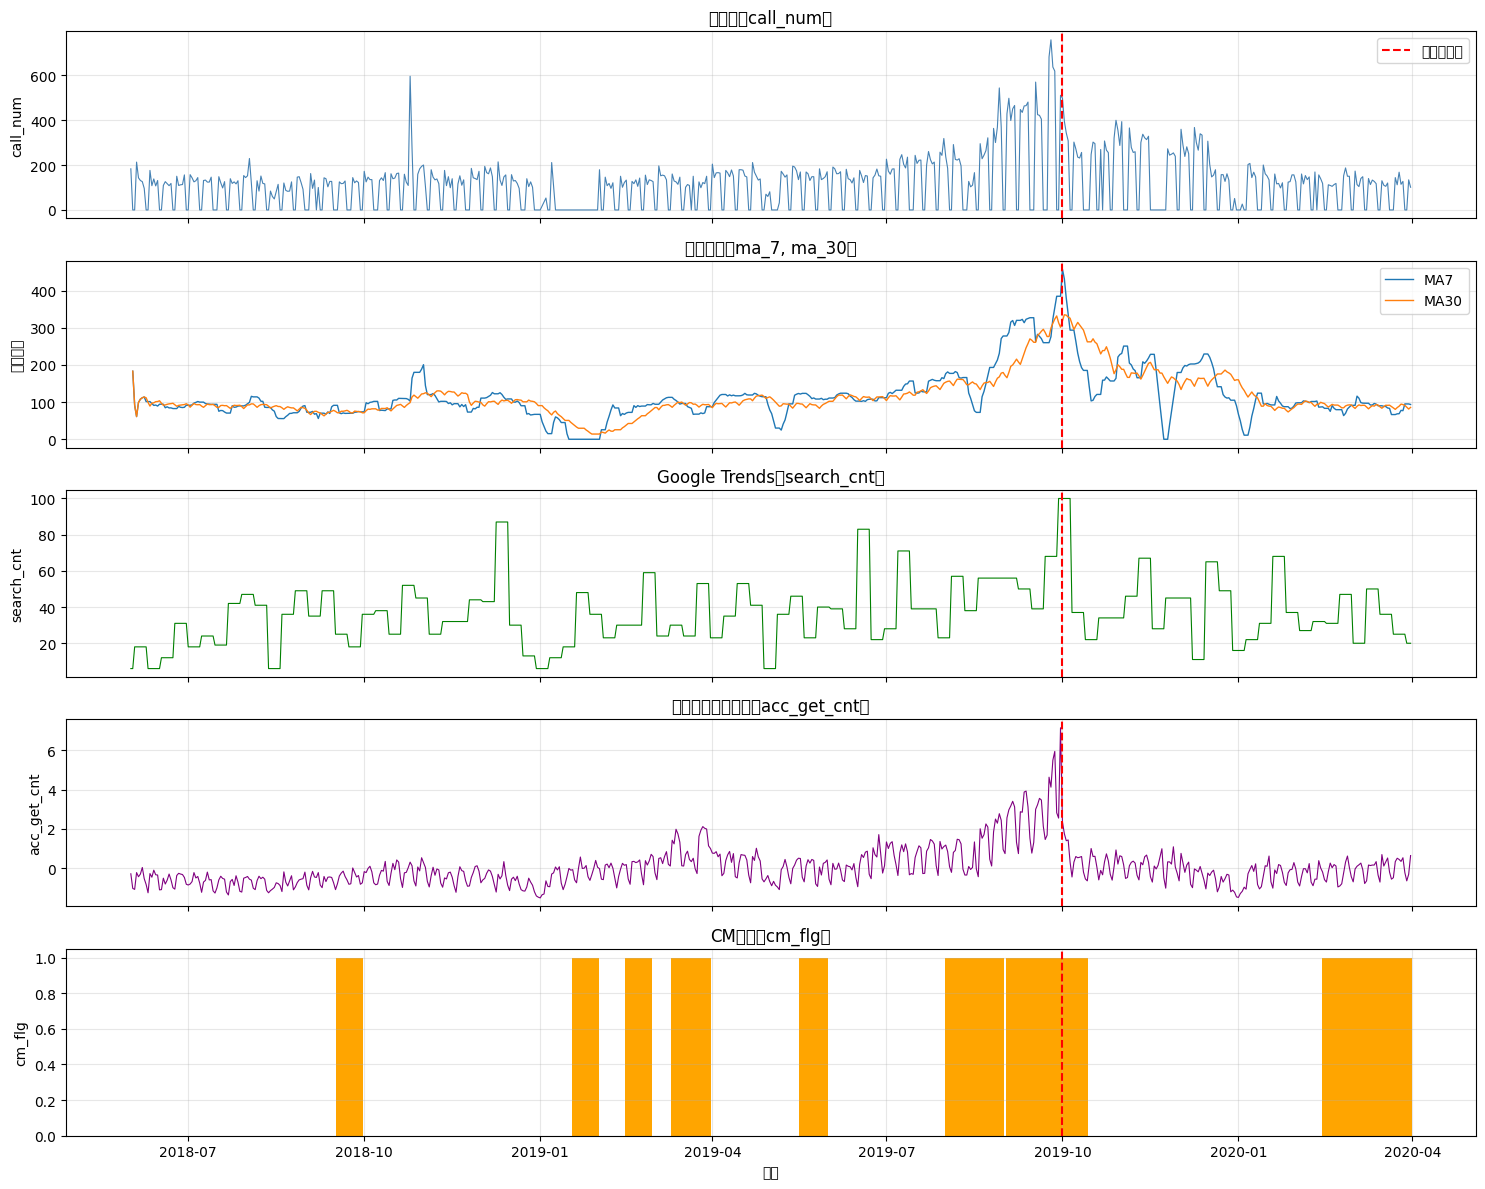

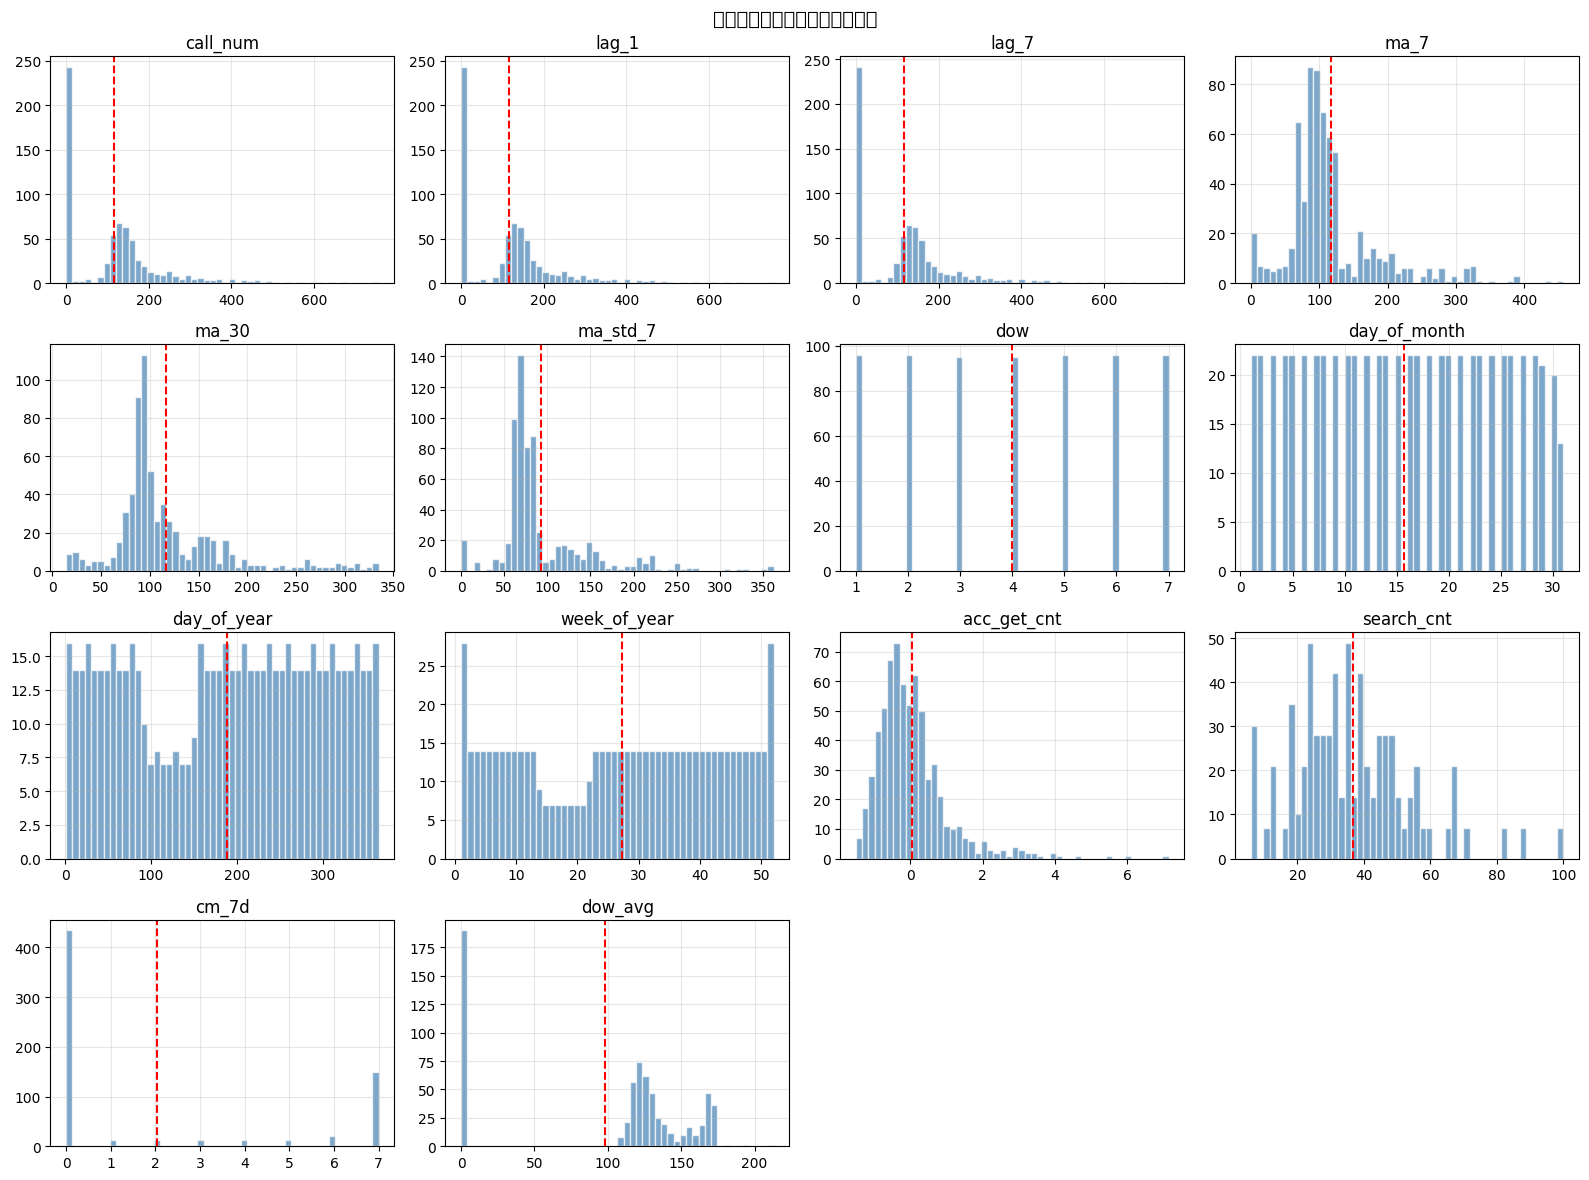

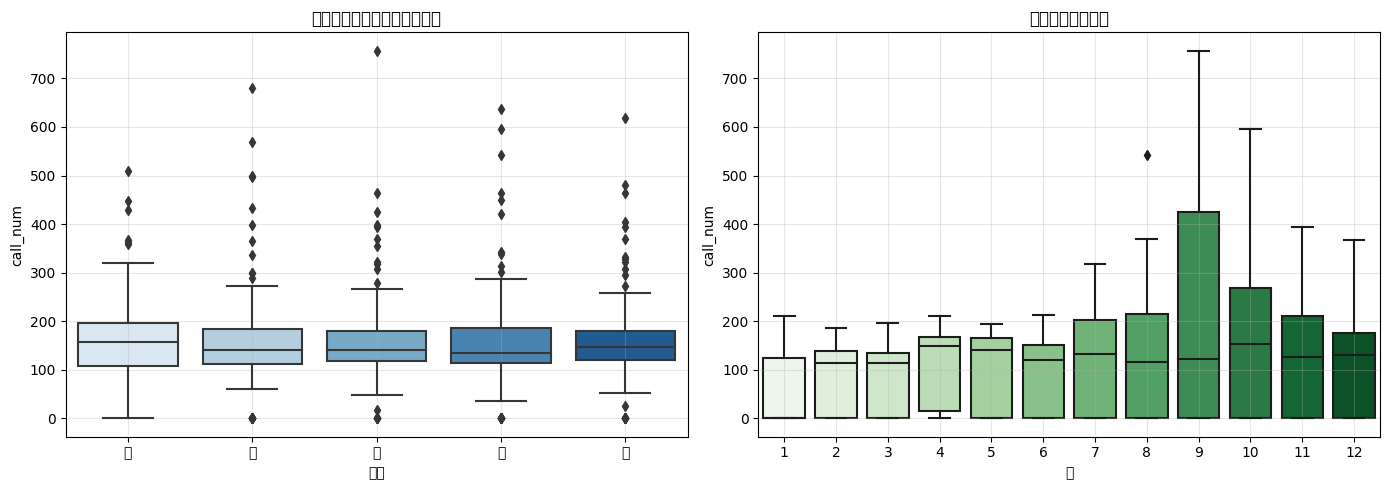

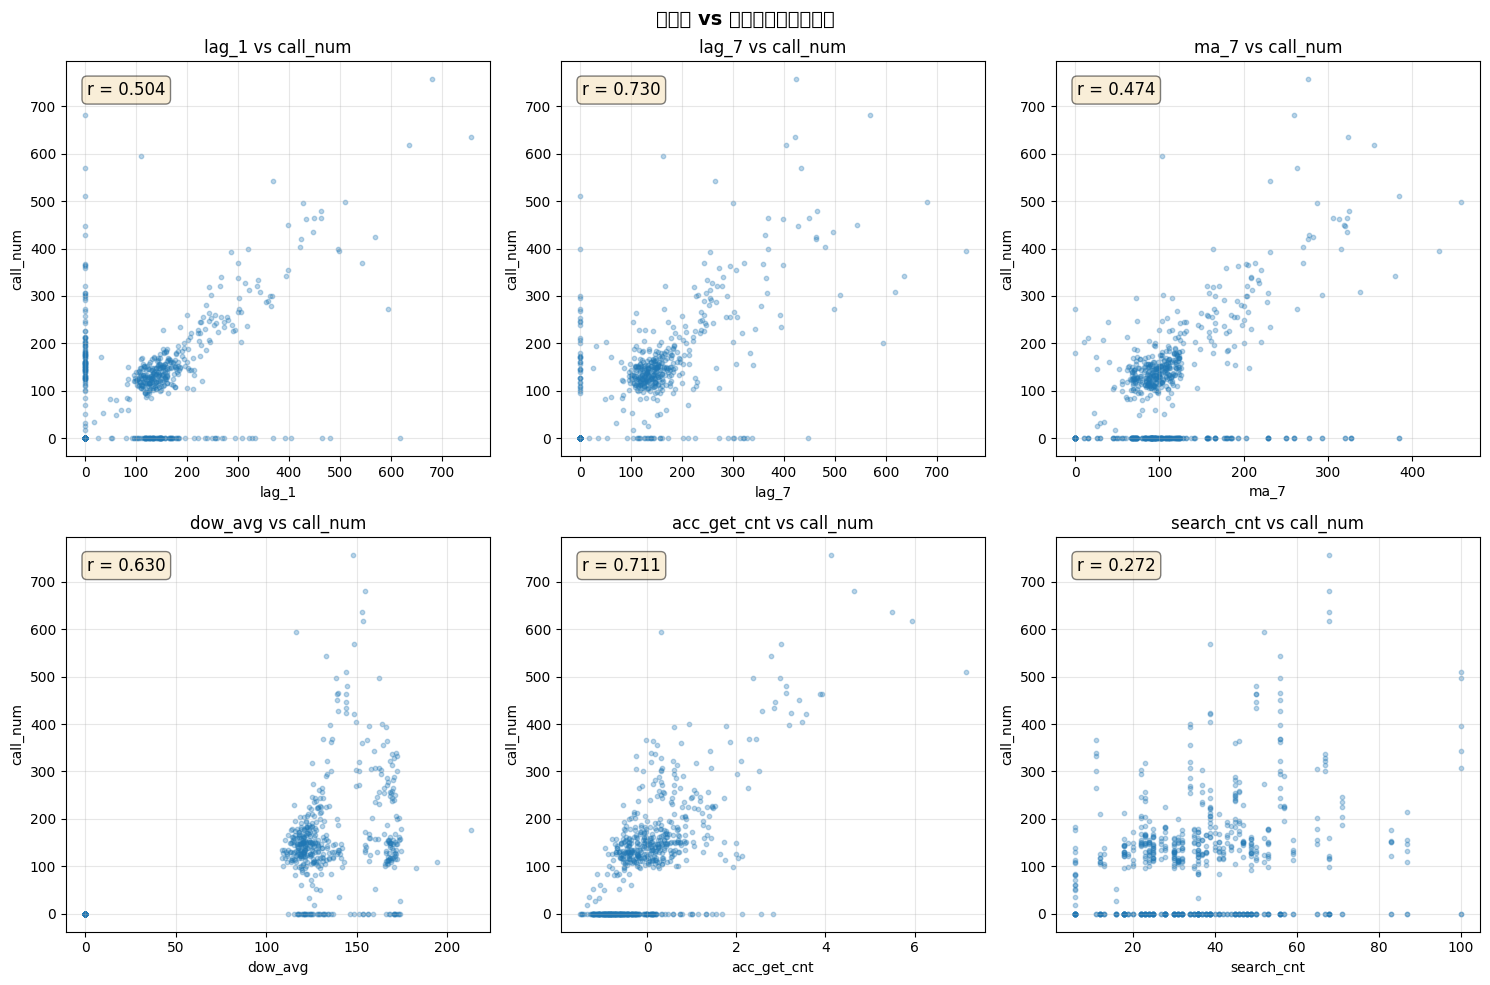

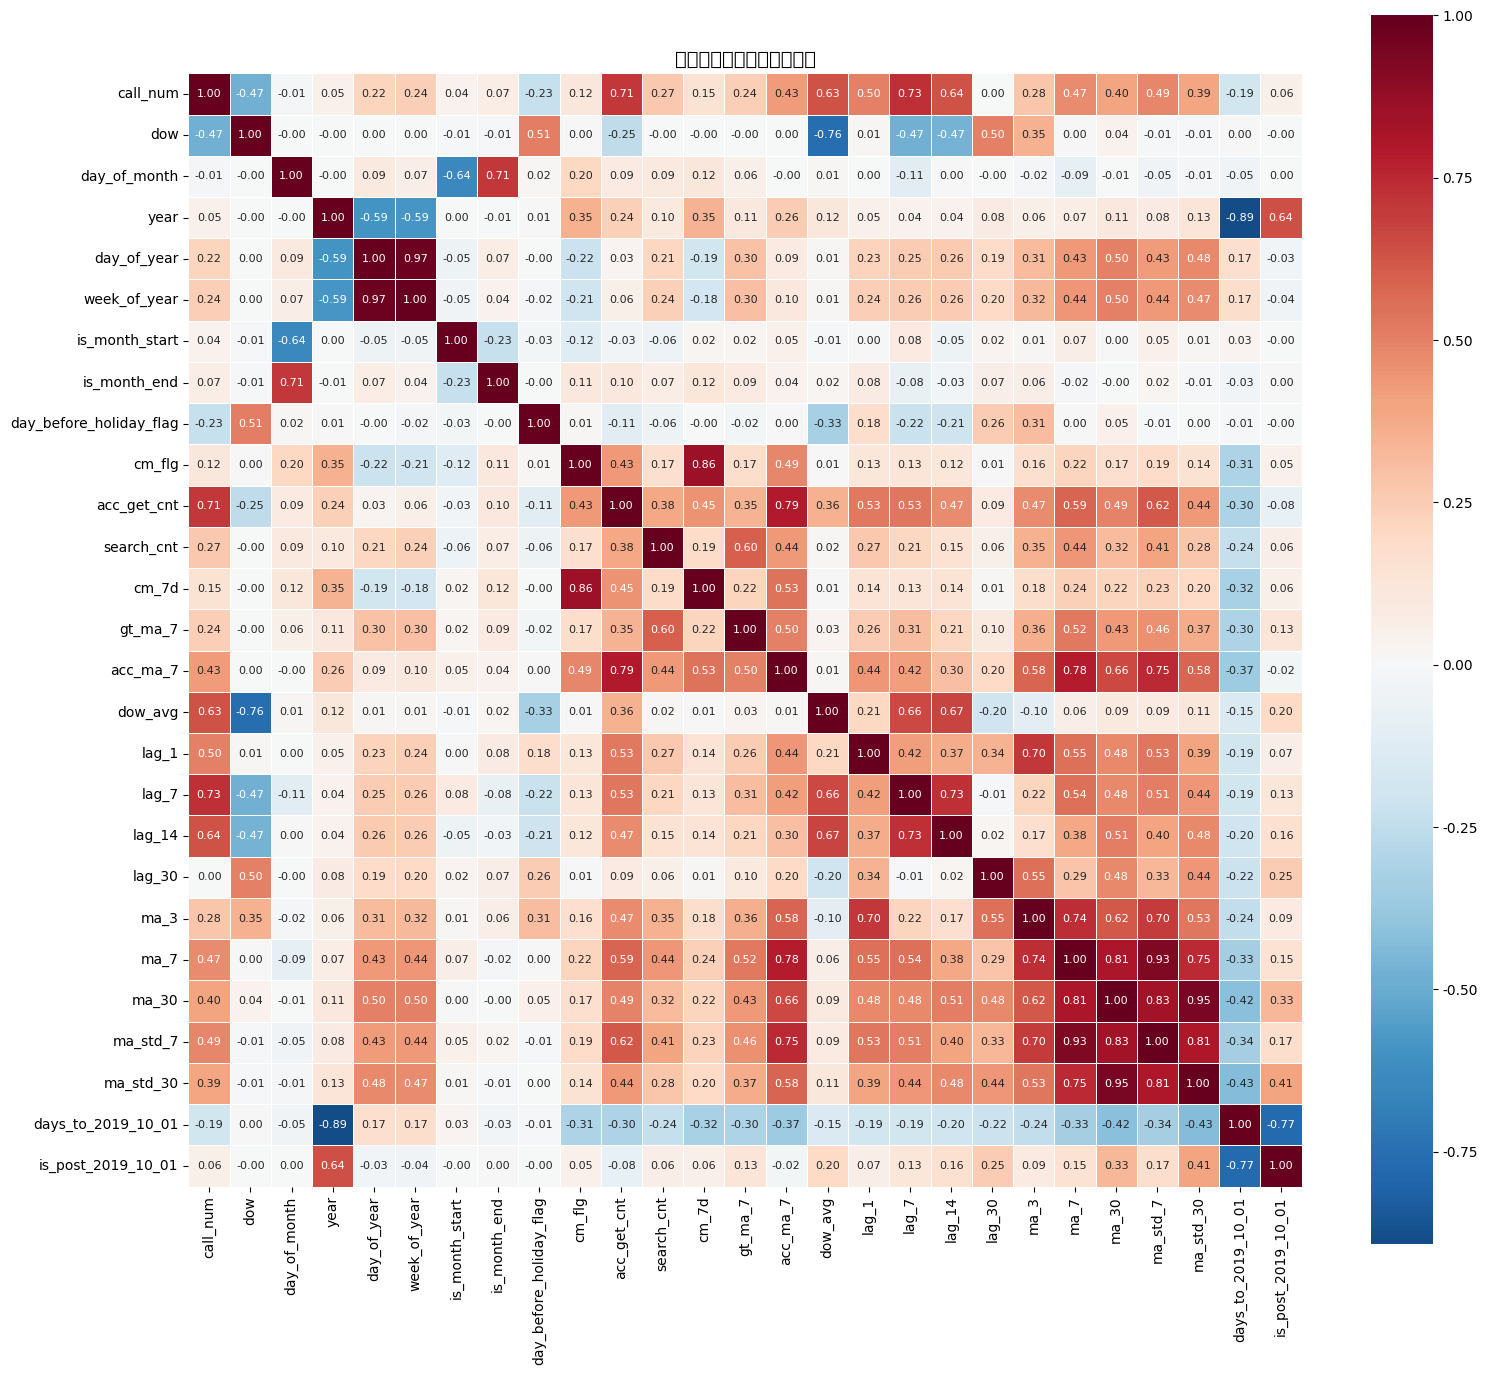

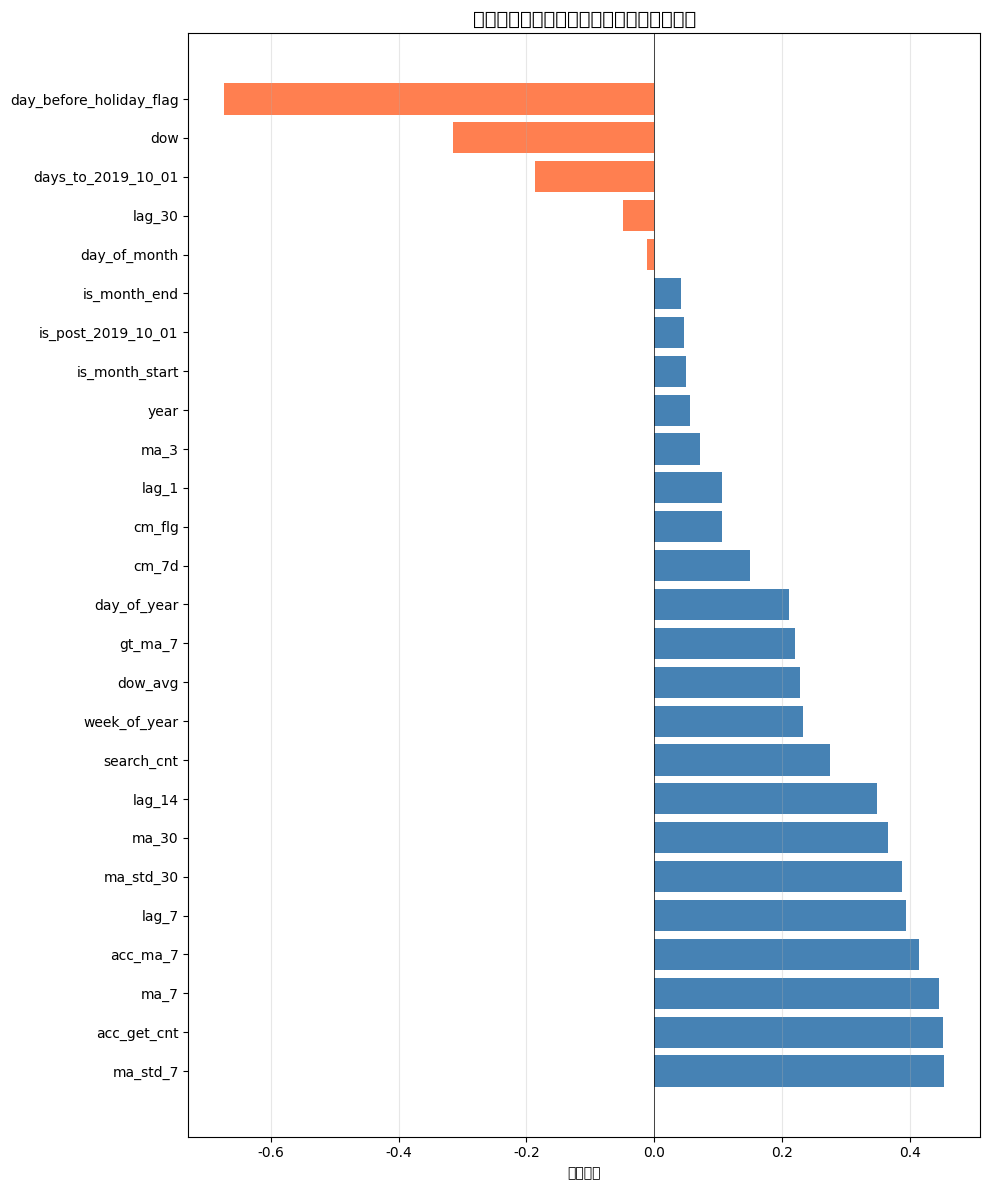


相関係数Top10:
              correlation
ma_std_7         0.453945
acc_get_cnt      0.452938
ma_7             0.445817
acc_ma_7         0.415179
lag_7            0.394305
ma_std_30        0.388484
ma_30            0.366252
lag_14           0.349548
search_cnt       0.274889
week_of_year     0.233125


ValueError: cannot insert cdr_date, already exists

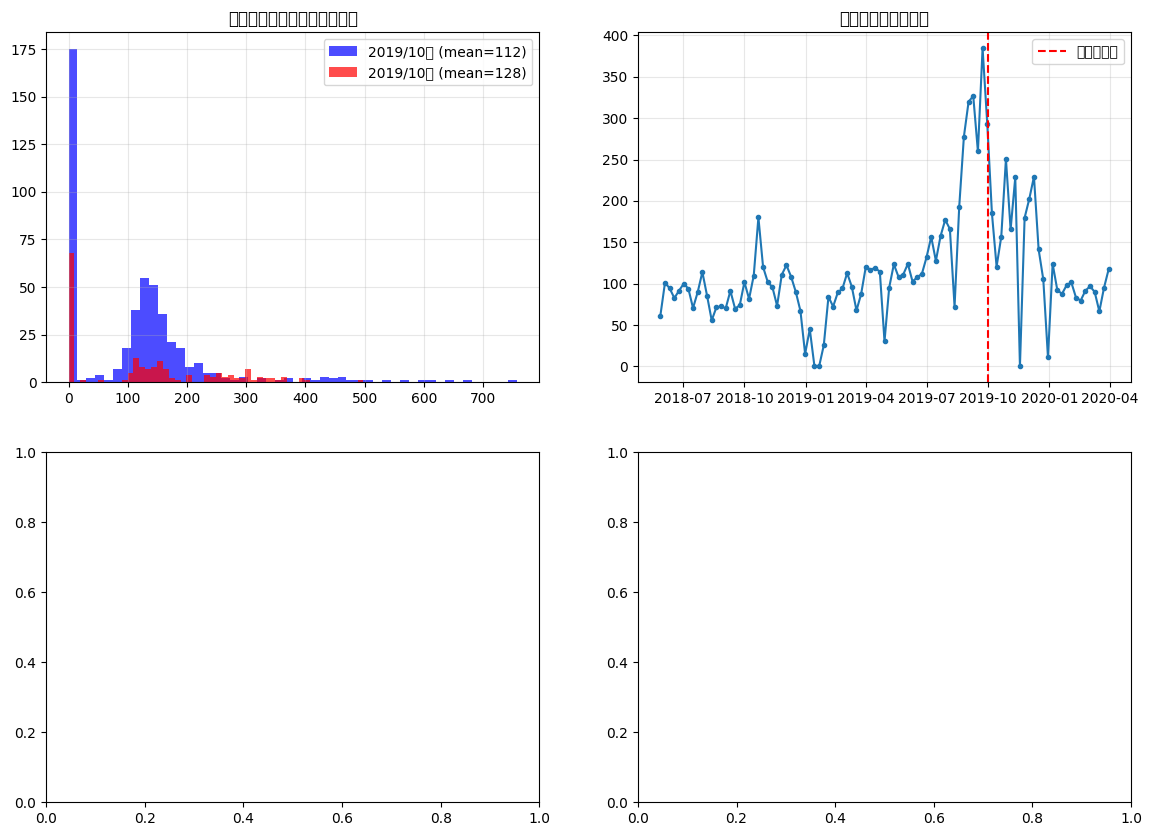

In [ ]:
# ==================================================================================
# 特徴量単体の可視化
# ==================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================================================================================
# データ読み込み・特徴量作成（exp22と同じ）
# ==================================================================================

def load_and_create_features():
    """exp22と同じデータ・特徴量を作成"""
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    # データ結合
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    # Google Trends週次→日次
    gt_daily = []
    for _, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    df = df.merge(pd.DataFrame(gt_daily), on='cdr_date', how='left')
    
    # 時系列特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    # ラグ特徴量
    for lag in [1, 2, 3, 5, 7, 14, 30]:
        df[f'lag_{lag}'] = df['call_num'].shift(lag)
    
    # 移動平均特徴量
    for window in [3, 7, 30]:
        df[f'ma_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).std()
    
    # 集約特徴量
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    # レジーム変化特徴量
    tax_date = pd.Timestamp('2019-10-01')
    df['days_to_2019_10_01'] = (tax_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= pd.Timestamp('2019-09-30')).astype(int)
    
    rush_start = pd.Timestamp('2019-09-30') - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= pd.Timestamp('2019-09-30'))).astype(int)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_date) & 
                                   (df['cdr_date'] <= tax_date + pd.Timedelta(days=30))).astype(int)
    
    # ターゲット
    df['target_next_day'] = df['call_num'].shift(-1)
    
    return df

df = load_and_create_features()
print(f"データ読み込み完了: {df.shape}")
print(f"期間: {df['cdr_date'].min()} ~ {df['cdr_date'].max()}")

# ==================================================================================
# 1. 時系列プロット（目的変数 + 主要特徴量）
# ==================================================================================

fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

# call_num（目的変数）
axes[0].plot(df['cdr_date'], df['call_num'], color='steelblue', linewidth=0.8)
axes[0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', label='消費税変更')
axes[0].set_ylabel('call_num')
axes[0].set_title('入電数（call_num）')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 移動平均
axes[1].plot(df['cdr_date'], df['ma_7'], label='MA7', linewidth=1)
axes[1].plot(df['cdr_date'], df['ma_30'], label='MA30', linewidth=1)
axes[1].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[1].set_ylabel('移動平均')
axes[1].set_title('移動平均（ma_7, ma_30）')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Google Trends
axes[2].plot(df['cdr_date'], df['search_cnt'], color='green', linewidth=0.8)
axes[2].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[2].set_ylabel('search_cnt')
axes[2].set_title('Google Trends（search_cnt）')
axes[2].grid(alpha=0.3)

# アカウント取得数
axes[3].plot(df['cdr_date'], df['acc_get_cnt'], color='purple', linewidth=0.8)
axes[3].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[3].set_ylabel('acc_get_cnt')
axes[3].set_title('アカウント取得数（acc_get_cnt）')
axes[3].grid(alpha=0.3)

# CM実施
axes[4].bar(df['cdr_date'], df['cm_flg'], color='orange', width=1)
axes[4].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[4].set_ylabel('cm_flg')
axes[4].set_title('CM実施（cm_flg）')
axes[4].grid(alpha=0.3)

plt.xlabel('日付')
plt.tight_layout()
plt.show()

# ==================================================================================
# 2. 特徴量の分布（ヒストグラム）
# ==================================================================================

# 可視化対象の特徴量
features_to_plot = [
    'call_num', 'lag_1', 'lag_7', 'ma_7', 'ma_30', 'ma_std_7',
    'dow', 'day_of_month', 'day_of_year', 'week_of_year',
    'acc_get_cnt', 'search_cnt', 'cm_7d', 'dow_avg'
]

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(features_to_plot):
    if feat in df.columns:
        data = df[feat].dropna()
        axes[i].hist(data, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        axes[i].set_title(feat)
        axes[i].set_xlabel('')
        axes[i].grid(alpha=0.3)
        
        # 基本統計量を表示
        mean_val = data.mean()
        std_val = data.std()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'mean={mean_val:.1f}')

# 余ったサブプロットを非表示
for j in range(len(features_to_plot), len(axes)):
    axes[j].axis('off')

plt.suptitle('特徴量の分布（ヒストグラム）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 3. 曜日別の入電数分布（箱ひげ図）
# ==================================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 曜日別（平日のみ）
df_weekday = df[df['dow'].isin([1, 2, 3, 4, 5])]
dow_labels = {1: '月', 2: '火', 3: '水', 4: '木', 5: '金'}
df_weekday['dow_label'] = df_weekday['dow'].map(dow_labels)

sns.boxplot(x='dow_label', y='call_num', data=df_weekday, ax=axes[0], 
            order=['月', '火', '水', '木', '金'], palette='Blues')
axes[0].set_title('曜日別の入電数分布（平日）')
axes[0].set_xlabel('曜日')
axes[0].set_ylabel('call_num')
axes[0].grid(alpha=0.3)

# 月別
sns.boxplot(x='month', y='call_num', data=df, ax=axes[1], palette='Greens')
axes[1].set_title('月別の入電数分布')
axes[1].set_xlabel('月')
axes[1].set_ylabel('call_num')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==================================================================================
# 4. 特徴量と目的変数の散布図
# ==================================================================================

scatter_features = ['lag_1', 'lag_7', 'ma_7', 'dow_avg', 'acc_get_cnt', 'search_cnt']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(scatter_features):
    if feat in df.columns:
        data = df[[feat, 'call_num']].dropna()
        axes[i].scatter(data[feat], data['call_num'], alpha=0.3, s=10)
        axes[i].set_xlabel(feat)
        axes[i].set_ylabel('call_num')
        axes[i].set_title(f'{feat} vs call_num')
        axes[i].grid(alpha=0.3)
        
        # 相関係数
        corr = data[feat].corr(data['call_num'])
        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes,
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('特徴量 vs 目的変数（散布図）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 5. 相関ヒートマップ
# ==================================================================================

# exp22の特徴量
feature_cols = [
    'call_num', 'dow', 'day_of_month', 'year', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end', 'day_before_holiday_flag',
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    'ma_3', 'ma_7', 'ma_30', 'ma_std_7', 'ma_std_30',
    'days_to_2019_10_01', 'is_post_2019_10_01'
]

# 存在する特徴量のみ
available_features = [f for f in feature_cols if f in df.columns]
corr_matrix = df[available_features].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, annot_kws={'size': 8})
plt.title('特徴量の相関ヒートマップ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 6. ターゲット（翌日入電数）との相関
# ==================================================================================

df_clean = df.dropna(subset=['target_next_day'])

correlations = {}
for feat in available_features:
    if feat in df_clean.columns and feat != 'call_num':
        corr = df_clean[feat].corr(df_clean['target_next_day'])
        correlations[feat] = corr

# ソートして表示
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', ascending=False)

plt.figure(figsize=(10, 12))
colors = ['steelblue' if x > 0 else 'coral' for x in corr_df['correlation']]
plt.barh(corr_df.index, corr_df['correlation'], color=colors)
plt.xlabel('相関係数')
plt.title('特徴量とターゲット（翌日入電数）の相関', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n相関係数Top10:")
print(corr_df.head(10).to_string())

# ==================================================================================
# 7. レジーム変化の可視化（消費税前後）
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 消費税前後の入電数
pre_tax = df[df['cdr_date'] < '2019-10-01']['call_num'].dropna()
post_tax = df[df['cdr_date'] >= '2019-10-01']['call_num'].dropna()

axes[0, 0].hist(pre_tax, bins=50, alpha=0.7, label=f'2019/10前 (mean={pre_tax.mean():.0f})', color='blue')
axes[0, 0].hist(post_tax, bins=50, alpha=0.7, label=f'2019/10後 (mean={post_tax.mean():.0f})', color='red')
axes[0, 0].set_title('消費税変更前後の入電数分布')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 週次推移
df_weekly = df.groupby(df['cdr_date'].dt.to_period('W'))['call_num'].mean().reset_index()
df_weekly['cdr_date'] = df_weekly['cdr_date'].dt.to_timestamp()
axes[0, 1].plot(df_weekly['cdr_date'], df_weekly['call_num'], marker='o', markersize=3)
axes[0, 1].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', label='消費税変更')
axes[0, 1].set_title('週平均入電数の推移')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 月別比較
monthly = df.groupby([df['cdr_date'].dt.year, df['cdr_date'].dt.month])['call_num'].mean()
monthly_df = monthly.reset_index()
monthly_df.columns = ['year', 'month', 'call_num']
monthly_df['year_month'] = monthly_df['year'].astype(str) + '-' + monthly_df['month'].astype(str).str.zfill(2)

colors = ['red' if y >= 2019 and m >= 10 else 'blue' for y, m in zip(monthly_df['year'], monthly_df['month'])]
axes[1, 0].bar(range(len(monthly_df)), monthly_df['call_num'], color=colors)
axes[1, 0].set_xticks(range(0, len(monthly_df), 3))
axes[1, 0].set_xticklabels(monthly_df['year_month'].iloc[::3], rotation=45)
axes[1, 0].set_title('月別平均入電数')
axes[1, 0].grid(alpha=0.3)

# 曜日×消費税前後
df_weekday_pre = df[(df['cdr_date'] < '2019-10-01') & (df['dow'].isin([1,2,3,4,5]))]
df_weekday_post = df[(df['cdr_date'] >= '2019-10-01') & (df['dow'].isin([1,2,3,4,5]))]

dow_pre = df_weekday_pre.groupby('dow')['call_num'].mean()
dow_post = df_weekday_post.groupby('dow')['call_num'].mean()

x = np.arange(5)
width = 0.35
axes[1, 1].bar(x - width/2, dow_pre.values, width, label='2019/10前', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, dow_post.values, width, label='2019/10後', color='red', alpha=0.7)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['月', '火', '水', '木', '金'])
axes[1, 1].set_title('曜日別平均入電数（消費税前後）')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

データ読み込み完了: (670, 44)
期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00


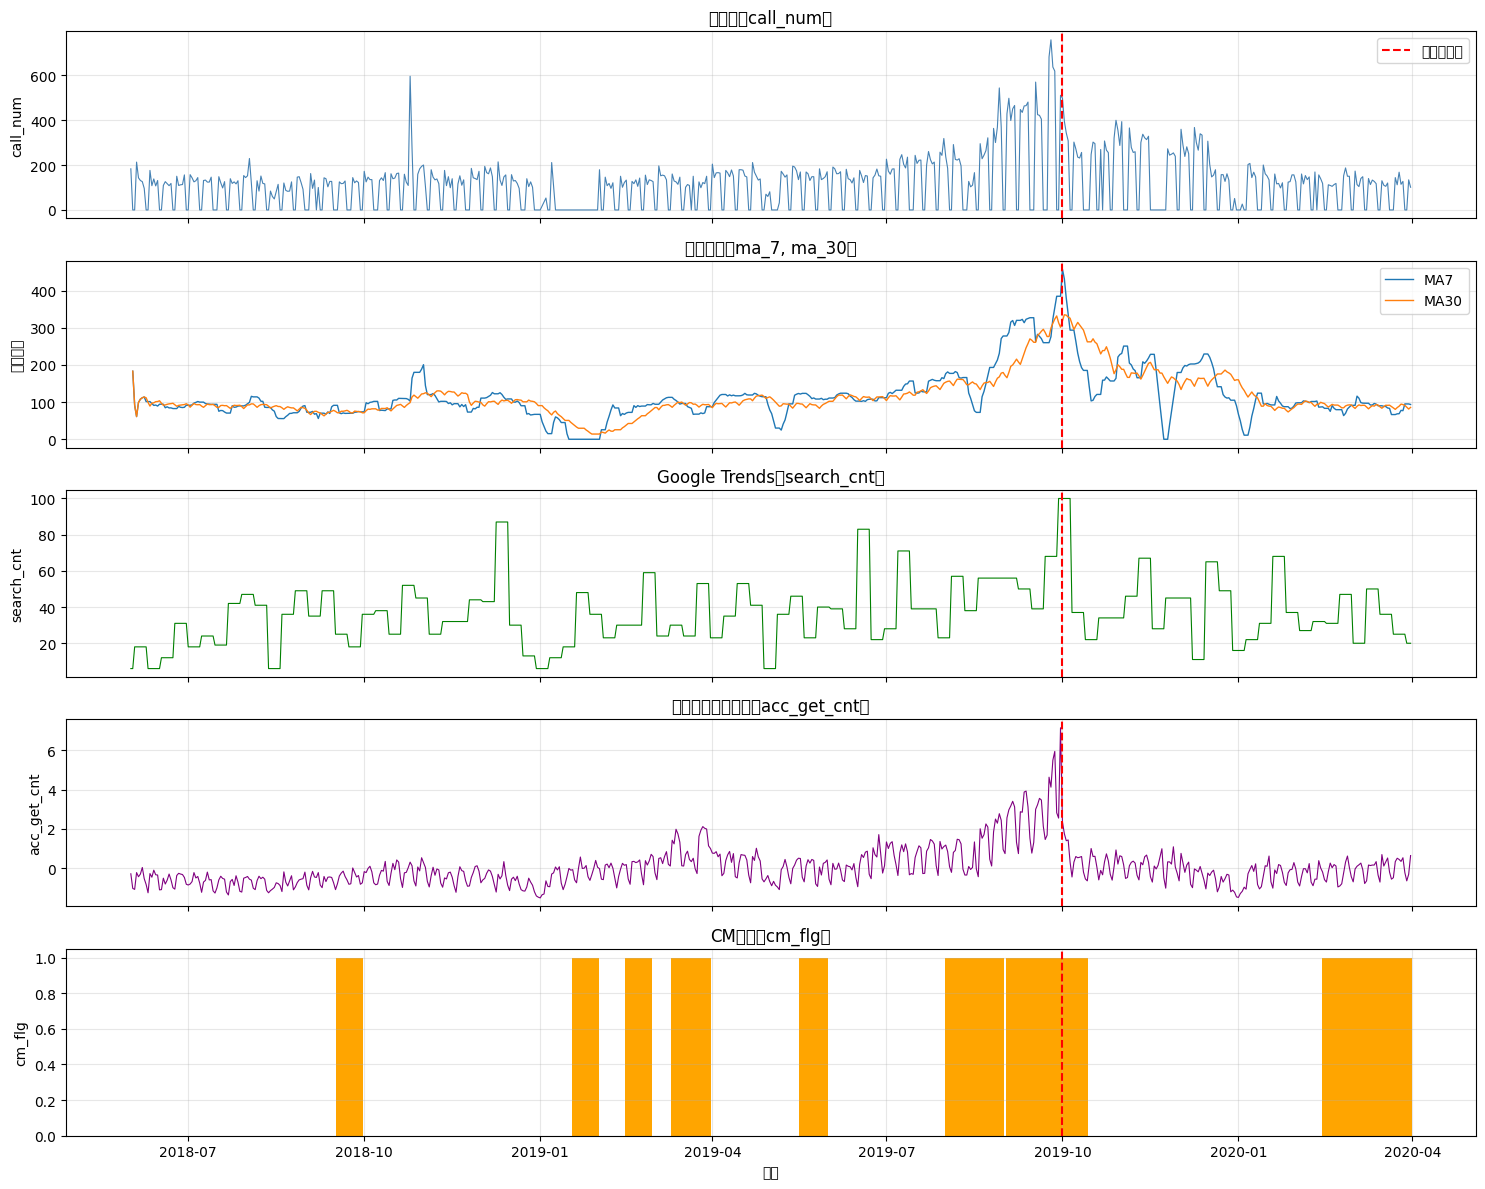

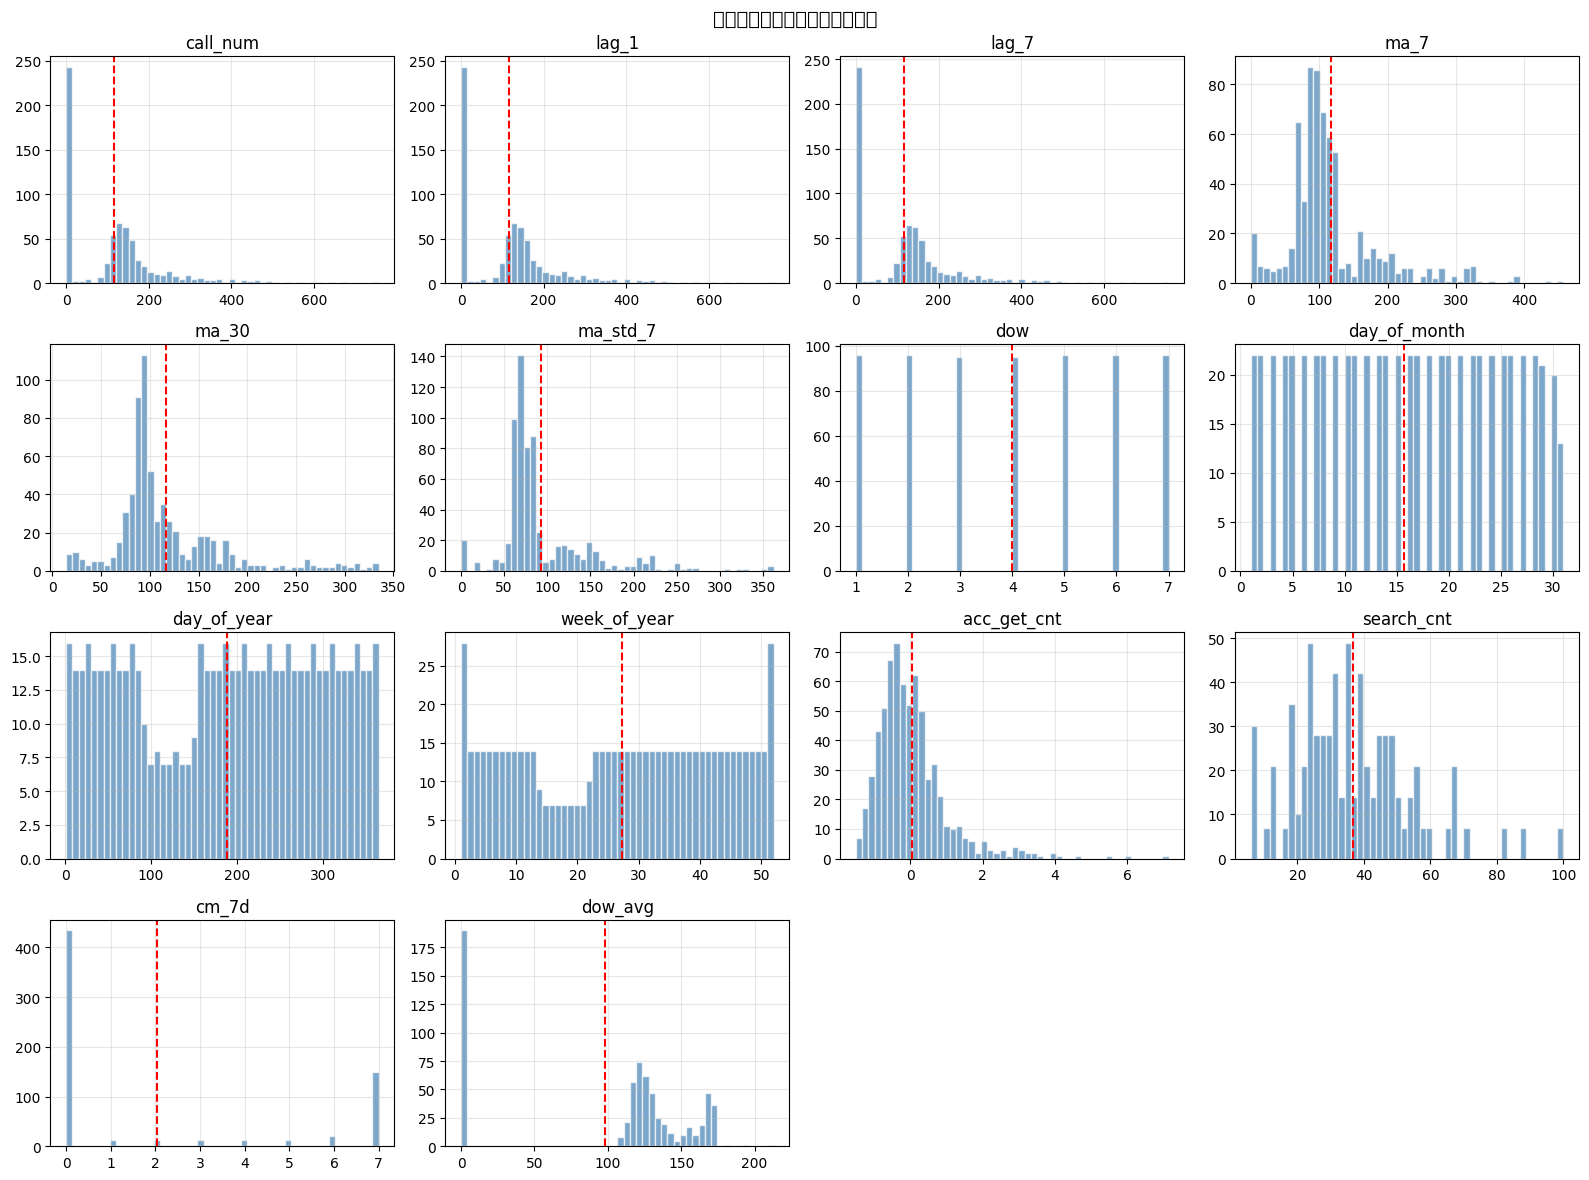

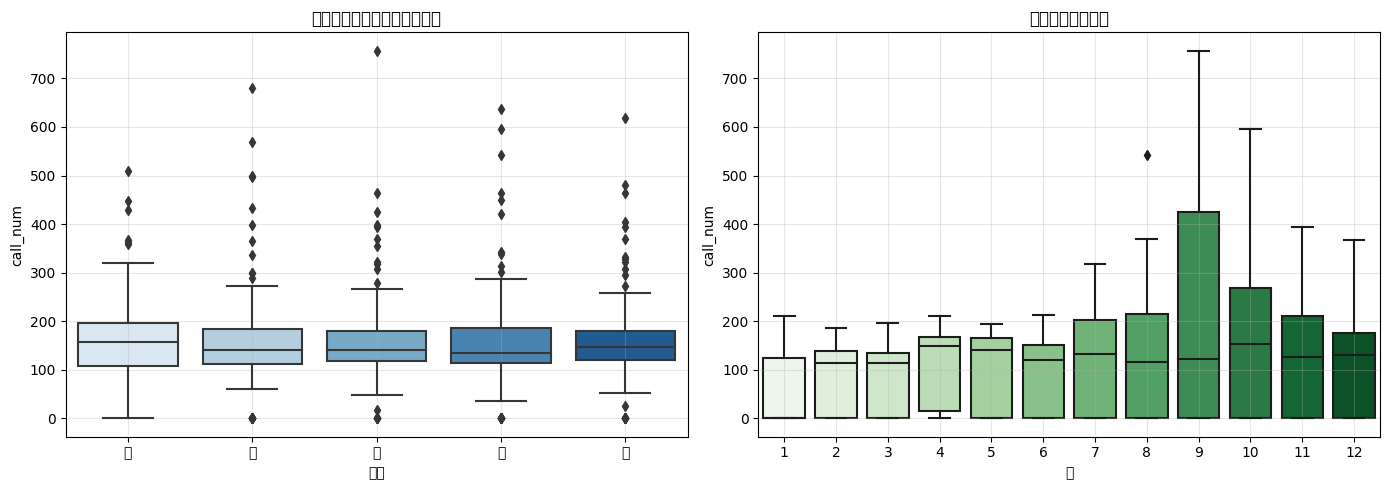

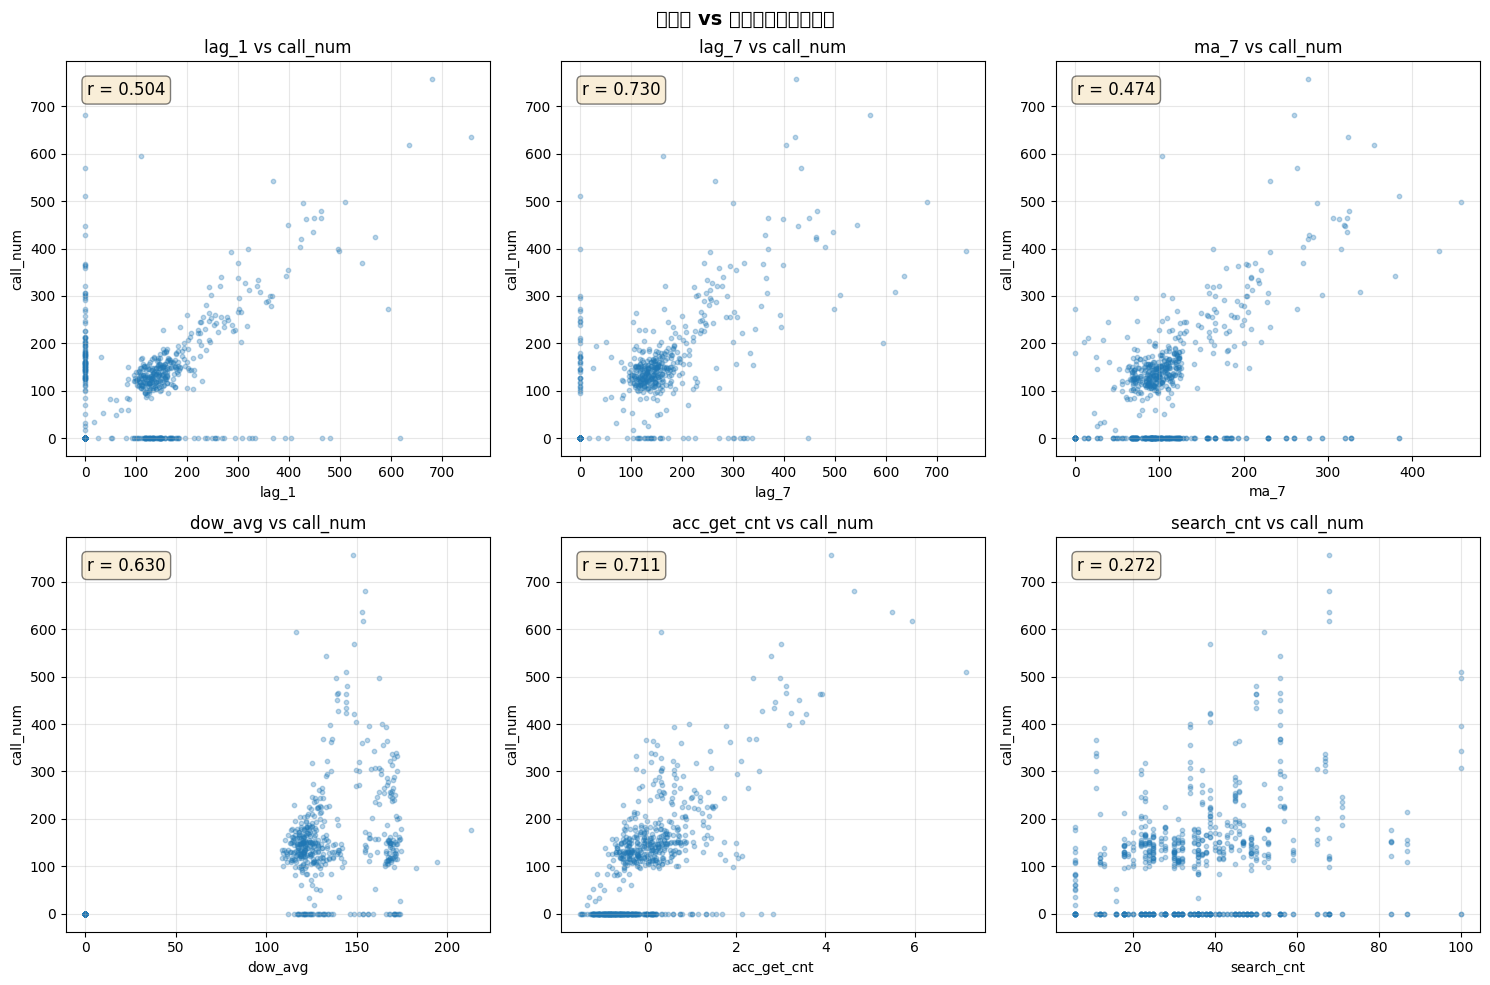

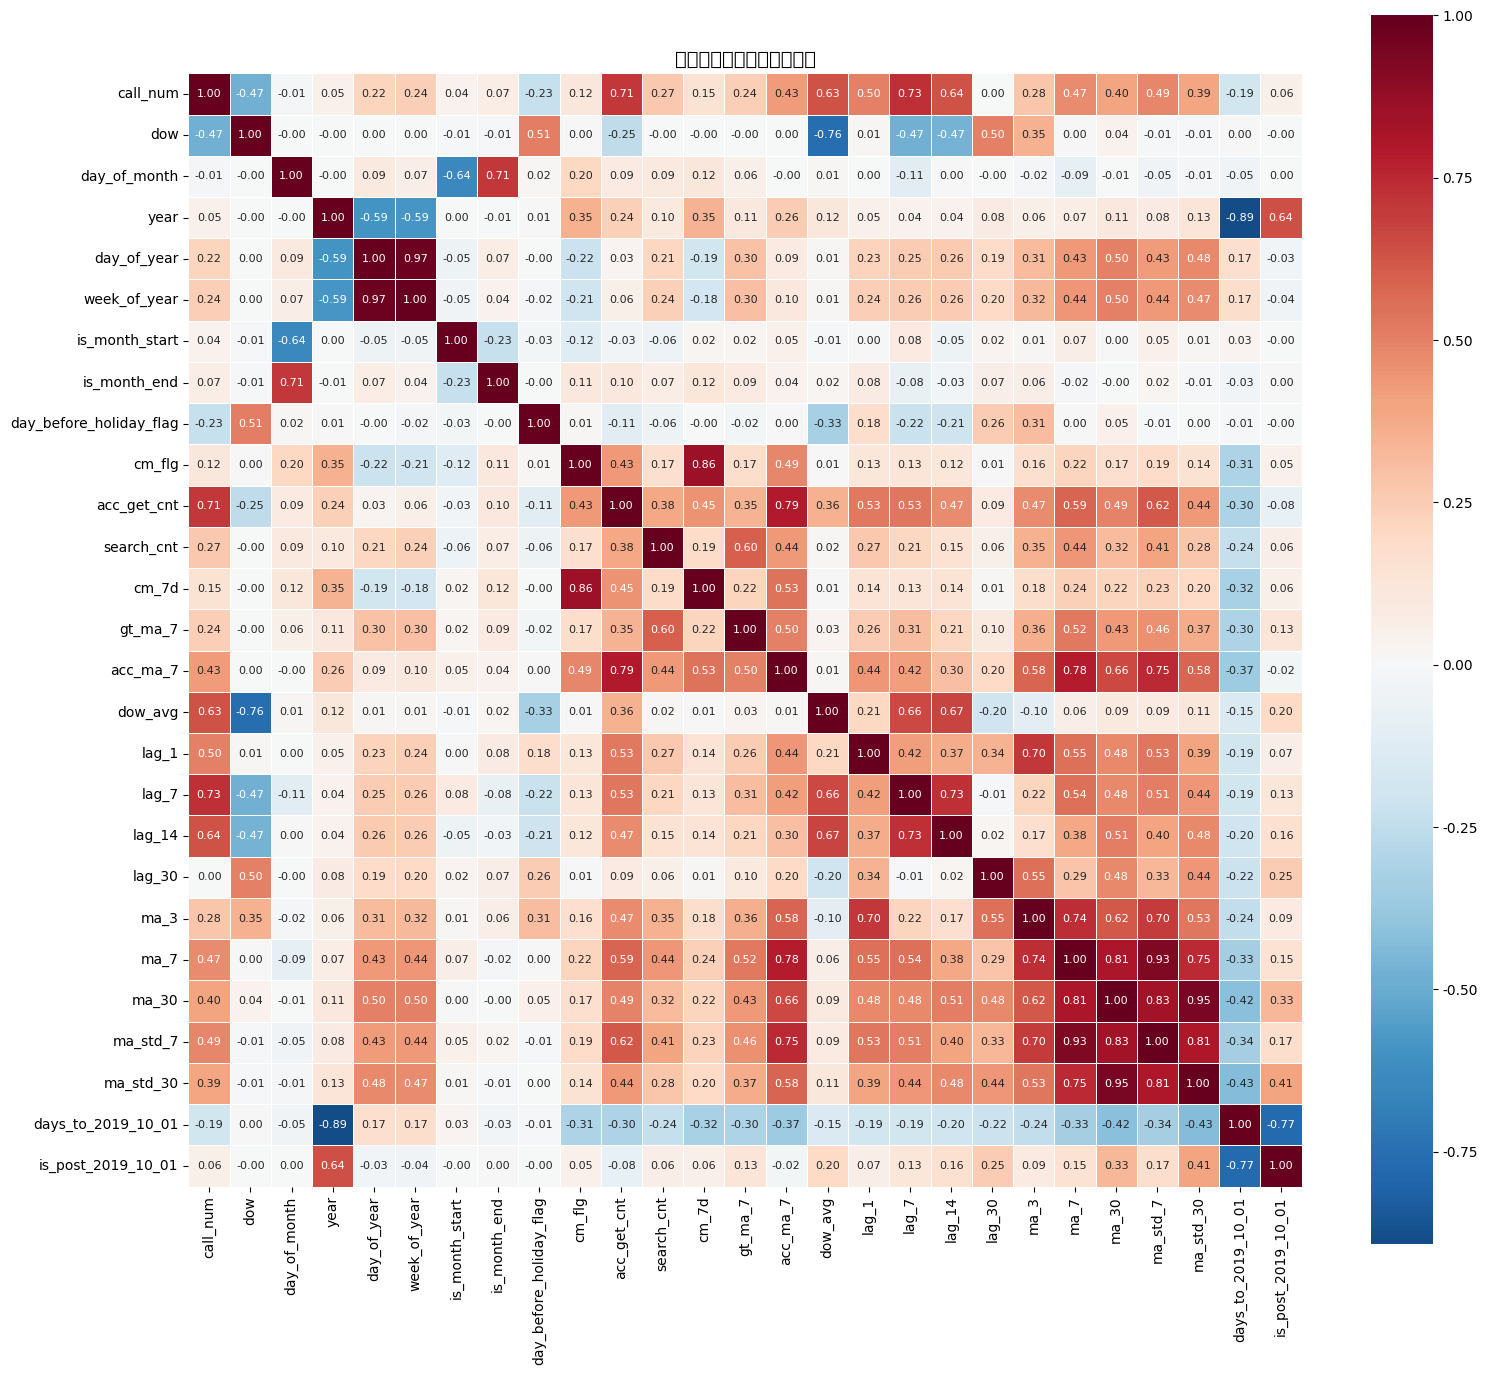

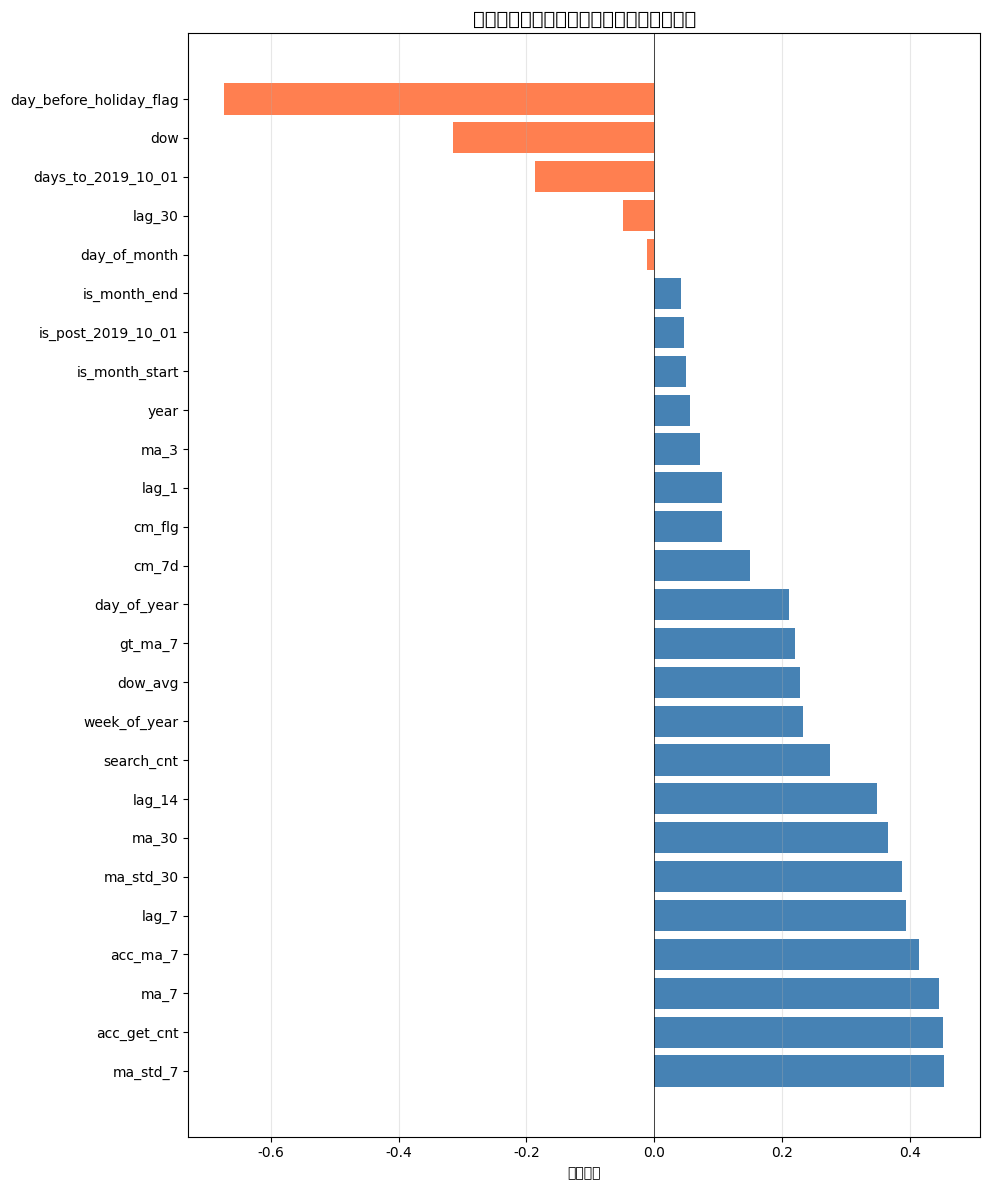


相関係数Top10:
              correlation
ma_std_7         0.453945
acc_get_cnt      0.452938
ma_7             0.445817
acc_ma_7         0.415179
lag_7            0.394305
ma_std_30        0.388484
ma_30            0.366252
lag_14           0.349548
search_cnt       0.274889
week_of_year     0.233125


ValueError: cannot insert cdr_date, already exists

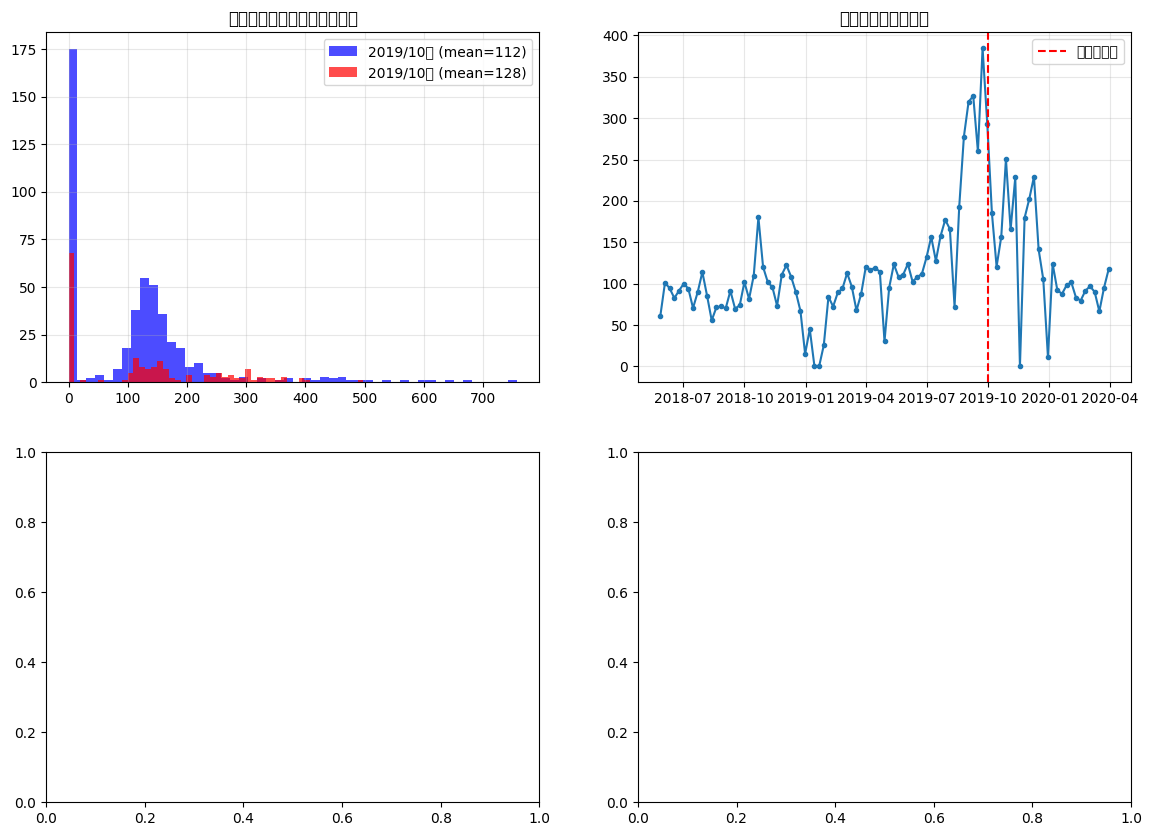

In [ ]:
# ==================================================================================
# 特徴量単体の可視化
# ==================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================================================================================
# データ読み込み・特徴量作成（exp22と同じ）
# ==================================================================================

def load_and_create_features():
    """exp22と同じデータ・特徴量を作成"""
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    # データ結合
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    # Google Trends週次→日次
    gt_daily = []
    for _, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    df = df.merge(pd.DataFrame(gt_daily), on='cdr_date', how='left')
    
    # 時系列特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    # ラグ特徴量
    for lag in [1, 2, 3, 5, 7, 14, 30]:
        df[f'lag_{lag}'] = df['call_num'].shift(lag)
    
    # 移動平均特徴量
    for window in [3, 7, 30]:
        df[f'ma_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df['call_num'].shift(1).rolling(window=window, min_periods=1).std()
    
    # 集約特徴量
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    # レジーム変化特徴量
    tax_date = pd.Timestamp('2019-10-01')
    df['days_to_2019_10_01'] = (tax_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= pd.Timestamp('2019-09-30')).astype(int)
    
    rush_start = pd.Timestamp('2019-09-30') - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= pd.Timestamp('2019-09-30'))).astype(int)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_date) & 
                                   (df['cdr_date'] <= tax_date + pd.Timedelta(days=30))).astype(int)
    
    # ターゲット
    df['target_next_day'] = df['call_num'].shift(-1)
    
    return df

df = load_and_create_features()
print(f"データ読み込み完了: {df.shape}")
print(f"期間: {df['cdr_date'].min()} ~ {df['cdr_date'].max()}")

# ==================================================================================
# 1. 時系列プロット（目的変数 + 主要特徴量）
# ==================================================================================

fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

# call_num（目的変数）
axes[0].plot(df['cdr_date'], df['call_num'], color='steelblue', linewidth=0.8)
axes[0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', label='消費税変更')
axes[0].set_ylabel('call_num')
axes[0].set_title('入電数（call_num）')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 移動平均
axes[1].plot(df['cdr_date'], df['ma_7'], label='MA7', linewidth=1)
axes[1].plot(df['cdr_date'], df['ma_30'], label='MA30', linewidth=1)
axes[1].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[1].set_ylabel('移動平均')
axes[1].set_title('移動平均（ma_7, ma_30）')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Google Trends
axes[2].plot(df['cdr_date'], df['search_cnt'], color='green', linewidth=0.8)
axes[2].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[2].set_ylabel('search_cnt')
axes[2].set_title('Google Trends（search_cnt）')
axes[2].grid(alpha=0.3)

# アカウント取得数
axes[3].plot(df['cdr_date'], df['acc_get_cnt'], color='purple', linewidth=0.8)
axes[3].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[3].set_ylabel('acc_get_cnt')
axes[3].set_title('アカウント取得数（acc_get_cnt）')
axes[3].grid(alpha=0.3)

# CM実施
axes[4].bar(df['cdr_date'], df['cm_flg'], color='orange', width=1)
axes[4].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[4].set_ylabel('cm_flg')
axes[4].set_title('CM実施（cm_flg）')
axes[4].grid(alpha=0.3)

plt.xlabel('日付')
plt.tight_layout()
plt.show()

# ==================================================================================
# 2. 特徴量の分布（ヒストグラム）
# ==================================================================================

# 可視化対象の特徴量
features_to_plot = [
    'call_num', 'lag_1', 'lag_7', 'ma_7', 'ma_30', 'ma_std_7',
    'dow', 'day_of_month', 'day_of_year', 'week_of_year',
    'acc_get_cnt', 'search_cnt', 'cm_7d', 'dow_avg'
]

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(features_to_plot):
    if feat in df.columns:
        data = df[feat].dropna()
        axes[i].hist(data, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        axes[i].set_title(feat)
        axes[i].set_xlabel('')
        axes[i].grid(alpha=0.3)
        
        # 基本統計量を表示
        mean_val = data.mean()
        std_val = data.std()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'mean={mean_val:.1f}')

# 余ったサブプロットを非表示
for j in range(len(features_to_plot), len(axes)):
    axes[j].axis('off')

plt.suptitle('特徴量の分布（ヒストグラム）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 3. 曜日別の入電数分布（箱ひげ図）
# ==================================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 曜日別（平日のみ）
df_weekday = df[df['dow'].isin([1, 2, 3, 4, 5])]
dow_labels = {1: '月', 2: '火', 3: '水', 4: '木', 5: '金'}
df_weekday['dow_label'] = df_weekday['dow'].map(dow_labels)

sns.boxplot(x='dow_label', y='call_num', data=df_weekday, ax=axes[0], 
            order=['月', '火', '水', '木', '金'], palette='Blues')
axes[0].set_title('曜日別の入電数分布（平日）')
axes[0].set_xlabel('曜日')
axes[0].set_ylabel('call_num')
axes[0].grid(alpha=0.3)

# 月別
sns.boxplot(x='month', y='call_num', data=df, ax=axes[1], palette='Greens')
axes[1].set_title('月別の入電数分布')
axes[1].set_xlabel('月')
axes[1].set_ylabel('call_num')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==================================================================================
# 4. 特徴量と目的変数の散布図
# ==================================================================================

scatter_features = ['lag_1', 'lag_7', 'ma_7', 'dow_avg', 'acc_get_cnt', 'search_cnt']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(scatter_features):
    if feat in df.columns:
        data = df[[feat, 'call_num']].dropna()
        axes[i].scatter(data[feat], data['call_num'], alpha=0.3, s=10)
        axes[i].set_xlabel(feat)
        axes[i].set_ylabel('call_num')
        axes[i].set_title(f'{feat} vs call_num')
        axes[i].grid(alpha=0.3)
        
        # 相関係数
        corr = data[feat].corr(data['call_num'])
        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes,
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('特徴量 vs 目的変数（散布図）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 5. 相関ヒートマップ
# ==================================================================================

# exp22の特徴量
feature_cols = [
    'call_num', 'dow', 'day_of_month', 'year', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end', 'day_before_holiday_flag',
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    'ma_3', 'ma_7', 'ma_30', 'ma_std_7', 'ma_std_30',
    'days_to_2019_10_01', 'is_post_2019_10_01'
]

# 存在する特徴量のみ
available_features = [f for f in feature_cols if f in df.columns]
corr_matrix = df[available_features].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, annot_kws={'size': 8})
plt.title('特徴量の相関ヒートマップ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 6. ターゲット（翌日入電数）との相関
# ==================================================================================

df_clean = df.dropna(subset=['target_next_day'])

correlations = {}
for feat in available_features:
    if feat in df_clean.columns and feat != 'call_num':
        corr = df_clean[feat].corr(df_clean['target_next_day'])
        correlations[feat] = corr

# ソートして表示
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', ascending=False)

plt.figure(figsize=(10, 12))
colors = ['steelblue' if x > 0 else 'coral' for x in corr_df['correlation']]
plt.barh(corr_df.index, corr_df['correlation'], color=colors)
plt.xlabel('相関係数')
plt.title('特徴量とターゲット（翌日入電数）の相関', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n相関係数Top10:")
print(corr_df.head(10).to_string())

# ==================================================================================
# 7. レジーム変化の可視化（消費税前後）
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 消費税前後の入電数
pre_tax = df[df['cdr_date'] < '2019-10-01']['call_num'].dropna()
post_tax = df[df['cdr_date'] >= '2019-10-01']['call_num'].dropna()

axes[0, 0].hist(pre_tax, bins=50, alpha=0.7, label=f'2019/10前 (mean={pre_tax.mean():.0f})', color='blue')
axes[0, 0].hist(post_tax, bins=50, alpha=0.7, label=f'2019/10後 (mean={post_tax.mean():.0f})', color='red')
axes[0, 0].set_title('消費税変更前後の入電数分布')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 週次推移
df_weekly = df.groupby(df['cdr_date'].dt.to_period('W'))['call_num'].mean().reset_index()
df_weekly['cdr_date'] = df_weekly['cdr_date'].dt.to_timestamp()
axes[0, 1].plot(df_weekly['cdr_date'], df_weekly['call_num'], marker='o', markersize=3)
axes[0, 1].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', label='消費税変更')
axes[0, 1].set_title('週平均入電数の推移')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 月別比較
monthly = df.groupby([df['cdr_date'].dt.year, df['cdr_date'].dt.month])['call_num'].mean()
monthly_df = monthly.reset_index()
monthly_df.columns = ['year', 'month', 'call_num']
monthly_df['year_month'] = monthly_df['year'].astype(str) + '-' + monthly_df['month'].astype(str).str.zfill(2)

colors = ['red' if y >= 2019 and m >= 10 else 'blue' for y, m in zip(monthly_df['year'], monthly_df['month'])]
axes[1, 0].bar(range(len(monthly_df)), monthly_df['call_num'], color=colors)
axes[1, 0].set_xticks(range(0, len(monthly_df), 3))
axes[1, 0].set_xticklabels(monthly_df['year_month'].iloc[::3], rotation=45)
axes[1, 0].set_title('月別平均入電数')
axes[1, 0].grid(alpha=0.3)

# 曜日×消費税前後
df_weekday_pre = df[(df['cdr_date'] < '2019-10-01') & (df['dow'].isin([1,2,3,4,5]))]
df_weekday_post = df[(df['cdr_date'] >= '2019-10-01') & (df['dow'].isin([1,2,3,4,5]))]

dow_pre = df_weekday_pre.groupby('dow')['call_num'].mean()
dow_post = df_weekday_post.groupby('dow')['call_num'].mean()

x = np.arange(5)
width = 0.35
axes[1, 1].bar(x - width/2, dow_pre.values, width, label='2019/10前', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, dow_post.values, width, label='2019/10後', color='red', alpha=0.7)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['月', '火', '水', '木', '金'])
axes[1, 1].set_title('曜日別平均入電数（消費税前後）')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ==================================================================================
# 加工されていない特徴量（元データ）の可視化
# ==================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================================================================================
# 1. 元データの読み込み（加工なし）
# ==================================================================================

call_data = pd.read_csv('../input/regi_call_data_transform.csv')
calender = pd.read_csv('../input/calender_data.csv')
cm_data = pd.read_csv('../input/cm_data.csv')
acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
gt_service = pd.read_csv('../input/gt_service_name.csv')

# 日付変換
call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
gt_service['week'] = pd.to_datetime(gt_service['week'])

print("=" * 60)
print("元データの概要")
print("=" * 60)
print(f"call_data:  {call_data.shape}  入電数")
print(f"calender:   {calender.shape}  カレンダー情報")
print(f"cm_data:    {cm_data.shape}  CM実施")
print(f"acc_get:    {acc_get.shape}  アカウント取得数")
print(f"gt_service: {gt_service.shape}  Google Trends（週次）")

# ==================================================================================
# 2. call_data（入電数）の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 時系列プロット
axes[0, 0].plot(call_data['cdr_date'], call_data['call_num'], linewidth=0.8, color='steelblue')
axes[0, 0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', alpha=0.7, label='2019/10/01')
axes[0, 0].set_title('call_num 時系列')
axes[0, 0].set_xlabel('日付')
axes[0, 0].set_ylabel('入電数')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# ヒストグラム
axes[0, 1].hist(call_data['call_num'], bins=50, color='steelblue', edgecolor='white')
axes[0, 1].axvline(call_data['call_num'].mean(), color='red', linestyle='--', label=f"mean={call_data['call_num'].mean():.1f}")
axes[0, 1].set_title('call_num 分布')
axes[0, 1].set_xlabel('入電数')
axes[0, 1].set_ylabel('頻度')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 基本統計量
stats = call_data['call_num'].describe()
axes[1, 0].axis('off')
stats_text = f"""
call_num 基本統計量
─────────────────
件数:   {stats['count']:.0f}
平均:   {stats['mean']:.1f}
標準偏差: {stats['std']:.1f}
最小:   {stats['min']:.0f}
25%:    {stats['25%']:.0f}
中央値:  {stats['50%']:.0f}
75%:    {stats['75%']:.0f}
最大:   {stats['max']:.0f}

ゼロの日: {(call_data['call_num'] == 0).sum()}日（休業日）
"""
axes[1, 0].text(0.1, 0.9, stats_text, transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 月別平均
monthly = call_data.groupby(call_data['cdr_date'].dt.to_period('M'))['call_num'].mean()
axes[1, 1].bar(range(len(monthly)), monthly.values, color='steelblue')
axes[1, 1].set_xticks(range(0, len(monthly), 3))
axes[1, 1].set_xticklabels([str(m) for m in monthly.index[::3]], rotation=45)
axes[1, 1].set_title('call_num 月別平均')
axes[1, 1].set_ylabel('平均入電数')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('call_data（入電数）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 3. calender（カレンダー情報）の可視化
# ==================================================================================

print("\ncalender カラム:")
print(calender.columns.tolist())
print("\n各カラムのユニーク値:")
for col in calender.columns:
    if col != 'cdr_date':
        print(f"  {col}: {calender[col].nunique()}種類 → {calender[col].unique()[:10]}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# dow（曜日）
dow_counts = calender['dow'].value_counts().sort_index()
axes[0, 0].bar(dow_counts.index, dow_counts.values, color='teal')
axes[0, 0].set_xticks([1, 2, 3, 4, 5, 6, 7])
axes[0, 0].set_xticklabels(['月', '火', '水', '木', '金', '土', '日'])
axes[0, 0].set_title('dow（曜日）の分布')
axes[0, 0].set_ylabel('日数')
axes[0, 0].grid(alpha=0.3)

# woy（週番号）
axes[0, 1].hist(calender['woy'], bins=53, color='teal', edgecolor='white')
axes[0, 1].set_title('woy（週番号）の分布')
axes[0, 1].set_xlabel('週番号')
axes[0, 1].grid(alpha=0.3)

# wom（月内週番号）
wom_counts = calender['wom'].value_counts().sort_index()
axes[0, 2].bar(wom_counts.index, wom_counts.values, color='teal')
axes[0, 2].set_title('wom（月内週番号）の分布')
axes[0, 2].set_xlabel('月内週番号')
axes[0, 2].grid(alpha=0.3)

# holiday_flag
holiday_counts = calender['holiday_flag'].value_counts()
axes[1, 0].bar(['平日(0)', '祝日(1)'], [holiday_counts.get(0, 0), holiday_counts.get(1, 0)], color=['steelblue', 'coral'])
axes[1, 0].set_title('holiday_flag の分布')
axes[1, 0].set_ylabel('日数')
axes[1, 0].grid(alpha=0.3)

# day_before_holiday_flag
dbh_counts = calender['day_before_holiday_flag'].value_counts()
axes[1, 1].bar(['通常(0)', '祝前日(1)'], [dbh_counts.get(0, 0), dbh_counts.get(1, 0)], color=['steelblue', 'coral'])
axes[1, 1].set_title('day_before_holiday_flag の分布')
axes[1, 1].set_ylabel('日数')
axes[1, 1].grid(alpha=0.3)

# holiday_name（欠損が多い）
holiday_names = calender['holiday_name'].dropna().value_counts().head(10)
axes[1, 2].barh(holiday_names.index, holiday_names.values, color='teal')
axes[1, 2].set_title('holiday_name（上位10）')
axes[1, 2].set_xlabel('日数')
axes[1, 2].invert_yaxis()

plt.suptitle('calender（カレンダー情報）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 4. cm_data（CM実施）の可視化
# ==================================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 時系列（棒グラフ）
axes[0].bar(cm_data['cdr_date'], cm_data['cm_flg'], width=1, color='orange')
axes[0].set_title('cm_flg 時系列')
axes[0].set_xlabel('日付')
axes[0].set_ylabel('CM実施')
axes[0].grid(alpha=0.3)

# 月別CM実施日数
cm_data['year_month'] = cm_data['cdr_date'].dt.to_period('M')
monthly_cm = cm_data.groupby('year_month')['cm_flg'].sum()
axes[1].bar(range(len(monthly_cm)), monthly_cm.values, color='orange')
axes[1].set_xticks(range(0, len(monthly_cm), 3))
axes[1].set_xticklabels([str(m) for m in monthly_cm.index[::3]], rotation=45)
axes[1].set_title('月別CM実施日数')
axes[1].set_ylabel('CM実施日数')
axes[1].grid(alpha=0.3)

# 基本情報
axes[2].axis('off')
cm_info = f"""
cm_data 基本情報
─────────────────
総日数:     {len(cm_data)}日
CM実施日:   {cm_data['cm_flg'].sum()}日
CM実施率:   {cm_data['cm_flg'].mean()*100:.1f}%

期間: {cm_data['cdr_date'].min().date()} 
    ~ {cm_data['cdr_date'].max().date()}
"""
axes[2].text(0.1, 0.9, cm_info, transform=axes[2].transAxes, 
             fontsize=12, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('cm_data（CM実施）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 5. acc_get（アカウント取得数）の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 時系列
axes[0, 0].plot(acc_get['cdr_date'], acc_get['acc_get_cnt'], linewidth=0.8, color='purple')
axes[0, 0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', alpha=0.7)
axes[0, 0].axhline(0, color='gray', linestyle='-', alpha=0.5)
axes[0, 0].set_title('acc_get_cnt 時系列')
axes[0, 0].set_xlabel('日付')
axes[0, 0].set_ylabel('acc_get_cnt')
axes[0, 0].grid(alpha=0.3)

# ヒストグラム
axes[0, 1].hist(acc_get['acc_get_cnt'], bins=50, color='purple', edgecolor='white')
axes[0, 1].axvline(0, color='red', linestyle='--', label='0')
axes[0, 1].axvline(acc_get['acc_get_cnt'].mean(), color='orange', linestyle='--', label=f"mean={acc_get['acc_get_cnt'].mean():.2f}")
axes[0, 1].set_title('acc_get_cnt 分布')
axes[0, 1].set_xlabel('acc_get_cnt')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 基本統計量
stats = acc_get['acc_get_cnt'].describe()
axes[1, 0].axis('off')
stats_text = f"""
acc_get_cnt 基本統計量
─────────────────────
件数:   {stats['count']:.0f}
平均:   {stats['mean']:.4f}
標準偏差: {stats['std']:.4f}
最小:   {stats['min']:.4f}
25%:    {stats['25%']:.4f}
中央値:  {stats['50%']:.4f}
75%:    {stats['75%']:.4f}
最大:   {stats['max']:.4f}

※ 正規化済みデータ（Zスコア変換と思われる）
  平均≒0、標準偏差≒1
"""
axes[1, 0].text(0.1, 0.9, stats_text, transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 月別平均
monthly = acc_get.groupby(acc_get['cdr_date'].dt.to_period('M'))['acc_get_cnt'].mean()
colors = ['red' if v > 0 else 'blue' for v in monthly.values]
axes[1, 1].bar(range(len(monthly)), monthly.values, color=colors)
axes[1, 1].axhline(0, color='black', linewidth=0.5)
axes[1, 1].set_xticks(range(0, len(monthly), 3))
axes[1, 1].set_xticklabels([str(m) for m in monthly.index[::3]], rotation=45)
axes[1, 1].set_title('acc_get_cnt 月別平均')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('acc_get（アカウント取得数）※正規化済み', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 6. gt_service（Google Trends）の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 時系列（週次）
axes[0, 0].plot(gt_service['week'], gt_service['search_cnt'], marker='o', markersize=3, linewidth=1, color='green')
axes[0, 0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('search_cnt 時系列（週次）')
axes[0, 0].set_xlabel('週')
axes[0, 0].set_ylabel('search_cnt')
axes[0, 0].grid(alpha=0.3)

# ヒストグラム
axes[0, 1].hist(gt_service['search_cnt'], bins=30, color='green', edgecolor='white')
axes[0, 1].axvline(gt_service['search_cnt'].mean(), color='red', linestyle='--', label=f"mean={gt_service['search_cnt'].mean():.1f}")
axes[0, 1].set_title('search_cnt 分布')
axes[0, 1].set_xlabel('search_cnt')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 基本統計量
stats = gt_service['search_cnt'].describe()
axes[1, 0].axis('off')
stats_text = f"""
search_cnt 基本統計量（週次データ）
──────────────────────────────
件数:   {stats['count']:.0f}週
平均:   {stats['mean']:.1f}
標準偏差: {stats['std']:.1f}
最小:   {stats['min']:.0f}
25%:    {stats['25%']:.0f}
中央値:  {stats['50%']:.0f}
75%:    {stats['75%']:.0f}
最大:   {stats['max']:.0f}

期間: {gt_service['week'].min().date()} 
    ~ {gt_service['week'].max().date()}
"""
axes[1, 0].text(0.1, 0.9, stats_text, transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 年別の推移
gt_service['year'] = gt_service['week'].dt.year
for year in gt_service['year'].unique():
    yearly = gt_service[gt_service['year'] == year]
    axes[1, 1].plot(yearly['week'].dt.isocalendar().week, yearly['search_cnt'], 
                    marker='o', markersize=2, label=str(year))
axes[1, 1].set_title('search_cnt 年別推移（週番号）')
axes[1, 1].set_xlabel('週番号')
axes[1, 1].set_ylabel('search_cnt')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('gt_service（Google Trends）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 7. 全データの時系列比較（1画面で）
# ==================================================================================

fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

# call_num
axes[0].plot(call_data['cdr_date'], call_data['call_num'], linewidth=0.8, color='steelblue')
axes[0].set_ylabel('call_num')
axes[0].set_title('入電数')
axes[0].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[0].grid(alpha=0.3)

# dow（曜日）- calenderから
cal_merged = calender.copy()
axes[1].scatter(cal_merged['cdr_date'], cal_merged['dow'], s=2, c=cal_merged['dow'], cmap='tab10')
axes[1].set_ylabel('dow')
axes[1].set_title('曜日（1=月〜7=日）')
axes[1].set_yticks([1, 2, 3, 4, 5, 6, 7])
axes[1].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[1].grid(alpha=0.3)

# cm_flg
axes[2].bar(cm_data['cdr_date'], cm_data['cm_flg'], width=1, color='orange')
axes[2].set_ylabel('cm_flg')
axes[2].set_title('CM実施')
axes[2].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[2].grid(alpha=0.3)

# acc_get_cnt
axes[3].plot(acc_get['cdr_date'], acc_get['acc_get_cnt'], linewidth=0.8, color='purple')
axes[3].axhline(0, color='gray', linestyle='-', alpha=0.5)
axes[3].set_ylabel('acc_get_cnt')
axes[3].set_title('アカウント取得数（正規化済み）')
axes[3].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[3].grid(alpha=0.3)

# search_cnt（週次なのでステップ表示）
axes[4].step(gt_service['week'], gt_service['search_cnt'], where='post', linewidth=1, color='green')
axes[4].set_ylabel('search_cnt')
axes[4].set_title('Google Trends（週次）')
axes[4].set_xlabel('日付')
axes[4].axvline(pd.Timestamp('2019-10-01'), color='red', linestyle='--')
axes[4].grid(alpha=0.3)

plt.suptitle('元データ（加工前）の時系列比較', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================================================================================
# 8. 各データの概要表示
# ==================================================================================

print("=" * 80)
print("元データ（加工前）のサマリー")
print("=" * 80)

print("\n【1. call_data】入電数")
print(call_data.describe())

print("\n【2. calender】カレンダー情報")
print(calender.dtypes)
print(calender.head())

print("\n【3. cm_data】CM実施")
print(cm_data.describe())

print("\n【4. acc_get】アカウント取得数（正規化済み）")
print(acc_get.describe())

print("\n【5. gt_service】Google Trends（週次）")
print(gt_service.describe())

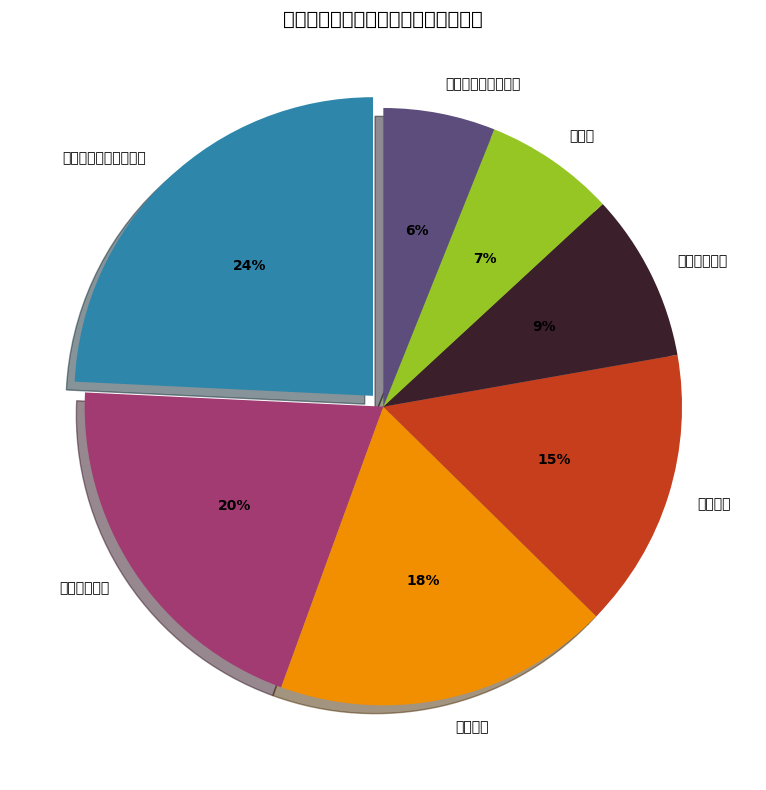

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# 日本語フォント設定（Windows用）
plt.rcParams['font.family'] = 'MS Gothic'
# または以下を試してください
# plt.rcParams['font.family'] = 'Meiryo'
# plt.rcParams['font.family'] = 'Yu Gothic'

plt.rcParams['axes.unicode_minus'] = False

# データ
factors = [
    '電話のつながりやすさ',
    '応対の丁寧さ',
    '製品知識',
    '対応時間',
    '情報の適切さ',
    '理解力',
    '説明のわかりやすさ'
]

percentages = [24, 20, 18, 15, 9, 7, 6]

# 色

# 円グラフ
fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(
    percentages,
    labels=factors,
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    explode=[0.05, 0, 0, 0, 0, 0, 0],
    shadow=True
)

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.set_title('顧客満足度に影響を与えるファクター', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.font_manager as fm

# 利用可能な日本語フォントを確認
jp_fonts = [f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name or 'Meiryo' in f.name or 'Yu' in f.name]
print("利用可能な日本語フォント:")
for f in set(jp_fonts):
    print(f"  {f}")

# 見つかったフォント名を使用
# plt.rcParams['font.family'] = '見つかったフォント名'


利用可能な日本語フォント:
  URW Gothic


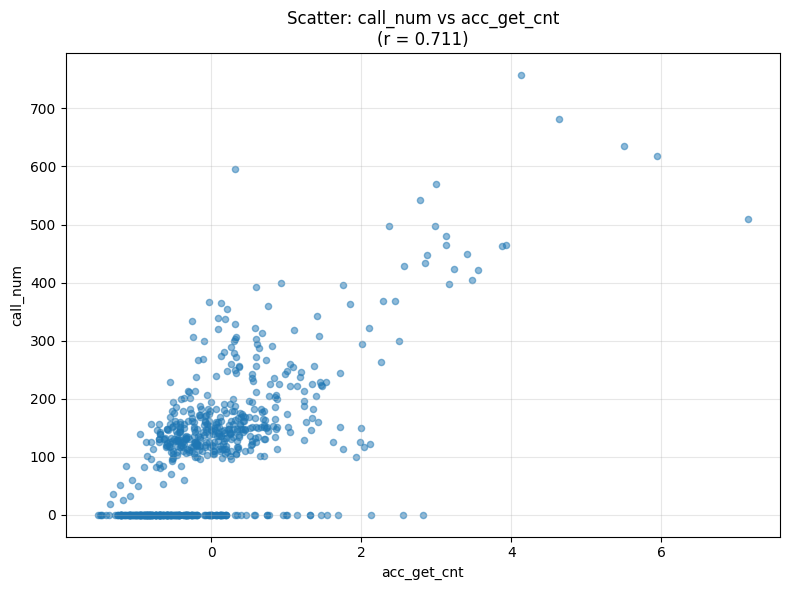

In [ ]:
# =============================================================================
# Scatter plot: call_num vs acc_get_cnt
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
acc_df = pd.read_csv('../input/regi_acc_get_data_transform.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
acc_df['cdr_date'] = pd.to_datetime(acc_df['cdr_date'])
corr_df = call_df.merge(acc_df, on='cdr_date', how='inner')

# プロット
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(corr_df['acc_get_cnt'], corr_df['call_num'], alpha=0.5, s=20)
ax.set_xlabel('acc_get_cnt')
ax.set_ylabel('call_num')
ax.set_title(f'Scatter: call_num vs acc_get_cnt\n(r = {corr_df["call_num"].corr(corr_df["acc_get_cnt"]):.3f})')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Total records: 670
CM=0 days: 471
CM=1 days: 199

平均入電数:
  CM無し: 107.3
  CM有り: 138.3


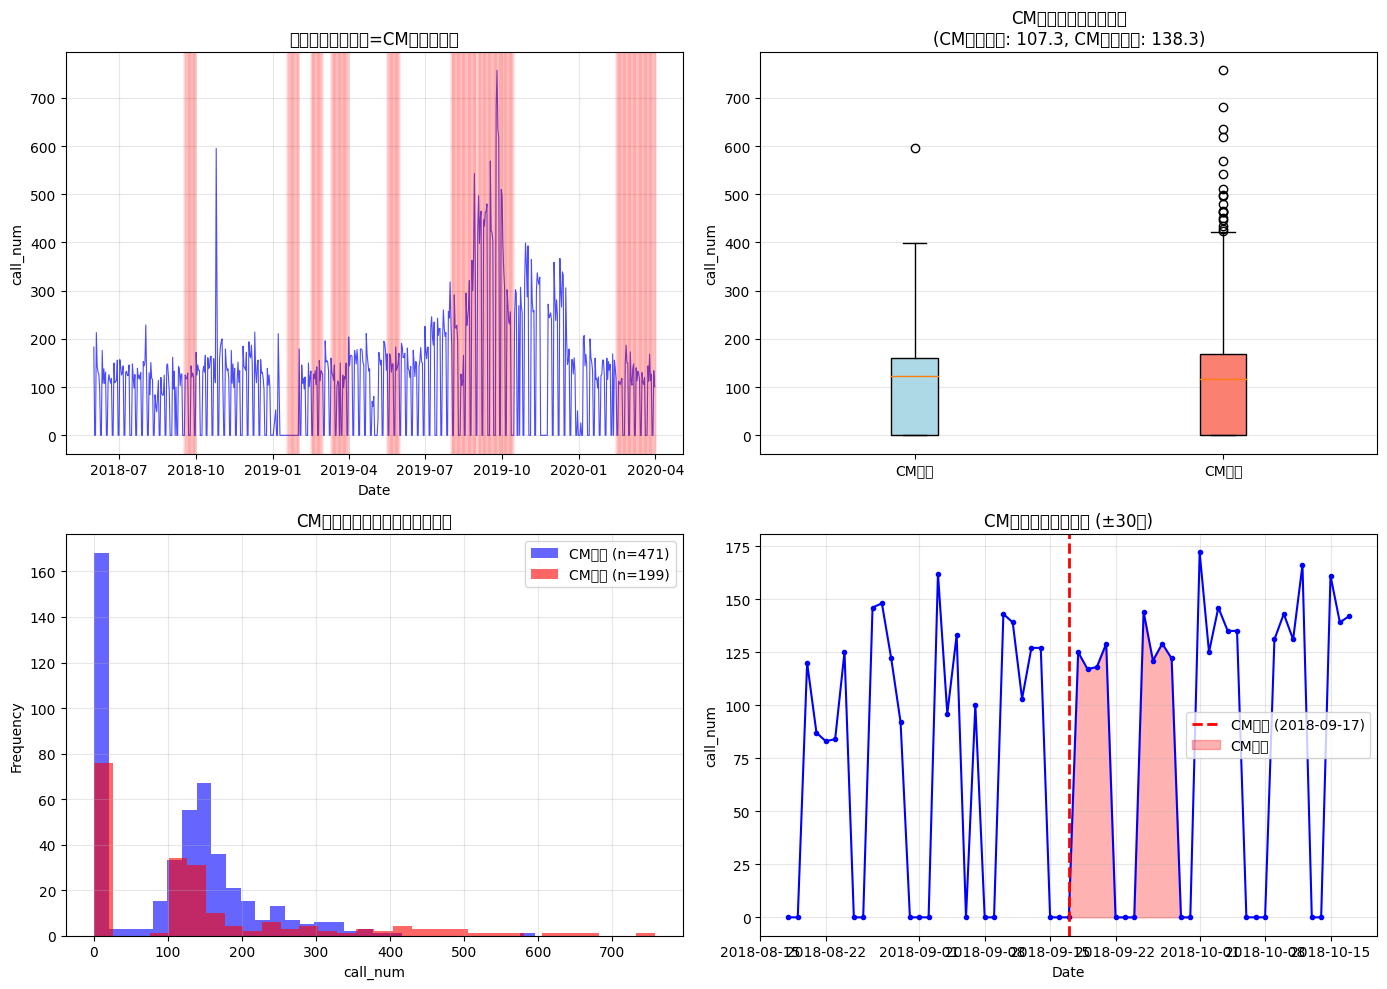


[t検定結果]
  t統計量: -3.077
  p値: 0.0022
  結論: 有意差あり (p<0.05)


In [ ]:
# =============================================================================
# 入電数 vs CM放送の関係
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])

# マージ
df = call_df.merge(cm_df, on='cdr_date', how='inner')

print(f"Total records: {len(df)}")
print(f"CM=0 days: {(df['cm_flg']==0).sum()}")
print(f"CM=1 days: {(df['cm_flg']==1).sum()}")
print(f"\n平均入電数:")
print(f"  CM無し: {df[df['cm_flg']==0]['call_num'].mean():.1f}")
print(f"  CM有り: {df[df['cm_flg']==1]['call_num'].mean():.1f}")

# プロット
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 時系列 + CM期間ハイライト
ax = axes[0, 0]
ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.set_title('入電数の推移（赤=CM放送期間）')
ax.grid(alpha=0.3)

# 2. CM有無別の箱ひげ図
ax = axes[0, 1]
cm0 = df[df['cm_flg'] == 0]['call_num']
cm1 = df[df['cm_flg'] == 1]['call_num']
bp = ax.boxplot([cm0, cm1], labels=['CM無し', 'CM有り'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('salmon')
ax.set_ylabel('call_num')
ax.set_title(f'CM有無別の入電数分布\n(CM無し平均: {cm0.mean():.1f}, CM有り平均: {cm1.mean():.1f})')
ax.grid(alpha=0.3, axis='y')

# 3. CM有無別のヒストグラム
ax = axes[1, 0]
ax.hist(cm0, bins=30, alpha=0.6, label=f'CM無し (n={len(cm0)})', color='blue')
ax.hist(cm1, bins=30, alpha=0.6, label=f'CM有り (n={len(cm1)})', color='red')
ax.set_xlabel('call_num')
ax.set_ylabel('Frequency')
ax.set_title('CM有無別の入電数ヒストグラム')
ax.legend()
ax.grid(alpha=0.3)

# 4. CM開始前後の入電数変化
ax = axes[1, 1]
# CM開始日を特定
df_sorted = df.sort_values('cdr_date').reset_index(drop=True)
df_sorted['cm_change'] = df_sorted['cm_flg'].diff()
cm_start_dates = df_sorted[df_sorted['cm_change'] == 1]['cdr_date'].tolist()

if cm_start_dates:
    # 最初のCM開始日前後30日を表示
    cm_start = cm_start_dates[0]
    window = pd.Timedelta(days=30)
    mask = (df_sorted['cdr_date'] >= cm_start - window) & (df_sorted['cdr_date'] <= cm_start + window)
    window_df = df_sorted[mask]
    
    ax.plot(window_df['cdr_date'], window_df['call_num'], 'b-o', markersize=3)
    ax.axvline(cm_start, color='red', linestyle='--', linewidth=2, label=f'CM開始 ({cm_start.strftime("%Y-%m-%d")})')
    ax.fill_between(window_df['cdr_date'], 0, window_df['call_num'], 
                    where=window_df['cm_flg']==1, alpha=0.3, color='red', label='CM期間')
    ax.set_xlabel('Date')
    ax.set_ylabel('call_num')
    ax.set_title(f'CM開始前後の入電数 (±30日)')
    ax.legend()
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'CM開始日が見つかりません', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../output/sim_outputs/call_vs_cm.png', dpi=150, bbox_inches='tight')
plt.show()

# 統計検定
from scipy import stats
t_stat, p_value = stats.ttest_ind(cm0, cm1)
print(f"\n[t検定結果]")
print(f"  t統計量: {t_stat:.3f}")
print(f"  p値: {p_value:.4f}")
print(f"  結論: {'有意差あり (p<0.05)' if p_value < 0.05 else '有意差なし (p>=0.05)'}")


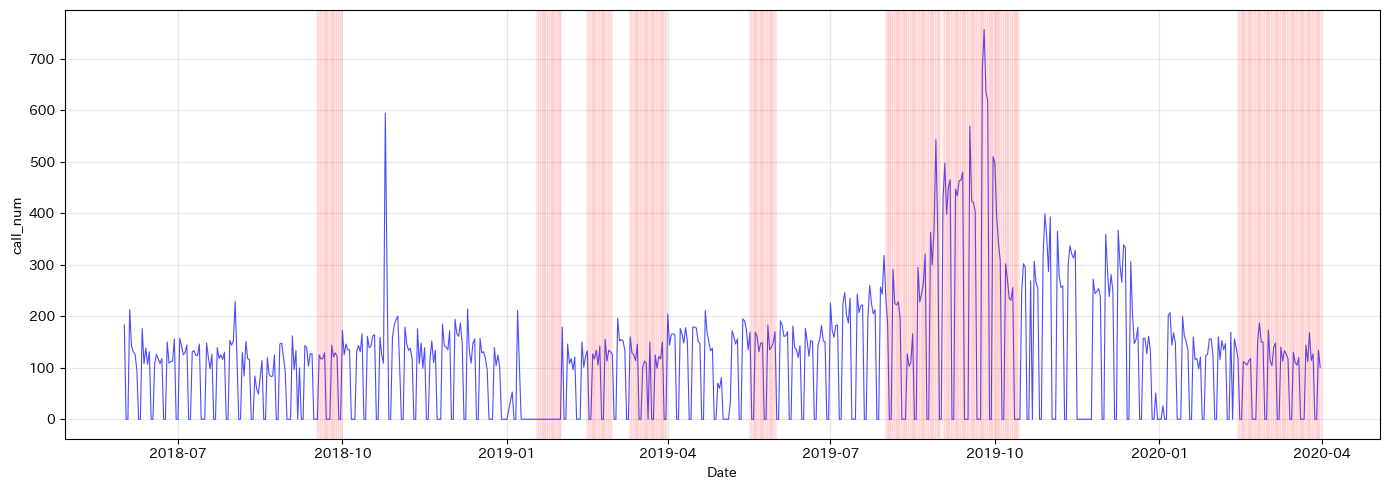

In [ ]:
# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# プロット
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
# ax.set_title('入電数の推移（赤=CM放送期間）')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


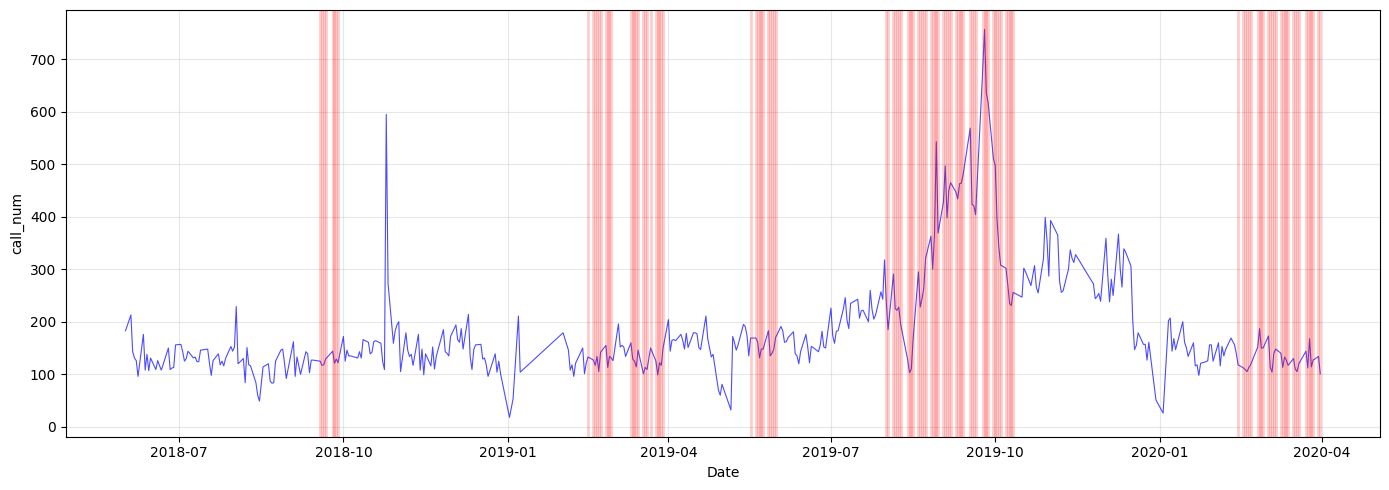

In [ ]:
# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# 日本語フォント設定
plt.rcParams['font.family'] = 'MS Gothic'  # Windows
# plt.rcParams['font.family'] = 'Hiragino Sans'  # Mac
# plt.rcParams['font.family'] = 'IPAexGothic'  # Linux
plt.rcParams['axes.unicode_minus'] = False

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# プロット
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト（alpha を 0.1 に下げて薄く）
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.2, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
# ax.set_title('入電数の推移（赤=CM放送期間）')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


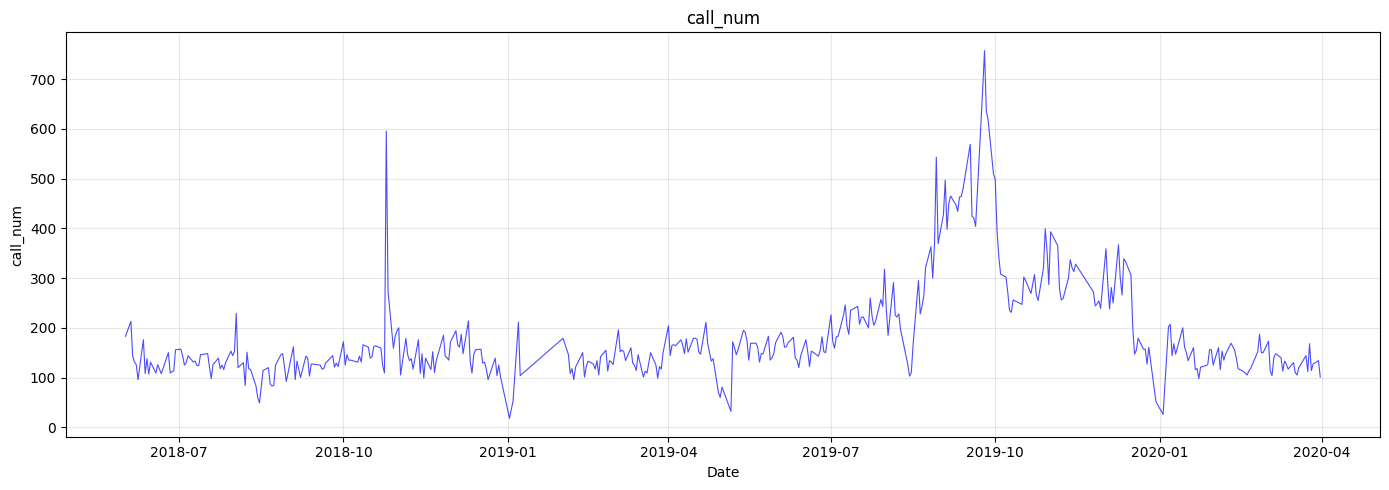

In [ ]:
# =============================================================================
# 入電数の時系列
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])

# call_num が 0 の日を除外
call_df = call_df[call_df['call_num'] > 0]

# プロット
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(call_df['cdr_date'], call_df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.set_title('call_num')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


[CM無し] 日数: 304, 平均: 166.2, 中央値: 150.5
[CM有り] 日数: 123, 平均: 223.7, 中央値: 148.0

差分: 57.5 (34.6%)


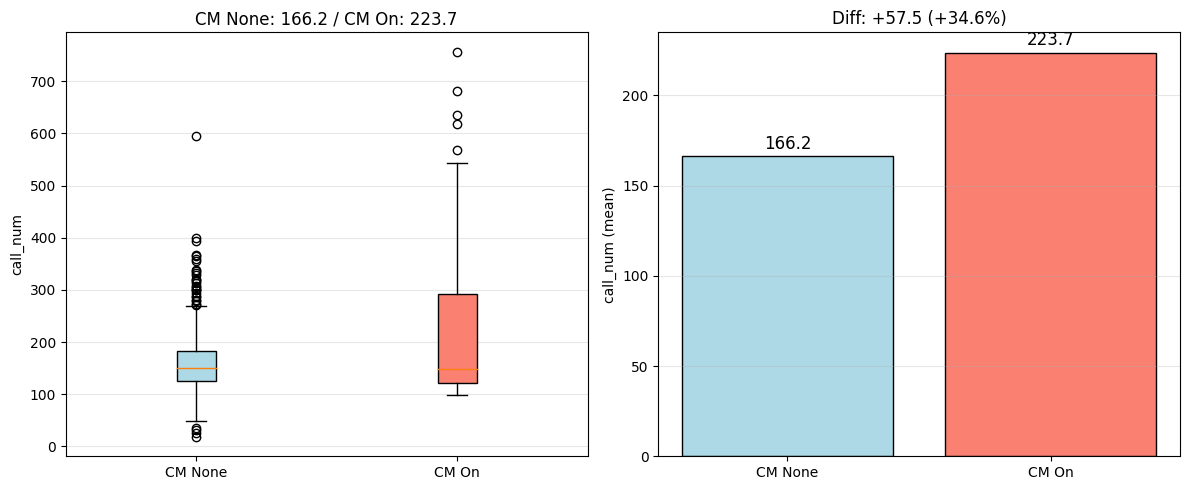

In [ ]:
# =============================================================================
# CM有無による入電数の比較
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# CM有無で分割
cm0 = df[df['cm_flg'] == 0]['call_num']
cm1 = df[df['cm_flg'] == 1]['call_num']

# 統計量
print(f"[CM無し] 日数: {len(cm0)}, 平均: {cm0.mean():.1f}, 中央値: {cm0.median():.1f}")
print(f"[CM有り] 日数: {len(cm1)}, 平均: {cm1.mean():.1f}, 中央値: {cm1.median():.1f}")
print(f"\n差分: {cm1.mean() - cm0.mean():.1f} ({(cm1.mean() - cm0.mean()) / cm0.mean() * 100:.1f}%)")

# プロット
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 箱ひげ図
ax = axes[0]
bp = ax.boxplot([cm0, cm1], labels=['CM None', 'CM On'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('salmon')
ax.set_ylabel('call_num')
ax.set_title(f'CM None: {cm0.mean():.1f} / CM On: {cm1.mean():.1f}')
ax.grid(alpha=0.3, axis='y')

# 2. 棒グラフ（平均値比較）
ax = axes[1]
means = [cm0.mean(), cm1.mean()]
bars = ax.bar(['CM None', 'CM On'], means, color=['lightblue', 'salmon'], edgecolor='black')
ax.set_ylabel('call_num (mean)')
ax.set_title(f'Diff: +{cm1.mean() - cm0.mean():.1f} (+{(cm1.mean() - cm0.mean()) / cm0.mean() * 100:.1f}%)')
ax.grid(alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{mean:.1f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


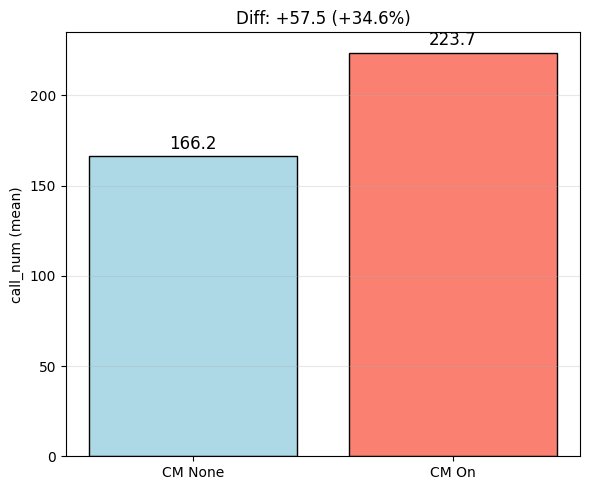

In [ ]:
# =============================================================================
# CM有無による入電数の比較（棒グラフ）
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# CM有無で分割
cm0 = df[df['cm_flg'] == 0]['call_num']
cm1 = df[df['cm_flg'] == 1]['call_num']

# プロット
fig, ax = plt.subplots(figsize=(6, 5))

means = [cm0.mean(), cm1.mean()]
bars = ax.bar(['CM None', 'CM On'], means, color=['lightblue', 'salmon'], edgecolor='black')
ax.set_ylabel('call_num (mean)')
ax.set_title(f'Diff: +{cm1.mean() - cm0.mean():.1f} (+{(cm1.mean() - cm0.mean()) / cm0.mean() * 100:.1f}%)')
ax.grid(alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{mean:.1f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


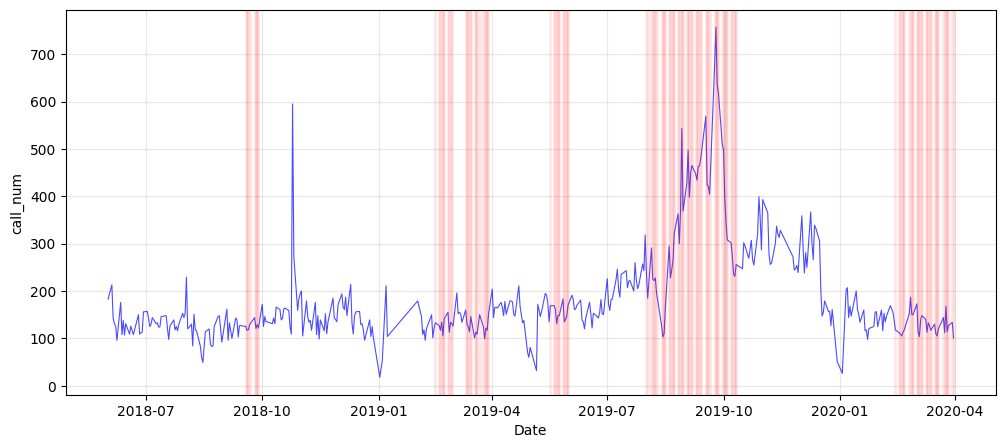

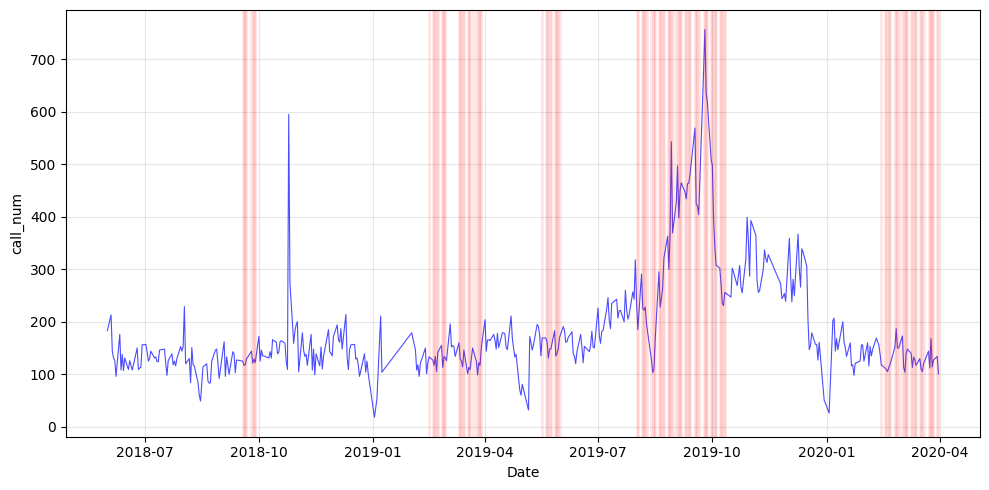

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# プロット（横幅を12に変更）
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.grid(alpha=0.3)# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# プロット（横幅を10に変更）
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


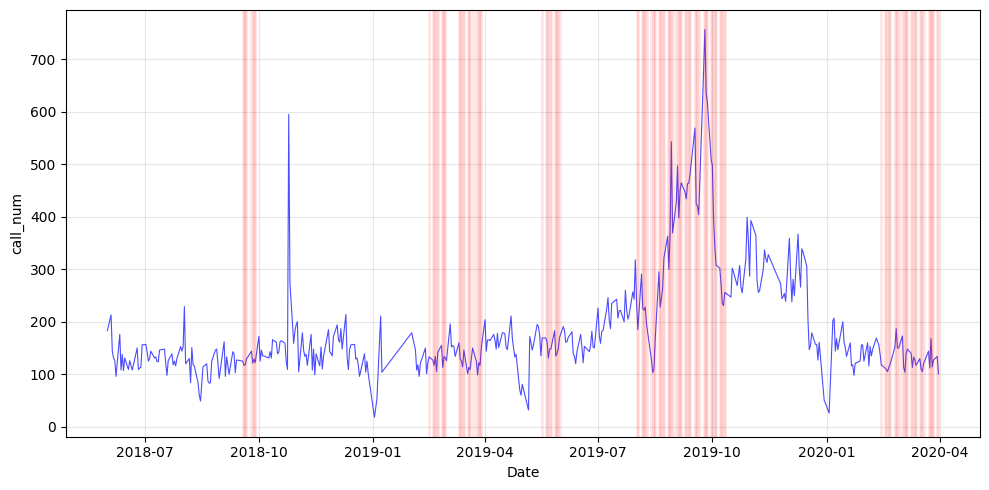

In [ ]:
# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# プロット（横幅を10に変更）
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8)
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
for date in cm_periods:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# サンプル数
print(f"CM無し: {(df['cm_flg'] == 0).sum()} 日")
print(f"CM有り: {(df['cm_flg'] == 1).sum()} 日")


CM無し: 304 日
CM有り: 123 日


In [ ]:
import pandas as pd

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# サンプル数（0日を除外しない）
print(f"全日数: {len(df)} 日")
print(f"CM無し: {(df['cm_flg'] == 0).sum()} 日")
print(f"CM有り: {(df['cm_flg'] == 1).sum()} 日")

# 期間確認
print(f"\nデータ期間: {df['cdr_date'].min().date()} ~ {df['cdr_date'].max().date()}")


全日数: 670 日
CM無し: 471 日
CM有り: 199 日

データ期間: 2018-06-01 ~ 2020-03-31


[CM無し] 日数: 471, 平均: 107.3
[CM有り] 日数: 199, 平均: 138.3

差分: 31.0 (28.9%)


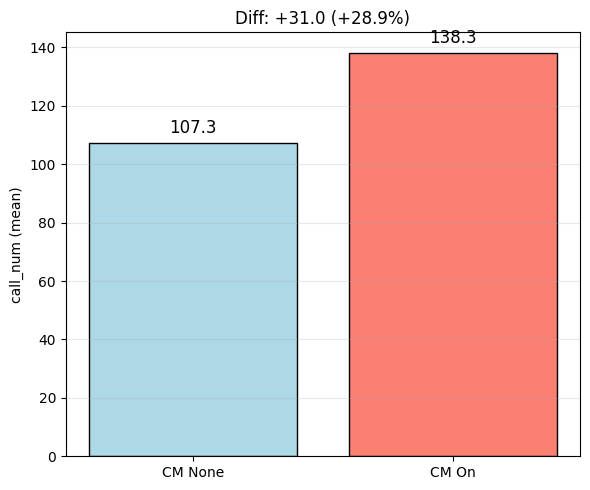

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# 0日を除外しない
cm0 = df[df['cm_flg'] == 0]['call_num']
cm1 = df[df['cm_flg'] == 1]['call_num']

# 統計量
print(f"[CM無し] 日数: {len(cm0)}, 平均: {cm0.mean():.1f}")
print(f"[CM有り] 日数: {len(cm1)}, 平均: {cm1.mean():.1f}")
print(f"\n差分: {cm1.mean() - cm0.mean():.1f} ({(cm1.mean() - cm0.mean()) / cm0.mean() * 100:.1f}%)")

# プロット
fig, ax = plt.subplots(figsize=(6, 5))

means = [cm0.mean(), cm1.mean()]
bars = ax.bar(['CM None', 'CM On'], means, color=['lightblue', 'salmon'], edgecolor='black')
ax.set_ylabel('call_num (mean)')
ax.set_title(f'Diff: +{cm1.mean() - cm0.mean():.1f} (+{(cm1.mean() - cm0.mean()) / cm0.mean() * 100:.1f}%)')
ax.grid(alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{mean:.1f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


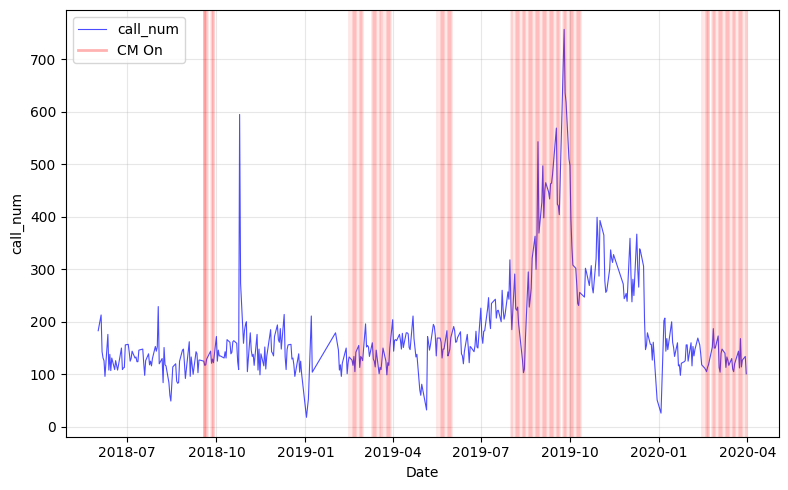

In [ ]:
# =============================================================================
# 時系列 + CM期間ハイライト
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
cm_df = pd.read_csv('../input/cm_data.csv')

# 日付変換・マージ
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
cm_df['cdr_date'] = pd.to_datetime(cm_df['cdr_date'])
df = call_df.merge(cm_df, on='cdr_date', how='inner')

# call_num が 0 の日を除外
df = df[df['call_num'] > 0]

# プロット（横幅を8に変更）
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df['cdr_date'], df['call_num'], 'b-', alpha=0.7, linewidth=0.8, label='call_num')
# CM期間を背景色でハイライト
cm_periods = df[df['cm_flg'] == 1]['cdr_date']
ax.axvline(cm_periods.iloc[0], color='red', alpha=0.3, linewidth=2, label='CM On')  # 凡例用
for date in cm_periods[1:]:
    ax.axvline(date, color='red', alpha=0.1, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('call_num')
ax.grid(alpha=0.3)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


day_before_holiday_flag
False    450
True     220
Name: count, dtype: int64
unique: [ True False]


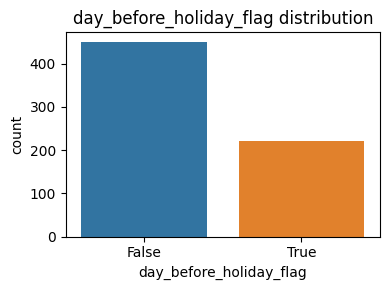

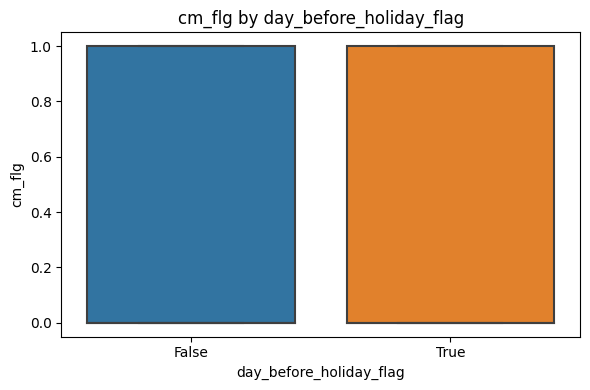

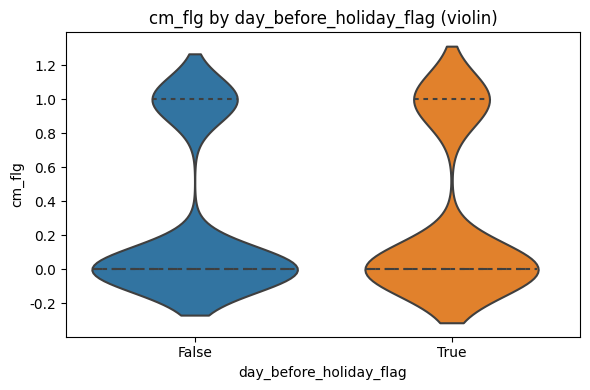


[cm_flg] by day_before_holiday_flag
                         count      mean       std  min  25%  50%  75%  max
day_before_holiday_flag                                                    
False                    450.0  0.293333  0.455797  0.0  0.0  0.0  1.0  1.0
True                     220.0  0.304545  0.461264  0.0  0.0  0.0  1.0  1.0


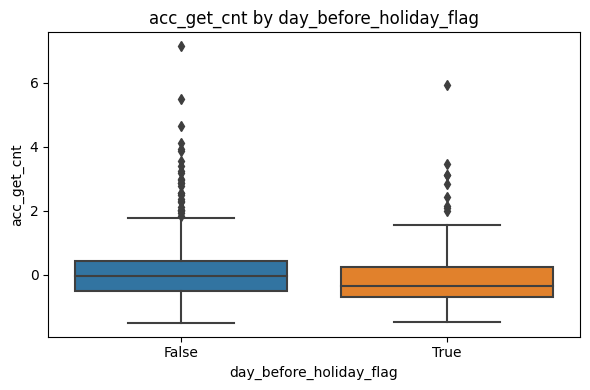

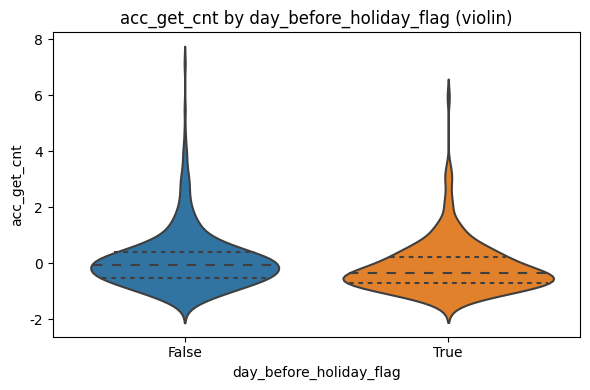


[acc_get_cnt] by day_before_holiday_flag
                         count      mean       std       min       25%  \
day_before_holiday_flag                                                  
False                    450.0  0.111890  1.033174 -1.508715 -0.517957   
True                     220.0 -0.123568  0.934334 -1.471561 -0.706820   

                              50%       75%       max  
day_before_holiday_flag                                
False                   -0.053539  0.420167  7.148030  
True                    -0.350767  0.237496  5.946736  


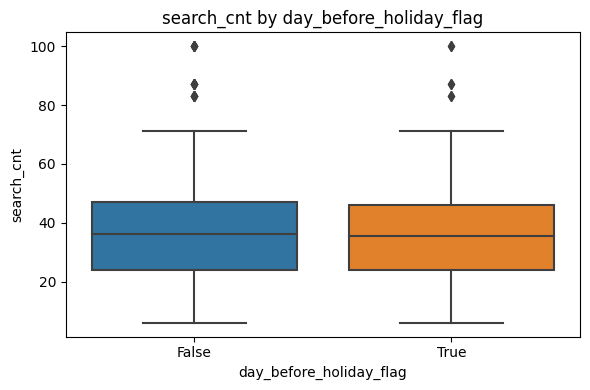

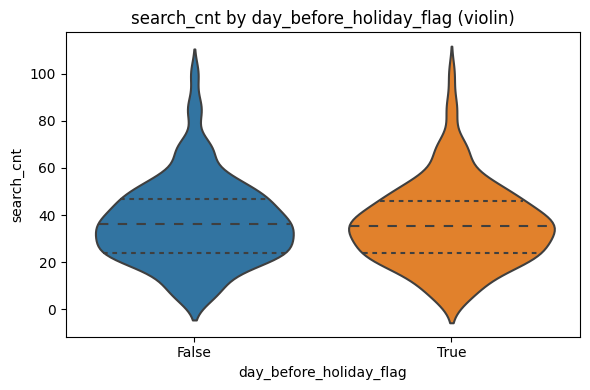


[search_cnt] by day_before_holiday_flag
                         count       mean        std  min   25%   50%   75%  \
day_before_holiday_flag                                                       
False                    448.0  37.020089  17.916212  6.0  24.0  36.0  47.0   
True                     220.0  36.000000  17.294653  6.0  24.0  35.5  46.0   

                           max  
day_before_holiday_flag         
False                    100.0  
True                     100.0  


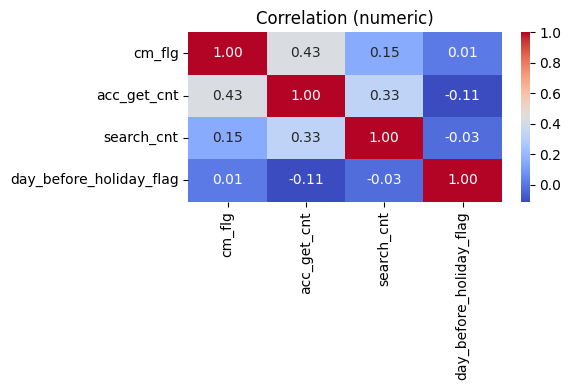

cm_flg: mean(0)=0.2933, mean(1)=0.3045, diff=0.0112
acc_get_cnt: mean(0)=0.1119, mean(1)=-0.1236, diff=-0.2355
search_cnt: mean(0)=37.0201, mean(1)=36.0000, diff=-1.0201


In [10]:
# day_before_holiday_flag を中心にしたEDAコード
# (pandas, seaborn, matplotlib を想定)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df を読み込んでいる前提。必要なら下を適宜変更
# df = pd.read_csv("train.csv")
import pandas as pd

import pandas as pd

df = pd.read_csv("../input/airregi_features_verified_safe.csv")

# 以降で df を使う

target_flag = "day_before_holiday_flag"
eda_cols = ["cm_flg", "acc_get_cnt", "search_cnt"]

# basic check
print(df[target_flag].value_counts(dropna=False))

# 0/1以外がある場合の確認
print("unique:", df[target_flag].unique())

# 数値/カテゴリを分ける
num_cols = [c for c in eda_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in eda_cols if c not in num_cols]

# ---- 1) day_before_holiday_flag の分布
plt.figure(figsize=(4,3))
sns.countplot(x=target_flag, data=df)
plt.title(f"{target_flag} distribution")
plt.tight_layout()
plt.show()

# ---- 2) day_before_holiday_flag x 数値特徴量（必須: cm_flg, acc_get_cntm, search_cnt）
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_flag, y=col, data=df)
    plt.title(f"{col} by {target_flag}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.violinplot(x=target_flag, y=col, data=df, inner="quartile")
    plt.title(f"{col} by {target_flag} (violin)")
    plt.tight_layout()
    plt.show()

    # 代表統計
    stats = df.groupby(target_flag)[col].describe()
    print(f"\n[{col}] by {target_flag}")
    print(stats)

# ---- 3) day_before_holiday_flag x カテゴリ特徴量
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=target_flag, data=df)
    plt.title(f"{col} count by {target_flag}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 率の比較
    ctab = pd.crosstab(df[col], df[target_flag], normalize="index")
    print(f"\n[{col}] proportion by {target_flag}")
    print(ctab)

# ---- 4) 相関 (数値のみ)
if len(num_cols) >= 2:
    corr = df[num_cols + [target_flag]].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation (numeric)")
    plt.tight_layout()
    plt.show()

# ---- 5) day_before_holiday_flag と他特徴量の差の検定(簡易)
# 例: 2群の平均差
for col in num_cols:
    mean0 = df.loc[df[target_flag]==0, col].mean()
    mean1 = df.loc[df[target_flag]==1, col].mean()
    print(f"{col}: mean(0)={mean0:.4f}, mean(1)={mean1:.4f}, diff={mean1-mean0:.4f}")


In [11]:
import pandas as pd
import numpy as np
from scipy import stats

# データ読み込み
df = pd.read_csv('../input/airregi_features_verified_safe.csv')

# 平日データのみ抽出（祝日・土日除外）
df_weekday = df[df['is_weekday'] == True].copy()

print("=" * 60)
print("1. acc_get_cnt（獲得数）と call_num の関係分析")
print("=" * 60)

# 相関係数
corr = df_weekday['acc_get_cnt'].corr(df_weekday['call_num'])
print(f"\n【相関係数】: {corr:.4f}")

# 線形回帰（回帰係数）
from sklearn.linear_model import LinearRegression
X = df_weekday[['acc_get_cnt']].values
y = df_weekday['call_num'].values

# NaN除外
mask = ~np.isnan(X.flatten()) & ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

model = LinearRegression()
model.fit(X_clean, y_clean)
coef = model.coef_[0]
intercept = model.intercept_

print(f"\n【回帰係数】: {coef:.4f}")
print(f"  → acc_get_cnt が 1 増えると call_num は約 {coef:.2f} 件増加")

# 1標準偏差増加時の効果
acc_std = df_weekday['acc_get_cnt'].std()
effect_1sigma = coef * acc_std
print(f"\n【1σ増加時の効果】")
print(f"  acc_get_cnt の標準偏差: {acc_std:.4f}")
print(f"  → acc_get_cnt が 1σ 増えると call_num は約 {effect_1sigma:.2f} 件増加")

print("\n")
print("=" * 60)
print("2. 祝日前フラグ（day_before_holiday_flag）の効果分析")
print("=" * 60)

# 祝日前フラグ別の平均入電数
holiday_before = df_weekday[df_weekday['day_before_holiday_flag'] == True]['call_num']
not_holiday_before = df_weekday[df_weekday['day_before_holiday_flag'] == False]['call_num']

mean_holiday_before = holiday_before.mean()
mean_not_holiday_before = not_holiday_before.mean()

diff_abs = mean_holiday_before - mean_not_holiday_before
diff_pct = (mean_holiday_before / mean_not_holiday_before - 1) * 100

print(f"\n【祝日前の日の平均入電数】: {mean_holiday_before:.2f} 件")
print(f"【それ以外の日の平均入電数】: {mean_not_holiday_before:.2f} 件")
print(f"\n【平均入電差】: +{diff_abs:.2f} 件 (+{diff_pct:.2f}%)")

# t検定
t_stat, p_value = stats.ttest_ind(holiday_before, not_holiday_before)
print(f"\n【統計的検定】")
print(f"  t値: {t_stat:.4f}")
print(f"  p値: {p_value:.4f}")
if p_value < 0.05:
    print("  → 統計的に有意な差あり (p < 0.05)")
else:
    print("  → 統計的に有意な差なし (p >= 0.05)")


1. acc_get_cnt（獲得数）と call_num の関係分析

【相関係数】: 0.7116

【回帰係数】: 77.3751
  → acc_get_cnt が 1 増えると call_num は約 77.38 件増加

【1σ増加時の効果】
  acc_get_cnt の標準偏差: 1.0289
  → acc_get_cnt が 1σ 増えると call_num は約 79.61 件増加


2. 祝日前フラグ（day_before_holiday_flag）の効果分析

【祝日前の日の平均入電数】: 158.14 件
【それ以外の日の平均入電数】: 164.75 件

【平均入電差】: +-6.61 件 (+-4.01%)

【統計的検定】
  t値: -0.5384
  p値: 0.5905
  → 統計的に有意な差なし (p >= 0.05)
